## Change sys.path to use my tensortrade instead of the one in env

In [1]:
import sys
import os
# sys.path.append("/Users/jasonfiacco/Documents/Yale/Senior/thesis/deeptrader")
# sys.path.append("/Users/jasonfiacco/Documents/Yale/Senior/thesis/deeptrader/GetOldTweets")
sys.path.append(os.path.realpath(".."))
sys.path.append(os.path.realpath("../GetOldTweets"))
print(sys.path)

['/home/accts/jcf73/thesis/deeptrader/examples', '/home/accts/jcf73/thesis/venv/lib64/python37.zip', '/home/accts/jcf73/thesis/venv/lib64/python3.7', '/home/accts/jcf73/thesis/venv/lib64/python3.7/lib-dynload', '/usr/lib64/python3.7', '/usr/lib/python3.7', '', '/home/accts/jcf73/thesis/venv/lib/python3.7/site-packages', '/home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/IPython/extensions', '/home/accts/jcf73/.ipython', '/home/accts/jcf73/thesis/deeptrader', '/home/accts/jcf73/thesis/deeptrader/GetOldTweets']


## Fetch the Labeled PredictIt Data  
Adds ALL TA features at first. Also creates the "price_norm" metric which is close/open.

In [2]:
import ssl
import pandas as pd
import ta
from datetime import datetime, timedelta

ssl._create_default_https_context = ssl._create_unverified_context # Only used if pandas gives a SSLError

def fetch_data(symbol):
    path = "../predictit_datasets/"
    filename = "{}_labeled.csv".format(symbol)

    df = pd.read_csv(path + filename)
    
    df = df.set_index("Date")


    return df

In [3]:
all_data = pd.concat([
    fetch_data("WARREN"),
    fetch_data("CRUZ"),
], axis=1)
all_data.head()

,WARREN:open,WARREN:low,WARREN:high,WARREN:close,WARREN:volume,WARREN:average,WARREN:price_norm,WARREN:current_date,WARREN:sentiment,WARREN:volume_adi,...,CRUZ:momentum_uo,CRUZ:momentum_stoch,CRUZ:momentum_stoch_signal,CRUZ:momentum_wr,CRUZ:momentum_ao,CRUZ:momentum_kama,CRUZ:momentum_roc,CRUZ:others_dr,CRUZ:others_dlr,CRUZ:others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-01,0.81,0.79,0.82,0.80,768,0.8067,0.987654,2017-02-01,0.04693,-256.0,...,NaN,14.285714,14.285714,-85.714286,0.0,NaN,NaN,6.111002,NaN,0.000000
2017-02-02,0.80,0.79,0.80,0.79,50,0.7996,0.987500,2017-02-02,0.05167,-306.0,...,NaN,0.000000,7.142857,-100.000000,0.0,NaN,NaN,-3.703704,-3.774033,-3.703704
2017-02-03,0.79,0.78,0.80,0.78,592,0.7813,0.987342,2017-02-03,0.07868,-898.0,...,NaN,33.333333,15.873016,-66.666667,0.0,NaN,NaN,3.846154,3.774033,0.000000
2017-02-04,0.78,0.78,0.79,0.79,10,0.7900,1.012821,2017-02-04,0.14822,-888.0,...,NaN,33.333333,22.222222,-66.666667,0.0,NaN,NaN,0.000000,0.000000,0.000000
2017-02-05,0.79,0.79,0.80,0.80,6,0.7950,1.012658,2017-02-05,-0.01526,-882.0,...,NaN,33.333333,33.333333,-66.666667,0.0,NaN,NaN,0.000000,0.000000,0.000000


## Plot the closing prices for all the markets

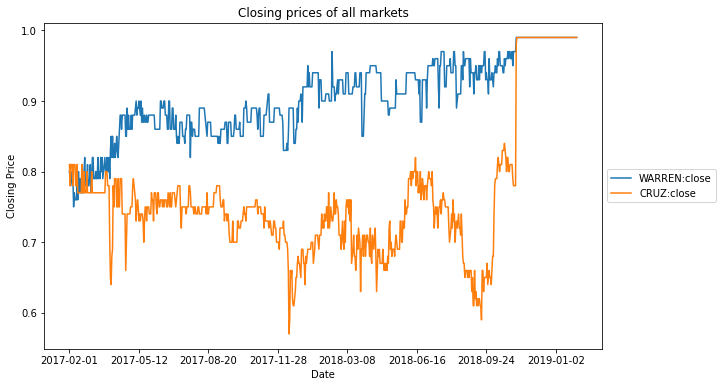

In [4]:
import matplotlib.pyplot as plt
closing_prices = all_data.loc[:, [("close" in name) for name in all_data.columns]]
closing_prices.plot(figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Closing prices of all markets")
plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.show()

In [5]:
#Copy it over cause of variable names
subset_data = all_data

## Define The Exchange

An exchange needs a name, an execution service, and streams of price data in order to function properly.

The setups supported right now are the simulated execution service using simulated or stochastic data. More execution services will be made available in the future, as well as price streams so that live data and execution can be supported.

In [6]:
from tensortrade.exchanges import Exchange
from tensortrade.exchanges.services.execution.simulated import execute_order
from tensortrade.data import Stream

#Exchange(name of exchange, service)
#It looks like each Stream takes a name, and then a list of the closing prices.

predictit_exch = Exchange("predictit", service=execute_order)(
    Stream("USD-WARREN", list(subset_data['WARREN:close'])),
    Stream("USD-CRUZ", list(subset_data['CRUZ:close'])),
)

Now that the exchanges have been defined we can define our features that we would like to include, excluding the prices we have provided for the exchanges.

## Defint the "Portfolio"

Make the portfolio using the any combinations of exchanges and intruments that the exchange supports

In [7]:
#I am going to have to add "instruments" for all 25 of the PredictIt markets I'm working with.
from tensortrade.instruments import USD, WARREN, CRUZ, MANCHIN, SANDERS, NELSON, DONNELLY,\
                                PELOSI, MANAFORT, BROWN, RYAN, STABENOW, KNIGHT, MCCASKILL, \
                                BALDWIN, DENHAM, HEITKAMP, TESTER, HURD, HEINRICH, MENENDEZ
from tensortrade.wallets import Wallet, Portfolio

portfolio = Portfolio(USD, [
    Wallet(predictit_exch, 100 * USD),
    Wallet(predictit_exch, 100 * WARREN),
    Wallet(predictit_exch, 100 * CRUZ)
])

## Create a feature dataframe that specifies custom features

In [8]:
#Select only the TA features to keep
features_to_keep = ["close"]
feature_data = subset_data.loc[:, [(any(word in name for word in features_to_keep)) for name in subset_data.columns]]

#Remove any extra volume columns
feature_data = feature_data[feature_data.columns.drop(list(feature_data.filter(regex='volume_')))]

feature_data.head(5)

,WARREN:close,CRUZ:close
Date,,
2017-02-01,0.80,0.81
2017-02-02,0.79,0.78
2017-02-03,0.78,0.81
2017-02-04,0.79,0.81
2017-02-05,0.80,0.81


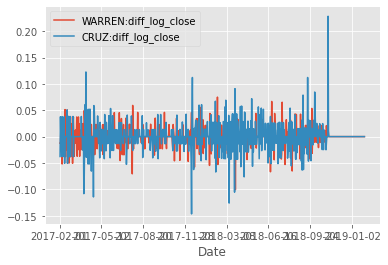

In [9]:
import numpy as np
feature_data["WARREN:diff_log_close"] = np.log(feature_data["WARREN:close"]) - np.log(feature_data["WARREN:close"].shift(1))
feature_data["CRUZ:diff_log_close"] = np.log(feature_data["CRUZ:close"]) - np.log(feature_data["CRUZ:close"].shift(1))
feature_data.drop(['WARREN:close', "CRUZ:close"], axis=1, inplace=True)
feature_data.plot()


In [10]:
#Add tomorrow's price
feature_data["WARREN:close_tomorrow"] = feature_data["WARREN:diff_log_close"].shift(1)
feature_data["CRUZ:close_tomorrow"] = feature_data["CRUZ:diff_log_close"].shift(1)
#Replace all inf and -inf (which are in the trend_cci column) with Nan
import numpy as np
feature_data = feature_data.replace([np.inf, -np.inf, np.nan], 0)
feature_data.head(5)

,WARREN:diff_log_close,CRUZ:diff_log_close,WARREN:close_tomorrow,CRUZ:close_tomorrow
Date,,,,
2017-02-01,0.000000,0.00000,0.000000,0.00000
2017-02-02,-0.012579,-0.03774,0.000000,0.00000
2017-02-03,-0.012739,0.03774,-0.012579,-0.03774
2017-02-04,0.012739,0.00000,-0.012739,0.03774
2017-02-05,0.012579,0.00000,0.012739,0.00000


### Now make the "External Data Feed" objects

In [11]:
#Add "Streams" for all my external added features.
from tensortrade.data import DataFeed, Module

#Do it for train set
with Module("predictit") as predictit_ns:
    predictit_nodes = [Stream(name, list(feature_data[name])) for name in feature_data.columns]

In [12]:
#Then create the train Feed from it
external_feed = DataFeed([predictit_ns])
external_feed.next()

{'predictit:/WARREN:diff_log_close': 0.0,
 'predictit:/CRUZ:diff_log_close': 0.0,
 'predictit:/WARREN:close_tomorrow': 0.0,
 'predictit:/CRUZ:close_tomorrow': 0.0}

## First Launch Ray. 
This is where you define our training "Trading Enviroment," which includes things such as the action scheme, the reward scheme, the window size, and whether or not to use the "interal feed" (internal data feed has all the price data from the wallets and the networth of the portfolio).

In [13]:
#Add the deeptrader path to ALL workers, not just the current worker
import os
parent_dir = os.path.realpath("..")
os.environ["PYTHONPATH"] = parent_dir + ":" + os.environ.get("PYTHONPATH", "")

In [14]:
#Try and get rid of that yaml warning (although this only does it for THIS worker)
import yaml
yaml.warnings({'YAMLLoadWarning': False})

In [15]:
# Environment
from tensortrade.environments import TradingEnvironment


import gym
import ray
from ray import tune
from ray.tune import grid_search
from ray.tune.registry import register_env

import ray.rllib.agents.ppo as ppo
import ray.rllib.agents.dqn as dqn
from ray.tune.logger import pretty_print
from tensortrade.rewards import RiskAdjustedReturns
    
class RayTradingEnv(TradingEnvironment):
    def __init__(self):        
        env = TradingEnvironment(
            feed=external_feed,
            portfolio=portfolio,
            action_scheme="simple",
            reward_scheme="diversified",
            window_size=15,
            enable_logger=False,
            renderers = 'screenlog',
            #use_internal = True,
        ) 
        self.env = env
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space
        
        

    def reset(self):
        return self.env.reset()

    def step(self, action):
        return self.env.step(action)

def env_creator(env_config):
    return RayTradingEnv()

register_env("ray_trading_env", env_creator)


#ray.init(ignore_reinit_error=True, local_mode=True)

## Train using Tune

In [16]:
#Implement Custom neural network model
from ray.rllib.models import ModelCatalog
from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from ray.rllib.agents.dqn.distributional_q_model import DistributionalQModel
from ray.rllib.utils import try_import_tf

tf = try_import_tf()

class CNNModel(DistributionalQModel):
    """Custom model for DQN."""

    def __init__(self, obs_space, action_space, num_outputs, model_config,
                 name, **kw):
        super(CNNModel, self).__init__(
            obs_space, action_space, num_outputs, model_config, name, **kw)

        # Define neural net layers
        self.base_model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=obs_space.shape),
            tf.keras.layers.Conv1D(filters=40, kernel_size=6, padding="same", activation="relu"),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.Conv1D(filters=20, kernel_size=3, padding="same", activation="relu"),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_outputs, activation="softmax")
        ])
        
        self.register_variables(self.base_model.variables)

    # Implement the core forward method
    def forward(self, input_dict, state, seq_lens):
        model_out = self.base_model(input_dict["obs"])
        return model_out, state
    
ModelCatalog.register_custom_model("cnn_model", CNNModel)

In [17]:
# Population based training
from ray.tune.schedulers import PopulationBasedTraining
import random

pbt = PopulationBasedTraining(
    time_attr="time_total_s",
    metric="episode_reward_mean",
    mode="max",
    perturbation_interval=240, #Every 10,000 steps, consider changing learning rate
    hyperparam_mutations={
        "lr": lambda: random.uniform(.00001, .1),
        #"epsilon_timesteps": lambda: random.uniform(10000, 100000)
        #"train_batch_size": lambda: random.uniform(10, 1000),
    } 
)

In [18]:
analysis = tune.run(
        "DQN",
        name = "DQN53-mini",
        #restore = "/home/accts/jcf73/ray_results/DQN53-mini/DQN_ray_trading_env_da36079e_0_2020-04-10_15-17-00m1kzpf5o/checkpoint_150/checkpoint-150",
        #scheduler=pbt, #Use Population Based Training
        #num_samples=3, #Number of different hyperparameters to sample
        #reuse_actors=True,
        checkpoint_freq = 50,
        checkpoint_at_end=True,
        stop={
            "timesteps_total": 10000000,
        },
        config={
            "env": "ray_trading_env",
            "lr": .00001,  # try different lrs
            "num_workers": 18,  # parallelism,
            #"eager": "true",
            #"model": {
            #    "custom_model": "cnn_model"
            #},
            "exploration_config": {
                "initial_epsilon": 0.85,
                "epsilon_timesteps": 3000000,
                
            },
            "train_batch_size": 100,
            #"clip_rewards": True,
            #"grad_norm_clipping": None,
            "target_network_update_freq": 2000,
        },
        
    )

2020-04-11 12:08:48,607	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-04-11 12:08:48,617	INFO resource_spec.py:212 -- Starting Ray with 34.86 GiB memory available for workers and up to 17.44 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-04-11 12:08:49,175	INFO services.py:1078 -- View the Ray dashboard at localhost:8266


Trial name,status,loc
DQN_ray_trading_env_bad7e084,RUNNING,


(pid=27219) 2020-04-11 12:08:55,719	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
(pid=27219) 2020-04-11 12:08:58,810	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=27219) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
(pid=27219)   obj = yaml.load(type_)
(pid=27219) 2020-04-11 12:09:00,451	WARNING util.py:37 -- Install gputil for GPU system monitoring.
(pid=27229) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
(pid=27229)   obj

Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-09-14
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    grad_time_ms: .nan
    learner: {}
    num_steps_sampled: 1008
    num_steps_trained: 0
    num_target_updates: 0
    opt_peak_th

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,nan,13.9372,1008,1


(pid=27219) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
(pid=27219)   out=out, **kwargs)
(pid=27219) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
(pid=27219)   ret = ret.dtype.type(ret / rcount)


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-09-23
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    grad_time_ms: 12.517
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        max_q: 1.371289849281311
  

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,nan,22.8144,3024,3


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-09-28
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8494422435760498
    - 0.8494422435760498
    - 0.8494422435760498
    - 0.8494422435760498
    - 0.8494422435760498
    - 0.8494422435760498
    - 0.8494422435760498
    - 0.8494422435760498
    - 0.8494422435760498
    - 0.8494422435760498
    - 0.8494422435760498
    - 0.8494422435760498
    - 0.8494422435760498
    - 0.8494422435760498
    - 0.8494422435760498
    - 0.8494422435760498
    - 0.8494422435760498
    - 0.8494422435760498
    grad_time_ms: 12.671
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        max_q: 1.4073681831359863
 

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,nan,27.8414,4032,4


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-09-33
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    grad_time_ms: 12.712
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        max_q: 1.6987800598144531
 

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,nan,33.3565,5040,5


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-09-40
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    grad_time_ms: 12.86
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        max_q: 2.630063772201538
   

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,nan,39.4413,6048,6


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-09-46
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    grad_time_ms: 12.76
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        max_q: 2.280606746673584
   

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,nan,46.1523,7056,7


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-09-53
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    grad_time_ms: 12.939
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        max_q: 2.4694223403930664
 

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,nan,53.2881,8064,8


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-10-01
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    grad_time_ms: 12.625
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        max_q: 2.7244553565979004
 

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,nan,61.0767,9072,9


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-10-10
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    grad_time_ms: 12.944
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        max_q: 2.963024139404297
  

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,nan,69.4182,10080,10


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-10-19
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    grad_time_ms: 12.718
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        max_q: 3.4603657722473145
 

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,nan,78.6623,11088,11


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-10-29
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    grad_time_ms: 12.959
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        max_q: 3.852228879928589
  

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,nan,88.793,12096,12


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-10-39
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    grad_time_ms: 12.874
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        max_q: 3.741504669189453
  

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,nan,98.6054,13104,13


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-10-47
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4121581910385481
  episode_reward_mean: 0.16425461293608276
  episode_reward_min: -0.08334131476467106
  episodes_this_iter: 0
  episodes_total: 18
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    grad_time_ms: 12.75
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.164255,106.285,15120,15


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-10-57
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4121581910385481
  episode_reward_mean: 0.16425461293608276
  episode_reward_min: -0.08334131476467106
  episodes_this_iter: 0
  episodes_total: 18
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    grad_time_ms: 13.183
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.164255,116.192,17136,17


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-11-02
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4121581910385481
  episode_reward_mean: 0.16425461293608276
  episode_reward_min: -0.08334131476467106
  episodes_this_iter: 0
  episodes_total: 18
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    grad_time_ms: 12.878
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.164255,121.998,18144,18


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-11-09
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4121581910385481
  episode_reward_mean: 0.16425461293608276
  episode_reward_min: -0.08334131476467106
  episodes_this_iter: 0
  episodes_total: 18
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    grad_time_ms: 12.73
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.164255,128.298,19152,19


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-11-16
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4121581910385481
  episode_reward_mean: 0.16425461293608276
  episode_reward_min: -0.08334131476467106
  episodes_this_iter: 0
  episodes_total: 18
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    grad_time_ms: 14.877
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.164255,135.137,20160,20


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-11-23
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4121581910385481
  episode_reward_mean: 0.16425461293608276
  episode_reward_min: -0.08334131476467106
  episodes_this_iter: 0
  episodes_total: 18
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    grad_time_ms: 13.02
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.164255,142.555,21168,21


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-11-31
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4121581910385481
  episode_reward_mean: 0.16425461293608276
  episode_reward_min: -0.08334131476467106
  episodes_this_iter: 0
  episodes_total: 18
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    grad_time_ms: 12.979
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.164255,150.497,22176,22


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-11-40
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4121581910385481
  episode_reward_mean: 0.16425461293608276
  episode_reward_min: -0.08334131476467106
  episodes_this_iter: 0
  episodes_total: 18
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    grad_time_ms: 13.191
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.164255,159.172,23184,23


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-11-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4121581910385481
  episode_reward_mean: 0.16425461293608276
  episode_reward_min: -0.08334131476467106
  episodes_this_iter: 0
  episodes_total: 18
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    grad_time_ms: 13.231
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.164255,168.189,24192,24


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-11-59
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4121581910385481
  episode_reward_mean: 0.16425461293608276
  episode_reward_min: -0.08334131476467106
  episodes_this_iter: 0
  episodes_total: 18
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    grad_time_ms: 12.932
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.164255,177.937,25200,25


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-12-09
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4121581910385481
  episode_reward_mean: 0.16425461293608276
  episode_reward_min: -0.08334131476467106
  episodes_this_iter: 0
  episodes_total: 18
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    grad_time_ms: 13.988
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.164255,188.152,26208,26


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-12-17
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.2077659754263871
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 36
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    grad_time_ms: 12.944
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.207766,196.021,28224,28


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-12-27
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.2077659754263871
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 36
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    grad_time_ms: 13.212
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.207766,205.853,30240,30


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-12-32
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.2077659754263871
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 36
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    grad_time_ms: 13.118
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.207766,211.682,31248,31


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-12-39
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.2077659754263871
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 36
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    grad_time_ms: 13.091
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.207766,218.076,32256,32


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-12-46
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.2077659754263871
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 36
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    grad_time_ms: 13.088
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.207766,225.049,33264,33


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-12-53
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.2077659754263871
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 36
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    grad_time_ms: 13.024
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.207766,232.623,34272,34


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-13-01
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.2077659754263871
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 36
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    grad_time_ms: 12.926
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
       

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.207766,240.613,35280,35


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-13-10
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.2077659754263871
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 36
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    grad_time_ms: 12.88
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.207766,249.165,36288,36


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-13-20
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.2077659754263871
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 36
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    grad_time_ms: 13.089
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.207766,258.594,37296,37


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-13-29
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.2077659754263871
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 36
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    grad_time_ms: 12.768
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.207766,268.249,38304,38


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-13-40
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.2077659754263871
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 36
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    grad_time_ms: 12.917
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.207766,278.595,39312,39


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-13-48
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.21078456285358205
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 54
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    grad_time_ms: 13.032
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.210785,286.944,41328,41


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-13-58
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.21078456285358205
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 54
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    grad_time_ms: 12.976
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.210785,296.737,43344,43


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-14-04
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.21078456285358205
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 54
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    grad_time_ms: 12.914
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.210785,302.534,44352,44


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-14-10
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.21078456285358205
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 54
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    grad_time_ms: 13.072
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.210785,308.96,45360,45


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-14-17
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.21078456285358205
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 54
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    grad_time_ms: 13.07
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
       

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.210785,316.257,46368,46


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-14-25
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.21078456285358205
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 54
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    grad_time_ms: 12.99
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
       

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.210785,324.082,47376,47


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-14-34
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.21078456285358205
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 54
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    grad_time_ms: 13.067
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.210785,332.613,48384,48


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-14-43
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.21078456285358205
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 54
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    grad_time_ms: 13.025
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.210785,341.476,49392,49


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-14-52
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.21078456285358205
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 54
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    grad_time_ms: 13.123
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.210785,350.631,50400,50


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-15-02
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.21078456285358205
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 54
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    grad_time_ms: 13.215
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.210785,360.498,51408,51


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-15-12
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.21078456285358205
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 54
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    grad_time_ms: 13.003
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.210785,370.724,52416,52


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-15-21
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.20720640637775764
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 72
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    grad_time_ms: 13.221
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.207206,379.112,54432,54


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-15-31
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.20720640637775764
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 72
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    grad_time_ms: 12.985
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.207206,389.134,56448,56


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-15-36
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.20720640637775764
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 72
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    grad_time_ms: 13.242
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.207206,394.977,57456,57


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-15-43
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.20720640637775764
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 72
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    grad_time_ms: 13.236
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.207206,401.338,58464,58


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-15-50
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.20720640637775764
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 72
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    grad_time_ms: 13.026
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.207206,408.277,59472,59


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-15-57
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.20720640637775764
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 72
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    grad_time_ms: 13.4
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.207206,415.741,60480,60


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-16-06
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.20720640637775764
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 72
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    grad_time_ms: 13.177
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.207206,423.975,61488,61


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-16-14
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.20720640637775764
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 72
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    grad_time_ms: 13.517
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.207206,432.696,62496,62


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-16-24
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.20720640637775764
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 72
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    grad_time_ms: 13.218
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.207206,441.957,63504,63


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-16-34
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.20720640637775764
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 72
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    grad_time_ms: 13.35
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.207206,451.867,64512,64


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-16-44
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.20720640637775764
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 72
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    grad_time_ms: 13.423
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.207206,462.272,65520,65


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-16-53
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.20653874528600996
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 90
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    grad_time_ms: 13.076
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.206539,470.911,67536,67


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-17-03
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.20653874528600996
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 90
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    grad_time_ms: 13.243
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.206539,480.909,69552,69


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-17-09
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.20653874528600996
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 90
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    grad_time_ms: 13.058
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.206539,486.713,70560,70


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-17-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.20653874528600996
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 90
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    grad_time_ms: 13.167
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.206539,492.943,71568,71


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-17-22
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.20653874528600996
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 90
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    grad_time_ms: 13.058
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.206539,499.918,72576,72


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-17-29
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.20653874528600996
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 90
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    grad_time_ms: 13.147
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.206539,507.525,73584,73


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-17-38
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.20653874528600996
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 90
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    grad_time_ms: 13.09
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.206539,515.585,74592,74


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-17-46
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.20653874528600996
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 90
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    grad_time_ms: 12.909
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.206539,524.195,75600,75


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-17-56
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.20653874528600996
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 90
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    grad_time_ms: 13.336
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.206539,533.56,76608,76


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-18-06
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.20653874528600996
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 90
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    grad_time_ms: 13.448
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.206539,543.458,77616,77


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-18-16
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.20653874528600996
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 90
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    grad_time_ms: 13.022
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.206539,553.832,78624,78


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-18-25
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.19466791443819556
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 108
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    grad_time_ms: 13.532
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.194668,562.748,80640,80


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-18-35
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.19466791443819556
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 108
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    grad_time_ms: 12.915
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.194668,572.625,82656,82


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-18-41
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.19466791443819556
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 108
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    grad_time_ms: 13.272
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.194668,578.448,83664,83


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-18-47
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.19466791443819556
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 108
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    grad_time_ms: 13.055
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.194668,584.717,84672,84


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-18-54
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.19466791443819556
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 108
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    grad_time_ms: 13.289
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.194668,592.064,85680,85


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-19-02
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.19466791443819556
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 108
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    grad_time_ms: 13.091
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.194668,599.764,86688,86


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-19-11
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.19466791443819556
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 108
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    grad_time_ms: 13.091
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.194668,608.336,87696,87


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-19-20
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.19466791443819556
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 108
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    grad_time_ms: 13.426
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.194668,617.542,88704,88


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-19-30
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.19466791443819556
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 108
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    grad_time_ms: 13.336
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.194668,627.129,89712,89


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-19-39
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.19466791443819556
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 108
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    grad_time_ms: 13.304
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.194668,636.972,90720,90


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-19-50
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7296324732942591
  episode_reward_mean: 0.19466791443819556
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 108
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    grad_time_ms: 13.82
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.194668,647.552,91728,91


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-19-55
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.18388725218347696
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 18
  episodes_total: 126
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    grad_time_ms: 13.848
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.183887,652.696,92736,92


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-20-04
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.18388725218347696
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 126
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    grad_time_ms: 13.919
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.183887,661.489,94752,94


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-20-09
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.18388725218347696
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 126
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    grad_time_ms: 13.36
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.183887,666.706,95760,95


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-20-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.18388725218347696
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 126
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    grad_time_ms: 13.615
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.183887,672.4,96768,96


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-20-21
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.18388725218347696
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 126
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    grad_time_ms: 12.992
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.183887,678.821,97776,97


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-20-28
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.18388725218347696
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 126
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    grad_time_ms: 13.223
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.183887,685.629,98784,98


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-20-36
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.18388725218347696
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 126
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    grad_time_ms: 12.871
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.183887,693.117,99792,99


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-20-44
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.18388725218347696
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 126
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    grad_time_ms: 13.096
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.183887,701.201,100800,100


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-20-53
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.18388725218347696
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 126
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    grad_time_ms: 13.137
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.183887,710.015,101808,101


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-21-02
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.18388725218347696
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 126
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    grad_time_ms: 13.25
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.183887,719.383,102816,102


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-21-12
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.18388725218347696
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 126
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    grad_time_ms: 13.449
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.183887,729.262,103824,103


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-21-23
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.18388725218347696
  episode_reward_min: -0.23509811032388933
  episodes_this_iter: 0
  episodes_total: 126
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    grad_time_ms: 13.308
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.183887,739.774,104832,104


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-21-28
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.1673423468007433
  episode_reward_min: -0.1597247911310276
  episodes_this_iter: 18
  episodes_total: 144
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    grad_time_ms: 13.126
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167342,745,105840,105


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-21-37
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.16734234680074336
  episode_reward_min: -0.1597247911310276
  episodes_this_iter: 0
  episodes_total: 144
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    grad_time_ms: 13.041
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167342,753.532,107856,107


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-21-42
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.16734234680074336
  episode_reward_min: -0.1597247911310276
  episodes_this_iter: 0
  episodes_total: 144
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    grad_time_ms: 13.071
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167342,758.662,108864,108


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-21-47
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.16734234680074336
  episode_reward_min: -0.1597247911310276
  episodes_this_iter: 0
  episodes_total: 144
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    grad_time_ms: 13.17
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167342,764.274,109872,109


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-21-54
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.16734234680074336
  episode_reward_min: -0.1597247911310276
  episodes_this_iter: 0
  episodes_total: 144
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    grad_time_ms: 13.242
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167342,770.596,110880,110


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-22-01
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.16734234680074336
  episode_reward_min: -0.1597247911310276
  episodes_this_iter: 0
  episodes_total: 144
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    grad_time_ms: 13.286
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167342,777.394,111888,111


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-22-08
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.16734234680074336
  episode_reward_min: -0.1597247911310276
  episodes_this_iter: 0
  episodes_total: 144
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    grad_time_ms: 13.132
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167342,784.993,112896,112


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-22-16
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.16734234680074336
  episode_reward_min: -0.1597247911310276
  episodes_this_iter: 0
  episodes_total: 144
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    grad_time_ms: 13.243
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167342,793.083,113904,113


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-22-25
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.16734234680074336
  episode_reward_min: -0.1597247911310276
  episodes_this_iter: 0
  episodes_total: 144
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    grad_time_ms: 12.994
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167342,801.619,114912,114


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-22-34
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.16734234680074336
  episode_reward_min: -0.1597247911310276
  episodes_this_iter: 0
  episodes_total: 144
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    grad_time_ms: 14.559
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167342,811.048,115920,115


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-22-44
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.16734234680074336
  episode_reward_min: -0.1597247911310276
  episodes_this_iter: 0
  episodes_total: 144
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    grad_time_ms: 13.31
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167342,820.946,116928,116


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-22-55
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.16734234680074336
  episode_reward_min: -0.1597247911310276
  episodes_this_iter: 0
  episodes_total: 144
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    grad_time_ms: 12.972
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167342,831.262,117936,117


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-23-00
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.17432749875435619
  episode_reward_min: -0.1597247911310276
  episodes_this_iter: 18
  episodes_total: 162
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    grad_time_ms: 13.034
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.174327,836.759,118944,118


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-23-09
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.17432749875435619
  episode_reward_min: -0.1597247911310276
  episodes_this_iter: 0
  episodes_total: 162
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    grad_time_ms: 13.099
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.174327,845.51,120960,120


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-23-14
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.17432749875435619
  episode_reward_min: -0.1597247911310276
  episodes_this_iter: 0
  episodes_total: 162
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    grad_time_ms: 14.231
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.174327,850.692,121968,121


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-23-20
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.17432749875435619
  episode_reward_min: -0.1597247911310276
  episodes_this_iter: 0
  episodes_total: 162
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    grad_time_ms: 13.042
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.174327,856.499,122976,122


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-23-26
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.17432749875435619
  episode_reward_min: -0.1597247911310276
  episodes_this_iter: 0
  episodes_total: 162
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    grad_time_ms: 12.945
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.174327,862.881,123984,123


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-23-34
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.17432749875435619
  episode_reward_min: -0.1597247911310276
  episodes_this_iter: 0
  episodes_total: 162
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    grad_time_ms: 13.063
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.174327,870.092,124992,124


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-23-41
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.17432749875435619
  episode_reward_min: -0.1597247911310276
  episodes_this_iter: 0
  episodes_total: 162
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    grad_time_ms: 13.246
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.174327,877.925,126000,125


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-23-50
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.17432749875435619
  episode_reward_min: -0.1597247911310276
  episodes_this_iter: 0
  episodes_total: 162
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    grad_time_ms: 12.833
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.174327,886.024,127008,126


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-23-59
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.17432749875435619
  episode_reward_min: -0.1597247911310276
  episodes_this_iter: 0
  episodes_total: 162
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    grad_time_ms: 13.069
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.174327,895.273,128016,127


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-24-09
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.17432749875435619
  episode_reward_min: -0.1597247911310276
  episodes_this_iter: 0
  episodes_total: 162
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    grad_time_ms: 14.289
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.174327,904.977,129024,128


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-24-18
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.17432749875435619
  episode_reward_min: -0.1597247911310276
  episodes_this_iter: 0
  episodes_total: 162
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    grad_time_ms: 13.661
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.174327,914.773,130032,129


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-24-30
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.17432749875435619
  episode_reward_min: -0.1597247911310276
  episodes_this_iter: 0
  episodes_total: 162
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    grad_time_ms: 13.482
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.174327,925.885,131040,130


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-24-35
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.1649865935471805
  episode_reward_min: -0.23582065497809562
  episodes_this_iter: 18
  episodes_total: 180
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    grad_time_ms: 13.003
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.164987,931.464,132048,131


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-24-44
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.1649865935471805
  episode_reward_min: -0.23582065497809562
  episodes_this_iter: 0
  episodes_total: 180
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    grad_time_ms: 13.382
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.164987,940.184,134064,133


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-24-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.1649865935471805
  episode_reward_min: -0.23582065497809562
  episodes_this_iter: 0
  episodes_total: 180
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    grad_time_ms: 13.046
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.164987,945.264,135072,134


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-24-55
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.1649865935471805
  episode_reward_min: -0.23582065497809562
  episodes_this_iter: 0
  episodes_total: 180
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    grad_time_ms: 13.36
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
       

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.164987,951.066,136080,135


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-25-01
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.1649865935471805
  episode_reward_min: -0.23582065497809562
  episodes_this_iter: 0
  episodes_total: 180
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    grad_time_ms: 13.886
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.164987,957.265,137088,136


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-25-08
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.1649865935471805
  episode_reward_min: -0.23582065497809562
  episodes_this_iter: 0
  episodes_total: 180
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    grad_time_ms: 13.22
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.164987,964.178,138096,137


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-25-16
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.1649865935471805
  episode_reward_min: -0.23582065497809562
  episodes_this_iter: 0
  episodes_total: 180
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    grad_time_ms: 12.961
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.164987,971.724,139104,138


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-25-24
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.1649865935471805
  episode_reward_min: -0.23582065497809562
  episodes_this_iter: 0
  episodes_total: 180
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    grad_time_ms: 13.221
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.164987,979.721,140112,139


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-25-33
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.1649865935471805
  episode_reward_min: -0.23582065497809562
  episodes_this_iter: 0
  episodes_total: 180
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    grad_time_ms: 13.249
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.164987,988.564,141120,140


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-25-42
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.1649865935471805
  episode_reward_min: -0.23582065497809562
  episodes_this_iter: 0
  episodes_total: 180
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    grad_time_ms: 12.888
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.164987,997.682,142128,141


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-25-52
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.1649865935471805
  episode_reward_min: -0.23582065497809562
  episodes_this_iter: 0
  episodes_total: 180
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    grad_time_ms: 13.136
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.164987,1007.48,143136,142


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-26-02
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5635419767513752
  episode_reward_mean: 0.1649865935471805
  episode_reward_min: -0.23582065497809562
  episodes_this_iter: 0
  episodes_total: 180
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    grad_time_ms: 13.137
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.164987,1017.84,144144,143


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-26-08
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15803804977517769
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 18
  episodes_total: 198
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    grad_time_ms: 13.237
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.158038,1024.08,145152,144


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-26-17
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15803804977517774
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 198
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    grad_time_ms: 13.368
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.158038,1032.78,147168,146


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-26-22
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15803804977517774
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 198
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    grad_time_ms: 13.2
    learner:
      default_policy:
        cur_lr: 9.99999974737

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.158038,1037.98,148176,147


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-26-28
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15803804977517774
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 198
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    grad_time_ms: 13.039
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.158038,1043.47,149184,148


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-26-34
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15803804977517774
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 198
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    grad_time_ms: 13.186
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.158038,1049.9,150192,149


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-26-41
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15803804977517774
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 198
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    grad_time_ms: 12.95
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.158038,1056.47,151200,150


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-26-48
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15803804977517774
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 198
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    grad_time_ms: 13.11
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.158038,1063.98,152208,151


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-26-56
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15803804977517774
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 198
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    grad_time_ms: 12.998
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.158038,1072.07,153216,152


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-27-05
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15803804977517774
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 198
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    grad_time_ms: 13.201
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.158038,1080.7,154224,153


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-27-14
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15803804977517774
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 198
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    grad_time_ms: 13.412
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.158038,1090,155232,154


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-27-24
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15803804977517774
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 198
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    grad_time_ms: 13.15
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.158038,1099.81,156240,155


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-27-35
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15803804977517774
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 198
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    grad_time_ms: 13.252
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
       

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.158038,1110.13,157248,156


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-27-41
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15588522330721266
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 18
  episodes_total: 216
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    grad_time_ms: 13.389
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.155885,1116.38,158256,157


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-27-50
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15588522330721266
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 216
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    grad_time_ms: 13.12
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.155885,1124.98,160272,159


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-27-55
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15588522330721266
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 216
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    grad_time_ms: 13.137
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.155885,1130.08,161280,160


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-28-00
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15588522330721266
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 216
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    grad_time_ms: 12.959
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.155885,1135.75,162288,161


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-28-07
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15588522330721266
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 216
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    grad_time_ms: 13.123
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.155885,1142.03,163296,162


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-28-14
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15588522330721266
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 216
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    grad_time_ms: 13.151
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.155885,1148.81,164304,163


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-28-21
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15588522330721266
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 216
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    grad_time_ms: 13.217
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.155885,1156.22,165312,164


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-28-29
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15588522330721266
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 216
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    grad_time_ms: 12.909
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.155885,1164.33,166320,165


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-28-38
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15588522330721266
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 216
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    grad_time_ms: 13.15
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.155885,1173.11,167328,166


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-28-48
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15588522330721266
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 216
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    grad_time_ms: 13.202
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.155885,1182.65,168336,167


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-28-58
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15588522330721266
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 216
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    grad_time_ms: 13.246
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.155885,1192.72,169344,168


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-29-08
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15588522330721266
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 216
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    grad_time_ms: 13.271
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.155885,1203.13,170352,169


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-29-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15857171245988697
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 18
  episodes_total: 234
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    grad_time_ms: 13.276
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.158572,1210.35,171360,170


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-29-24
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15857171245988694
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 234
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    grad_time_ms: 13.078
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.158572,1219.11,173376,172


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-29-30
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15857171245988694
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 234
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    grad_time_ms: 13.067
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.158572,1224.52,174384,173


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-29-35
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15857171245988694
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 234
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    grad_time_ms: 13.122
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.158572,1230.18,175392,174


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-29-42
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15857171245988694
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 234
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    grad_time_ms: 13.137
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.158572,1236.74,176400,175


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-29-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15857171245988694
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 234
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    grad_time_ms: 13.072
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.158572,1243.7,177408,176


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-29-56
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15857171245988694
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 234
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    grad_time_ms: 13.136
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.158572,1251.14,178416,177


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-30-04
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15857171245988694
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 234
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    grad_time_ms: 13.171
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.158572,1259.25,179424,178


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-30-13
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15857171245988694
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 234
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    grad_time_ms: 13.126
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.158572,1267.95,180432,179


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-30-22
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15857171245988694
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 234
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    grad_time_ms: 13.182
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.158572,1277.15,181440,180


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-30-32
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15857171245988694
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 234
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    grad_time_ms: 13.101
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.158572,1286.89,182448,181


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-30-43
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15857171245988694
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 234
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    grad_time_ms: 13.331
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.158572,1297.22,183456,182


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-30-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15962138788014862
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 18
  episodes_total: 252
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    grad_time_ms: 13.239
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.159621,1303.89,184464,183


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-30-58
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15962138788014862
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 252
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    grad_time_ms: 13.192
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.159621,1312.38,186480,185


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-31-03
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15962138788014862
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 252
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7986860871315002
    - 0.7986860871315002
    - 0.7986860871315002
    - 0.7986860871315002
    - 0.7986860871315002
    - 0.7986860871315002
    - 0.7986860871315002
    - 0.7986860871315002
    - 0.7986860871315002
    - 0.7986860871315002
    - 0.7986860871315002
    - 0.7986860871315002
    - 0.7986860871315002
    - 0.7986860871315002
    - 0.7986860871315002
    - 0.7986860871315002
    - 0.7986860871315002
    - 0.7986860871315002
    grad_time_ms: 12.954
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.159621,1317.49,187488,186


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-31-09
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15962138788014862
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 252
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    grad_time_ms: 13.202
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.159621,1323.09,188496,187


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-31-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15962138788014862
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 252
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    grad_time_ms: 13.046
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.159621,1329.22,189504,188


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-31-22
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15962138788014862
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 252
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    grad_time_ms: 14.183
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.159621,1336.04,190512,189


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-31-29
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15962138788014862
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 252
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    grad_time_ms: 13.196
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.159621,1343.55,191520,190


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-31-37
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15962138788014862
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 252
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    grad_time_ms: 14.059
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.159621,1351.54,192528,191


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-31-46
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15962138788014862
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 252
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    grad_time_ms: 13.138
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.159621,1360.04,193536,192


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-31-55
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15962138788014862
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 252
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    grad_time_ms: 13.354
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.159621,1369.11,194544,193


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-32-04
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15962138788014862
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 252
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    grad_time_ms: 13.189
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.159621,1378.78,195552,194


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-32-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.15962138788014862
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 252
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    grad_time_ms: 12.987
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.159621,1389.03,196560,195


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-32-22
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.13838618787097404
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 18
  episodes_total: 270
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    grad_time_ms: 13.264
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138386,1396.27,197568,196


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-32-31
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.13838618787097404
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 270
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    grad_time_ms: 13.212
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138386,1404.74,199584,198


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-32-36
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.13838618787097404
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 270
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7950606346130371
    - 0.7950606346130371
    - 0.7950606346130371
    - 0.7950606346130371
    - 0.7950606346130371
    - 0.7950606346130371
    - 0.7950606346130371
    - 0.7950606346130371
    - 0.7950606346130371
    - 0.7950606346130371
    - 0.7950606346130371
    - 0.7950606346130371
    - 0.7950606346130371
    - 0.7950606346130371
    - 0.7950606346130371
    - 0.7950606346130371
    - 0.7950606346130371
    - 0.7950606346130371
    grad_time_ms: 13.015
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138386,1409.74,200592,199


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-32-41
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.13838618787097404
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 270
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    grad_time_ms: 13.082
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138386,1415.44,201600,200


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-32-48
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.13838618787097404
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 270
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    grad_time_ms: 13.147
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
       

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138386,1421.67,202608,201


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-32-54
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.13838618787097404
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 270
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    grad_time_ms: 14.732
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138386,1428.3,203616,202


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-33-02
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.13838618787097404
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 270
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    grad_time_ms: 13.067
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138386,1435.67,204624,203


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-33-10
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.13838618787097404
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 270
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    grad_time_ms: 13.154
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138386,1443.65,205632,204


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-33-18
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.13838618787097404
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 270
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    grad_time_ms: 12.922
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138386,1452.2,206640,205


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-33-27
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.13838618787097404
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 270
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    grad_time_ms: 12.884
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138386,1461.19,207648,206


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-33-37
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.13838618787097404
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 270
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    grad_time_ms: 13.223
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138386,1470.85,208656,207


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-33-47
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.13838618787097404
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 270
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    grad_time_ms: 13.29
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138386,1481.25,209664,208


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-33-55
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.12438678398753748
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 18
  episodes_total: 288
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    grad_time_ms: 13.172
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.124387,1488.47,210672,209


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-34-03
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.12438678398753748
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 288
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    grad_time_ms: 12.884
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
       

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.124387,1496.99,212688,211


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-34-08
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.12438678398753748
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 288
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.791435182094574
    - 0.791435182094574
    - 0.791435182094574
    - 0.791435182094574
    - 0.791435182094574
    - 0.791435182094574
    - 0.791435182094574
    - 0.791435182094574
    - 0.791435182094574
    - 0.791435182094574
    - 0.791435182094574
    - 0.791435182094574
    - 0.791435182094574
    - 0.791435182094574
    - 0.791435182094574
    - 0.791435182094574
    - 0.791435182094574
    - 0.791435182094574
    grad_time_ms: 13.07
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.124387,1502.06,213696,212


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-34-14
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.12438678398753748
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 288
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    grad_time_ms: 13.136
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.124387,1508.01,214704,213


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-34-21
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.12438678398753748
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 288
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    grad_time_ms: 12.985
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.124387,1514.33,215712,214


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-34-28
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.12438678398753748
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 288
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    grad_time_ms: 12.822
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.124387,1521.25,216720,215


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-34-35
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.12438678398753748
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 288
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    grad_time_ms: 13.027
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.124387,1528.86,217728,216


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-34-43
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.12438678398753748
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 288
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    grad_time_ms: 12.718
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.124387,1537.04,218736,217


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-34-52
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.12438678398753748
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 288
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    grad_time_ms: 12.888
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.124387,1545.96,219744,218


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-35-02
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.12438678398753748
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 288
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    grad_time_ms: 13.317
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.124387,1555.41,220752,219


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-35-12
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.12438678398753748
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 288
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    grad_time_ms: 13.208
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.124387,1565.2,221760,220


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-35-22
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6144186175038477
  episode_reward_mean: 0.12438678398753748
  episode_reward_min: -0.405556036085009
  episodes_this_iter: 0
  episodes_total: 288
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    grad_time_ms: 13.414
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
       

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.124387,1575.83,222768,221


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-35-30
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.128139228165959
  episode_reward_min: -0.3126852481736317
  episodes_this_iter: 18
  episodes_total: 306
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.788646399974823
    - 0.788646399974823
    - 0.788646399974823
    - 0.788646399974823
    - 0.788646399974823
    - 0.788646399974823
    - 0.788646399974823
    - 0.788646399974823
    - 0.788646399974823
    - 0.788646399974823
    - 0.788646399974823
    - 0.788646399974823
    - 0.788646399974823
    - 0.788646399974823
    - 0.788646399974823
    - 0.788646399974823
    - 0.788646399974823
    - 0.788646399974823
    grad_time_ms: 13.233
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
       

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.128139,1583.68,223776,222


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-35-39
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.128139228165959
  episode_reward_min: -0.3126852481736317
  episodes_this_iter: 0
  episodes_total: 306
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7880886197090149
    - 0.7880886197090149
    - 0.7880886197090149
    - 0.7880886197090149
    - 0.7880886197090149
    - 0.7880886197090149
    - 0.7880886197090149
    - 0.7880886197090149
    - 0.7880886197090149
    - 0.7880886197090149
    - 0.7880886197090149
    - 0.7880886197090149
    - 0.7880886197090149
    - 0.7880886197090149
    - 0.7880886197090149
    - 0.7880886197090149
    - 0.7880886197090149
    - 0.7880886197090149
    grad_time_ms: 12.915
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.128139,1592.09,225792,224


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-35-44
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.128139228165959
  episode_reward_min: -0.3126852481736317
  episodes_this_iter: 0
  episodes_total: 306
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7878097891807556
    - 0.7878097891807556
    - 0.7878097891807556
    - 0.7878097891807556
    - 0.7878097891807556
    - 0.7878097891807556
    - 0.7878097891807556
    - 0.7878097891807556
    - 0.7878097891807556
    - 0.7878097891807556
    - 0.7878097891807556
    - 0.7878097891807556
    - 0.7878097891807556
    - 0.7878097891807556
    - 0.7878097891807556
    - 0.7878097891807556
    - 0.7878097891807556
    - 0.7878097891807556
    grad_time_ms: 13.029
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.128139,1597.14,226800,225


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-35-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.128139228165959
  episode_reward_min: -0.3126852481736317
  episodes_this_iter: 0
  episodes_total: 306
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7875308990478516
    - 0.7875308990478516
    - 0.7875308990478516
    - 0.7875308990478516
    - 0.7875308990478516
    - 0.7875308990478516
    - 0.7875308990478516
    - 0.7875308990478516
    - 0.7875308990478516
    - 0.7875308990478516
    - 0.7875308990478516
    - 0.7875308990478516
    - 0.7875308990478516
    - 0.7875308990478516
    - 0.7875308990478516
    - 0.7875308990478516
    - 0.7875308990478516
    - 0.7875308990478516
    grad_time_ms: 13.113
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.128139,1602.64,227808,226


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-35-56
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.128139228165959
  episode_reward_min: -0.3126852481736317
  episodes_this_iter: 0
  episodes_total: 306
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7872520089149475
    - 0.7872520089149475
    - 0.7872520089149475
    - 0.7872520089149475
    - 0.7872520089149475
    - 0.7872520089149475
    - 0.7872520089149475
    - 0.7872520089149475
    - 0.7872520089149475
    - 0.7872520089149475
    - 0.7872520089149475
    - 0.7872520089149475
    - 0.7872520089149475
    - 0.7872520089149475
    - 0.7872520089149475
    - 0.7872520089149475
    - 0.7872520089149475
    - 0.7872520089149475
    grad_time_ms: 13.751
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.128139,1608.78,228816,227


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-36-02
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.128139228165959
  episode_reward_min: -0.3126852481736317
  episodes_this_iter: 0
  episodes_total: 306
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7869731187820435
    - 0.7869731187820435
    - 0.7869731187820435
    - 0.7869731187820435
    - 0.7869731187820435
    - 0.7869731187820435
    - 0.7869731187820435
    - 0.7869731187820435
    - 0.7869731187820435
    - 0.7869731187820435
    - 0.7869731187820435
    - 0.7869731187820435
    - 0.7869731187820435
    - 0.7869731187820435
    - 0.7869731187820435
    - 0.7869731187820435
    - 0.7869731187820435
    - 0.7869731187820435
    grad_time_ms: 14.135
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.128139,1615.48,229824,228


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-36-10
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.128139228165959
  episode_reward_min: -0.3126852481736317
  episodes_this_iter: 0
  episodes_total: 306
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7866942286491394
    - 0.7866942286491394
    - 0.7866942286491394
    - 0.7866942286491394
    - 0.7866942286491394
    - 0.7866942286491394
    - 0.7866942286491394
    - 0.7866942286491394
    - 0.7866942286491394
    - 0.7866942286491394
    - 0.7866942286491394
    - 0.7866942286491394
    - 0.7866942286491394
    - 0.7866942286491394
    - 0.7866942286491394
    - 0.7866942286491394
    - 0.7866942286491394
    - 0.7866942286491394
    grad_time_ms: 12.979
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.128139,1622.78,230832,229


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-36-17
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.128139228165959
  episode_reward_min: -0.3126852481736317
  episodes_this_iter: 0
  episodes_total: 306
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7864153385162354
    - 0.7864153385162354
    - 0.7864153385162354
    - 0.7864153385162354
    - 0.7864153385162354
    - 0.7864153385162354
    - 0.7864153385162354
    - 0.7864153385162354
    - 0.7864153385162354
    - 0.7864153385162354
    - 0.7864153385162354
    - 0.7864153385162354
    - 0.7864153385162354
    - 0.7864153385162354
    - 0.7864153385162354
    - 0.7864153385162354
    - 0.7864153385162354
    - 0.7864153385162354
    grad_time_ms: 13.142
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.128139,1630.48,231840,230


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-36-26
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.128139228165959
  episode_reward_min: -0.3126852481736317
  episodes_this_iter: 0
  episodes_total: 306
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7861365079879761
    - 0.7861365079879761
    - 0.7861365079879761
    - 0.7861365079879761
    - 0.7861365079879761
    - 0.7861365079879761
    - 0.7861365079879761
    - 0.7861365079879761
    - 0.7861365079879761
    - 0.7861365079879761
    - 0.7861365079879761
    - 0.7861365079879761
    - 0.7861365079879761
    - 0.7861365079879761
    - 0.7861365079879761
    - 0.7861365079879761
    - 0.7861365079879761
    - 0.7861365079879761
    grad_time_ms: 12.916
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.128139,1639.04,232848,231


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-36-35
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.128139228165959
  episode_reward_min: -0.3126852481736317
  episodes_this_iter: 0
  episodes_total: 306
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.785857617855072
    - 0.785857617855072
    - 0.785857617855072
    - 0.785857617855072
    - 0.785857617855072
    - 0.785857617855072
    - 0.785857617855072
    - 0.785857617855072
    - 0.785857617855072
    - 0.785857617855072
    - 0.785857617855072
    - 0.785857617855072
    - 0.785857617855072
    - 0.785857617855072
    - 0.785857617855072
    - 0.785857617855072
    - 0.785857617855072
    - 0.785857617855072
    grad_time_ms: 13.096
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.128139,1648.04,233856,232


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-36-45
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.128139228165959
  episode_reward_min: -0.3126852481736317
  episodes_this_iter: 0
  episodes_total: 306
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.785578727722168
    - 0.785578727722168
    - 0.785578727722168
    - 0.785578727722168
    - 0.785578727722168
    - 0.785578727722168
    - 0.785578727722168
    - 0.785578727722168
    - 0.785578727722168
    - 0.785578727722168
    - 0.785578727722168
    - 0.785578727722168
    - 0.785578727722168
    - 0.785578727722168
    - 0.785578727722168
    - 0.785578727722168
    - 0.785578727722168
    - 0.785578727722168
    grad_time_ms: 13.242
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.128139,1657.65,234864,233


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-36-55
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.128139228165959
  episode_reward_min: -0.3126852481736317
  episodes_this_iter: 0
  episodes_total: 306
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7852998375892639
    - 0.7852998375892639
    - 0.7852998375892639
    - 0.7852998375892639
    - 0.7852998375892639
    - 0.7852998375892639
    - 0.7852998375892639
    - 0.7852998375892639
    - 0.7852998375892639
    - 0.7852998375892639
    - 0.7852998375892639
    - 0.7852998375892639
    - 0.7852998375892639
    - 0.7852998375892639
    - 0.7852998375892639
    - 0.7852998375892639
    - 0.7852998375892639
    - 0.7852998375892639
    grad_time_ms: 13.127
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.128139,1667.89,235872,234


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-37-03
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.12529420674195013
  episode_reward_min: -0.22606826373909025
  episodes_this_iter: 18
  episodes_total: 324
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7850209474563599
    - 0.7850209474563599
    - 0.7850209474563599
    - 0.7850209474563599
    - 0.7850209474563599
    - 0.7850209474563599
    - 0.7850209474563599
    - 0.7850209474563599
    - 0.7850209474563599
    - 0.7850209474563599
    - 0.7850209474563599
    - 0.7850209474563599
    - 0.7850209474563599
    - 0.7850209474563599
    - 0.7850209474563599
    - 0.7850209474563599
    - 0.7850209474563599
    - 0.7850209474563599
    grad_time_ms: 13.263
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.125294,1675.62,236880,235


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-37-11
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.12529420674195013
  episode_reward_min: -0.22606826373909025
  episodes_this_iter: 0
  episodes_total: 324
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7844632267951965
    - 0.7844632267951965
    - 0.7844632267951965
    - 0.7844632267951965
    - 0.7844632267951965
    - 0.7844632267951965
    - 0.7844632267951965
    - 0.7844632267951965
    - 0.7844632267951965
    - 0.7844632267951965
    - 0.7844632267951965
    - 0.7844632267951965
    - 0.7844632267951965
    - 0.7844632267951965
    - 0.7844632267951965
    - 0.7844632267951965
    - 0.7844632267951965
    - 0.7844632267951965
    grad_time_ms: 13.26
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.125294,1684.1,238896,237


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-37-22
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.12529420674195013
  episode_reward_min: -0.22606826373909025
  episodes_this_iter: 0
  episodes_total: 324
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    grad_time_ms: 13.109
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.125294,1694.65,240912,239


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-37-28
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.12529420674195013
  episode_reward_min: -0.22606826373909025
  episodes_this_iter: 0
  episodes_total: 324
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    grad_time_ms: 13.009
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.125294,1700.87,241920,240


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-37-35
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.12529420674195013
  episode_reward_min: -0.22606826373909025
  episodes_this_iter: 0
  episodes_total: 324
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    grad_time_ms: 13.276
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.125294,1707.52,242928,241


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-37-42
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.12529420674195013
  episode_reward_min: -0.22606826373909025
  episodes_this_iter: 0
  episodes_total: 324
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    grad_time_ms: 13.229
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.125294,1715.01,243936,242


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-37-50
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.12529420674195013
  episode_reward_min: -0.22606826373909025
  episodes_this_iter: 0
  episodes_total: 324
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    grad_time_ms: 13.12
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.125294,1722.82,244944,243


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-37-59
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.12529420674195013
  episode_reward_min: -0.22606826373909025
  episodes_this_iter: 0
  episodes_total: 324
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    grad_time_ms: 13.145
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.125294,1731.4,245952,244


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-38-08
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.12529420674195013
  episode_reward_min: -0.22606826373909025
  episodes_this_iter: 0
  episodes_total: 324
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    grad_time_ms: 13.047
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.125294,1740.53,246960,245


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-38-18
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.12529420674195013
  episode_reward_min: -0.22606826373909025
  episodes_this_iter: 0
  episodes_total: 324
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    grad_time_ms: 13.096
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.125294,1750.43,247968,246


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-38-28
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.12529420674195013
  episode_reward_min: -0.22606826373909025
  episodes_this_iter: 0
  episodes_total: 324
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    grad_time_ms: 12.958
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.125294,1760.6,248976,247


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-38-36
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.1274818669549413
  episode_reward_min: -0.22606826373909025
  episodes_this_iter: 18
  episodes_total: 342
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    grad_time_ms: 13.255
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.127482,1768.92,249984,248


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-38-45
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.1274818669549413
  episode_reward_min: -0.22606826373909025
  episodes_this_iter: 0
  episodes_total: 342
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    grad_time_ms: 13.255
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.127482,1777.26,252000,250


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-38-55
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.1274818669549413
  episode_reward_min: -0.22606826373909025
  episodes_this_iter: 0
  episodes_total: 342
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    grad_time_ms: 13.004
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.127482,1787.77,254016,252


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-39-02
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.1274818669549413
  episode_reward_min: -0.22606826373909025
  episodes_this_iter: 0
  episodes_total: 342
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    grad_time_ms: 12.996
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.127482,1793.92,255024,253


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-39-08
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.1274818669549413
  episode_reward_min: -0.22606826373909025
  episodes_this_iter: 0
  episodes_total: 342
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    grad_time_ms: 12.864
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.127482,1800.6,256032,254


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-39-16
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.1274818669549413
  episode_reward_min: -0.22606826373909025
  episodes_this_iter: 0
  episodes_total: 342
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    grad_time_ms: 13.229
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.127482,1807.89,257040,255


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-39-23
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.1274818669549413
  episode_reward_min: -0.22606826373909025
  episodes_this_iter: 0
  episodes_total: 342
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    grad_time_ms: 12.993
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.127482,1815.45,258048,256


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-39-32
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.1274818669549413
  episode_reward_min: -0.22606826373909025
  episodes_this_iter: 0
  episodes_total: 342
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    grad_time_ms: 13.021
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.127482,1823.9,259056,257


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-39-41
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.1274818669549413
  episode_reward_min: -0.22606826373909025
  episodes_this_iter: 0
  episodes_total: 342
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    grad_time_ms: 13.11
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.127482,1832.88,260064,258


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-39-50
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.1274818669549413
  episode_reward_min: -0.22606826373909025
  episodes_this_iter: 0
  episodes_total: 342
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    grad_time_ms: 13.13
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.127482,1842.39,261072,259


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-40-00
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.1274818669549413
  episode_reward_min: -0.22606826373909025
  episodes_this_iter: 0
  episodes_total: 342
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    grad_time_ms: 13.268
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.127482,1852.61,262080,260


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-40-09
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.1254289159010667
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 18
  episodes_total: 360
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    grad_time_ms: 13.216
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.125429,1861.14,263088,261


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-40-17
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.1254289159010667
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 0
  episodes_total: 360
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    grad_time_ms: 13.188
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.125429,1869.53,265104,263


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-40-28
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.1254289159010667
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 0
  episodes_total: 360
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    grad_time_ms: 13.318
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.125429,1880.13,267120,265


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-40-34
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.1254289159010667
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 0
  episodes_total: 360
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    grad_time_ms: 13.136
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.125429,1886.47,268128,266


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-40-41
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.1254289159010667
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 0
  episodes_total: 360
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    grad_time_ms: 13.928
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.125429,1893.29,269136,267


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-40-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.1254289159010667
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 0
  episodes_total: 360
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    grad_time_ms: 13.107
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.125429,1901.08,270144,268


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-40-57
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.1254289159010667
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 0
  episodes_total: 360
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    grad_time_ms: 13.012
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.125429,1909.08,271152,269


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-41-06
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.1254289159010667
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 0
  episodes_total: 360
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    grad_time_ms: 13.067
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.125429,1917.66,272160,270


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-41-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.1254289159010667
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 0
  episodes_total: 360
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    grad_time_ms: 13.188
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.125429,1926.66,273168,271


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-41-24
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.1254289159010667
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 0
  episodes_total: 360
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    grad_time_ms: 13.241
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.125429,1936.32,274176,272


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-41-35
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.1254289159010667
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 0
  episodes_total: 360
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    grad_time_ms: 13.276
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.125429,1947.18,275184,273


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-41-44
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.15113606496650295
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 18
  episodes_total: 378
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    grad_time_ms: 13.478
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.151136,1955.97,276192,274


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-41-53
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.15113606496650298
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 0
  episodes_total: 378
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    grad_time_ms: 12.994
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.151136,1964.28,278208,276


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-42-03
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.15113606496650298
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 0
  episodes_total: 378
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    grad_time_ms: 13.089
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.151136,1974.88,280224,278


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-42-09
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.15113606496650298
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 0
  episodes_total: 378
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    grad_time_ms: 13.186
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.151136,1980.94,281232,279


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-42-16
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.15113606496650298
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 0
  episodes_total: 378
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    grad_time_ms: 12.843
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.151136,1987.66,282240,280


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-42-23
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.15113606496650298
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 0
  episodes_total: 378
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    grad_time_ms: 13.037
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.151136,1994.88,283248,281


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-42-31
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.15113606496650298
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 0
  episodes_total: 378
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    grad_time_ms: 13.095
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.151136,2002.67,284256,282


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-42-40
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.15113606496650298
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 0
  episodes_total: 378
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    grad_time_ms: 13.577
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.151136,2011.23,285264,283


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-42-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.15113606496650298
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 0
  episodes_total: 378
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    grad_time_ms: 13.416
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.151136,2020.47,286272,284


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-42-59
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.15113606496650298
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 0
  episodes_total: 378
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    grad_time_ms: 13.259
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.151136,2030.14,287280,285


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-43-09
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.15113606496650298
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 0
  episodes_total: 378
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    grad_time_ms: 13.073
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.151136,2040.29,288288,286


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-43-17
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.18044425006911946
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 18
  episodes_total: 396
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    grad_time_ms: 13.053
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.180444,2048.83,289296,287


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-43-26
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.18044425006911946
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 0
  episodes_total: 396
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    grad_time_ms: 13.983
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
     

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.180444,2057.42,291312,289


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-43-37
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.18044425006911946
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 0
  episodes_total: 396
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    grad_time_ms: 13.208
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.180444,2067.96,293328,291


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-43-43
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.18044425006911946
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 0
  episodes_total: 396
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    grad_time_ms: 12.799
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.180444,2073.89,294336,292


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-43-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.18044425006911946
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 0
  episodes_total: 396
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    grad_time_ms: 12.945
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.180444,2080.58,295344,293


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-43-57
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.18044425006911946
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 0
  episodes_total: 396
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    grad_time_ms: 13.164
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.180444,2087.83,296352,294


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-44-05
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.18044425006911946
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 0
  episodes_total: 396
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    grad_time_ms: 12.995
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.180444,2095.68,297360,295


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-44-13
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.18044425006911946
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 0
  episodes_total: 396
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    grad_time_ms: 13.161
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.180444,2104.22,298368,296


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-44-22
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.18044425006911946
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 0
  episodes_total: 396
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    grad_time_ms: 13.443
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.180444,2113.3,299376,297


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-44-32
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.18044425006911946
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 0
  episodes_total: 396
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    grad_time_ms: 13.015
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.180444,2122.87,300384,298


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-44-42
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5956925817459275
  episode_reward_mean: 0.18044425006911946
  episode_reward_min: -0.24467852985472194
  episodes_this_iter: 0
  episodes_total: 396
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    grad_time_ms: 13.091
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
     

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.180444,2133.1,301392,299


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-44-51
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.1654021711474945
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 18
  episodes_total: 414
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    grad_time_ms: 12.958
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.165402,2142.16,302400,300


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-45-00
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.1654021711474945
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 414
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    grad_time_ms: 12.94
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.165402,2150.49,304416,302


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-45-10
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.1654021711474945
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 414
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    grad_time_ms: 13.047
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.165402,2160.92,306432,304


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-45-16
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.1654021711474945
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 414
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    grad_time_ms: 13.009
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.165402,2166.99,307440,305


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-45-23
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.1654021711474945
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 414
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    grad_time_ms: 13.106
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.165402,2173.63,308448,306


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-45-30
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.1654021711474945
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 414
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    grad_time_ms: 13.664
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.165402,2180.83,309456,307


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-45-38
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.1654021711474945
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 414
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    grad_time_ms: 13.126
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.165402,2188.74,310464,308


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-45-46
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.1654021711474945
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 414
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    grad_time_ms: 13.161
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
       

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.165402,2197.07,311472,309


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-45-55
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.1654021711474945
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 414
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    grad_time_ms: 13.056
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
       

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.165402,2205.9,312480,310


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-46-05
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.1654021711474945
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 414
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    grad_time_ms: 13.156
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.165402,2215.6,313488,311


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-46-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.1654021711474945
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 414
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    grad_time_ms: 13.234
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.165402,2226,314496,312


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-46-25
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.16370150977311632
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 18
  episodes_total: 432
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    grad_time_ms: 13.228
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.163702,2235.26,315504,313


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-46-33
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.1637015097731163
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 432
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    grad_time_ms: 13.324
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.163702,2243.41,317520,315


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-46-43
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.1637015097731163
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 432
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    grad_time_ms: 13.153
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.163702,2253.72,319536,317


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-46-50
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.1637015097731163
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 432
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    grad_time_ms: 12.998
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.163702,2259.88,320544,318


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-46-56
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.1637015097731163
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 432
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    grad_time_ms: 13.306
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.163702,2266.65,321552,319


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-47-04
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.1637015097731163
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 432
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    grad_time_ms: 13.06
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.163702,2274.27,322560,320


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-47-12
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.1637015097731163
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 432
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    grad_time_ms: 13.098
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
       

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.163702,2282.16,323568,321


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-47-20
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.1637015097731163
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 432
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    grad_time_ms: 12.966
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.163702,2290.68,324576,322


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-47-29
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.1637015097731163
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 432
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    grad_time_ms: 13.192
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.163702,2299.41,325584,323


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-47-39
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.1637015097731163
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 432
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    grad_time_ms: 13.2
    learner:
      default_policy:
        cur_lr: 9.99999974737

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.163702,2309.45,326592,324


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-47-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.1637015097731163
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 432
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    grad_time_ms: 13.42
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.163702,2319.63,327600,325


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-47-59
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.16723252371096453
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 18
  episodes_total: 450
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    grad_time_ms: 13.186
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167233,2329.37,328608,326


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-48-08
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.16723252371096453
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 450
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    grad_time_ms: 13.49
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167233,2337.87,330624,328


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-48-13
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.16723252371096453
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 450
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7588062286376953
    - 0.7588062286376953
    - 0.7588062286376953
    - 0.7588062286376953
    - 0.7588062286376953
    - 0.7588062286376953
    - 0.7588062286376953
    - 0.7588062286376953
    - 0.7588062286376953
    - 0.7588062286376953
    - 0.7588062286376953
    - 0.7588062286376953
    - 0.7588062286376953
    - 0.7588062286376953
    - 0.7588062286376953
    - 0.7588062286376953
    - 0.7588062286376953
    - 0.7588062286376953
    grad_time_ms: 13.192
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167233,2343,331632,329


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-48-19
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.16723252371096453
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 450
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    grad_time_ms: 13.013
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167233,2348.52,332640,330


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-48-25
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.16723252371096453
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 450
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    grad_time_ms: 12.758
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167233,2354.47,333648,331


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-48-31
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.16723252371096453
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 450
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    grad_time_ms: 13.095
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167233,2361.02,334656,332


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-48-38
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.16723252371096453
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 450
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    grad_time_ms: 13.137
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167233,2368.34,335664,333


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-48-46
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.16723252371096453
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 450
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    grad_time_ms: 12.974
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167233,2375.96,336672,334


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-48-55
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.16723252371096453
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 450
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    grad_time_ms: 13.138
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167233,2384.43,337680,335


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-49-04
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.16723252371096453
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 450
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    grad_time_ms: 13.079
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167233,2393.49,338688,336


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-49-13
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.16723252371096453
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 450
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    grad_time_ms: 13.083
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167233,2403.23,339696,337


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-49-24
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5380973098660466
  episode_reward_mean: 0.16723252371096453
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 450
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    grad_time_ms: 13.387
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167233,2413.44,340704,338


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-49-34
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.547166191772866
  episode_reward_mean: 0.17923612041504533
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 18
  episodes_total: 468
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    grad_time_ms: 13.118
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.179236,2423.36,341712,339


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-49-42
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.547166191772866
  episode_reward_mean: 0.17923612041504536
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 468
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    grad_time_ms: 13.099
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.179236,2431.36,343728,341


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-49-52
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.547166191772866
  episode_reward_mean: 0.17923612041504536
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 468
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    grad_time_ms: 13.115
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.179236,2441.73,345744,343


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-49-58
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.547166191772866
  episode_reward_mean: 0.17923612041504536
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 468
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    grad_time_ms: 13.094
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.179236,2447.87,346752,344


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-50-05
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.547166191772866
  episode_reward_mean: 0.17923612041504536
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 468
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    grad_time_ms: 13.891
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.179236,2454.51,347760,345


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-50-12
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.547166191772866
  episode_reward_mean: 0.17923612041504536
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 468
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    grad_time_ms: 13.12
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.179236,2461.67,348768,346


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-50-20
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.547166191772866
  episode_reward_mean: 0.17923612041504536
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 468
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    grad_time_ms: 12.876
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.179236,2469.46,349776,347


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-50-28
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.547166191772866
  episode_reward_mean: 0.17923612041504536
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 468
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    grad_time_ms: 13.004
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.179236,2477.65,350784,348


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-50-37
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.547166191772866
  episode_reward_mean: 0.17923612041504536
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 468
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    grad_time_ms: 13.288
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.179236,2486.7,351792,349


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-50-47
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.547166191772866
  episode_reward_mean: 0.17923612041504536
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 468
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    grad_time_ms: 13.04
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.179236,2495.98,352800,350


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-50-57
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.547166191772866
  episode_reward_mean: 0.17923612041504536
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 468
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    grad_time_ms: 12.962
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.179236,2505.95,353808,351


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-51-07
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.1680010475422395
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 18
  episodes_total: 486
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    grad_time_ms: 13.01
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.168001,2516.3,354816,352


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-51-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.1680010475422395
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 486
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    grad_time_ms: 13.007
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.168001,2524.33,356832,354


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-51-25
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.1680010475422395
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 486
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    grad_time_ms: 12.959
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.168001,2534.63,358848,356


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-51-31
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.1680010475422395
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 486
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    grad_time_ms: 13.027
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.168001,2540.59,359856,357


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-51-38
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.1680010475422395
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 486
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    grad_time_ms: 13.073
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.168001,2547.13,360864,358


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-51-46
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.1680010475422395
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 486
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    grad_time_ms: 13.024
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.168001,2554.61,361872,359


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-51-53
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.1680010475422395
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 486
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    grad_time_ms: 12.993
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.168001,2562.45,362880,360


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-52-02
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.1680010475422395
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 486
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    grad_time_ms: 13.058
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.168001,2570.96,363888,361


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-52-11
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.1680010475422395
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 486
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    grad_time_ms: 13.203
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.168001,2580.03,364896,362


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-52-21
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.1680010475422395
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 486
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    grad_time_ms: 13.121
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.168001,2589.48,365904,363


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-52-31
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.1680010475422395
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 486
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    grad_time_ms: 13.431
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.168001,2599.85,366912,364


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-52-42
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.16513589216907165
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 18
  episodes_total: 504
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    grad_time_ms: 13.564
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.165136,2610.39,367920,365


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-52-50
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.16513589216907165
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 504
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    grad_time_ms: 13.357
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.165136,2618.39,369936,367


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-53-00
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.16513589216907165
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 504
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    grad_time_ms: 13.011
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.165136,2628.65,371952,369


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-53-06
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.16513589216907165
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 504
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    grad_time_ms: 13.076
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.165136,2635.1,372960,370


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-53-13
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.16513589216907165
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 504
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    grad_time_ms: 13.85
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.165136,2641.78,373968,371


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-53-20
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.16513589216907165
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 504
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    grad_time_ms: 12.797
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.165136,2648.87,374976,372


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-53-28
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.16513589216907165
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 504
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    grad_time_ms: 13.021
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.165136,2656.82,375984,373


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-53-37
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.16513589216907165
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 504
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    grad_time_ms: 13.169
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.165136,2665.13,376992,374


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-53-46
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.16513589216907165
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 504
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    grad_time_ms: 12.981
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.165136,2674.33,378000,375


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-53-55
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.16513589216907165
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 504
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    grad_time_ms: 13.169
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.165136,2683.85,379008,376


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-54-06
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.16513589216907165
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 504
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    grad_time_ms: 13.256
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.165136,2694.31,380016,377


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-54-17
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.16513589216907165
  episode_reward_min: -0.3898024356456156
  episodes_this_iter: 0
  episodes_total: 504
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    grad_time_ms: 13.241
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.165136,2705.13,381024,378


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-54-25
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17006304376889436
  episode_reward_min: -0.26999608605830144
  episodes_this_iter: 0
  episodes_total: 522
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    grad_time_ms: 12.81
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.170063,2713.06,383040,380


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-54-30
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17006304376889436
  episode_reward_min: -0.26999608605830144
  episodes_this_iter: 0
  episodes_total: 522
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7443044781684875
    - 0.7443044781684875
    - 0.7443044781684875
    - 0.7443044781684875
    - 0.7443044781684875
    - 0.7443044781684875
    - 0.7443044781684875
    - 0.7443044781684875
    - 0.7443044781684875
    - 0.7443044781684875
    - 0.7443044781684875
    - 0.7443044781684875
    - 0.7443044781684875
    - 0.7443044781684875
    - 0.7443044781684875
    - 0.7443044781684875
    - 0.7443044781684875
    - 0.7443044781684875
    grad_time_ms: 14.143
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.170063,2718.54,384048,381


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-54-36
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17006304376889436
  episode_reward_min: -0.26999608605830144
  episodes_this_iter: 0
  episodes_total: 522
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    grad_time_ms: 12.855
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.170063,2723.94,385056,382


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-54-42
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17006304376889436
  episode_reward_min: -0.26999608605830144
  episodes_this_iter: 0
  episodes_total: 522
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    grad_time_ms: 13.116
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.170063,2730.75,386064,383


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-54-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17006304376889436
  episode_reward_min: -0.26999608605830144
  episodes_this_iter: 0
  episodes_total: 522
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    grad_time_ms: 12.939
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.170063,2737.22,387072,384


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-54-56
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17006304376889436
  episode_reward_min: -0.26999608605830144
  episodes_this_iter: 0
  episodes_total: 522
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    grad_time_ms: 13.005
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.170063,2744.42,388080,385


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-55-04
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17006304376889436
  episode_reward_min: -0.26999608605830144
  episodes_this_iter: 0
  episodes_total: 522
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    grad_time_ms: 13.205
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.170063,2752.24,389088,386


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-55-13
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17006304376889436
  episode_reward_min: -0.26999608605830144
  episodes_this_iter: 0
  episodes_total: 522
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    grad_time_ms: 12.972
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
     

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.170063,2760.92,390096,387


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-55-22
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17006304376889436
  episode_reward_min: -0.26999608605830144
  episodes_this_iter: 0
  episodes_total: 522
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    grad_time_ms: 13.093
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
     

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.170063,2769.79,391104,388


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-55-31
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17006304376889436
  episode_reward_min: -0.26999608605830144
  episodes_this_iter: 0
  episodes_total: 522
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    grad_time_ms: 14.285
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.170063,2779.33,392112,389


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-55-41
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17006304376889436
  episode_reward_min: -0.26999608605830144
  episodes_this_iter: 0
  episodes_total: 522
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    grad_time_ms: 13.001
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.170063,2789.58,393120,390


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-55-52
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17006304376889436
  episode_reward_min: -0.26999608605830144
  episodes_this_iter: 0
  episodes_total: 522
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    grad_time_ms: 13.317
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.170063,2800.29,394128,391


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-56-00
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17367619076883303
  episode_reward_min: -0.26999608605830144
  episodes_this_iter: 0
  episodes_total: 540
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    grad_time_ms: 13.02
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.173676,2808.41,396144,393


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-56-11
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17367619076883303
  episode_reward_min: -0.26999608605830144
  episodes_this_iter: 0
  episodes_total: 540
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    grad_time_ms: 13.1
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.173676,2818.73,398160,395


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-56-17
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17367619076883303
  episode_reward_min: -0.26999608605830144
  episodes_this_iter: 0
  episodes_total: 540
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    grad_time_ms: 12.971
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.173676,2824.7,399168,396


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-56-23
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17367619076883303
  episode_reward_min: -0.26999608605830144
  episodes_this_iter: 0
  episodes_total: 540
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    grad_time_ms: 13.891
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
     

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.173676,2831.17,400176,397


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-56-30
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17367619076883303
  episode_reward_min: -0.26999608605830144
  episodes_this_iter: 0
  episodes_total: 540
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    grad_time_ms: 12.987
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
     

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.173676,2838.29,401184,398


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-56-38
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17367619076883303
  episode_reward_min: -0.26999608605830144
  episodes_this_iter: 0
  episodes_total: 540
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    grad_time_ms: 13.703
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.173676,2845.89,402192,399


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-56-46
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17367619076883303
  episode_reward_min: -0.26999608605830144
  episodes_this_iter: 0
  episodes_total: 540
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    grad_time_ms: 13.098
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.173676,2854.22,403200,400


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-56-55
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17367619076883303
  episode_reward_min: -0.26999608605830144
  episodes_this_iter: 0
  episodes_total: 540
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    grad_time_ms: 13.138
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.173676,2863.01,404208,401


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-57-05
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17367619076883303
  episode_reward_min: -0.26999608605830144
  episodes_this_iter: 0
  episodes_total: 540
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    grad_time_ms: 13.317
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.173676,2872.4,405216,402


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-57-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17367619076883303
  episode_reward_min: -0.26999608605830144
  episodes_this_iter: 0
  episodes_total: 540
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    grad_time_ms: 13.197
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.173676,2882.65,406224,403


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-57-26
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17367619076883303
  episode_reward_min: -0.26999608605830144
  episodes_this_iter: 0
  episodes_total: 540
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    grad_time_ms: 13.549
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.173676,2893.23,407232,404


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-57-34
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17354073860943964
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 558
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    grad_time_ms: 13.057
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.173541,2901.61,409248,406


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-57-44
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17354073860943964
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 558
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    grad_time_ms: 13.164
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.173541,2911.68,411264,408


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-57-50
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17354073860943964
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 558
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    grad_time_ms: 13.769
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.173541,2917.74,412272,409


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-57-57
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17354073860943964
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 558
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    grad_time_ms: 12.946
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.173541,2924.17,413280,410


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-58-04
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17354073860943964
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 558
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    grad_time_ms: 12.91
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.173541,2931.22,414288,411


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-58-11
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17354073860943964
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 558
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    grad_time_ms: 14.321
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.173541,2938.9,415296,412


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-58-20
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17354073860943964
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 558
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    grad_time_ms: 13.091
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.173541,2947.06,416304,413


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-58-29
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17354073860943964
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 558
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    grad_time_ms: 13.847
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.173541,2955.98,417312,414


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-58-38
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17354073860943964
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 558
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    grad_time_ms: 13.243
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.173541,2965.66,418320,415


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-58-48
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17354073860943964
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 558
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    grad_time_ms: 13.543
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.173541,2975.58,419328,416


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-58-59
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.17354073860943964
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 558
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    grad_time_ms: 13.24
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.173541,2986.26,420336,417


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-59-08
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.1635753822729301
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 576
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    grad_time_ms: 13.116
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.163575,2994.9,422352,419


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-59-18
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.1635753822729301
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 576
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    grad_time_ms: 13.074
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.163575,3005.08,424368,421


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-59-24
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.1635753822729301
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 576
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    grad_time_ms: 13.097
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.163575,3010.99,425376,422


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-59-30
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.1635753822729301
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 576
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    grad_time_ms: 14.371
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.163575,3017.53,426384,423


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-59-38
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.1635753822729301
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 576
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    grad_time_ms: 13.033
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.163575,3024.69,427392,424


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-59-45
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.1635753822729301
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 576
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    grad_time_ms: 12.965
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.163575,3032.29,428400,425


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_12-59-54
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.1635753822729301
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 576
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    grad_time_ms: 12.86
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.163575,3040.55,429408,426


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-00-02
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.1635753822729301
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 576
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    grad_time_ms: 13.135
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.163575,3049.26,430416,427


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-00-12
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.1635753822729301
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 576
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    grad_time_ms: 13.013
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.163575,3059.02,431424,428


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-00-22
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.1635753822729301
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 576
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    grad_time_ms: 13.217
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.163575,3069.18,432432,429


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-00-33
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6204185252152068
  episode_reward_mean: 0.1635753822729301
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 576
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    grad_time_ms: 13.186
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.163575,3080.07,433440,430


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-00-39
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.15312134892094112
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 18
  episodes_total: 594
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7303605079650879
    - 0.7303605079650879
    - 0.7303605079650879
    - 0.7303605079650879
    - 0.7303605079650879
    - 0.7303605079650879
    - 0.7303605079650879
    - 0.7303605079650879
    - 0.7303605079650879
    - 0.7303605079650879
    - 0.7303605079650879
    - 0.7303605079650879
    - 0.7303605079650879
    - 0.7303605079650879
    - 0.7303605079650879
    - 0.7303605079650879
    - 0.7303605079650879
    - 0.7303605079650879
    grad_time_ms: 12.964
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.153121,3085.32,434448,431


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-00-48
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.15312134892094106
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 594
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7298027276992798
    - 0.7298027276992798
    - 0.7298027276992798
    - 0.7298027276992798
    - 0.7298027276992798
    - 0.7298027276992798
    - 0.7298027276992798
    - 0.7298027276992798
    - 0.7298027276992798
    - 0.7298027276992798
    - 0.7298027276992798
    - 0.7298027276992798
    - 0.7298027276992798
    - 0.7298027276992798
    - 0.7298027276992798
    - 0.7298027276992798
    - 0.7298027276992798
    - 0.7298027276992798
    grad_time_ms: 13.151
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.153121,3094.73,436464,433


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-00-54
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.15312134892094106
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 594
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    grad_time_ms: 12.964
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.153121,3100.3,437472,434


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-00-59
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.15312134892094106
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 594
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    grad_time_ms: 13.025
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.153121,3106.07,438480,435


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-01-06
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.15312134892094106
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 594
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    grad_time_ms: 12.941
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.153121,3112.68,439488,436


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-01-13
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.15312134892094106
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 594
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    grad_time_ms: 12.989
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.153121,3119.88,440496,437


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-01-21
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.15312134892094106
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 594
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    grad_time_ms: 13.048
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.153121,3127.49,441504,438


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-01-30
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.15312134892094106
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 594
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    grad_time_ms: 12.984
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.153121,3135.99,442512,439


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-01-38
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.15312134892094106
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 594
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    grad_time_ms: 13.393
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.153121,3144.73,443520,440


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-01-48
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.15312134892094106
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 594
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    grad_time_ms: 13.041
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.153121,3154.62,444528,441


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-01-59
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.15312134892094106
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 594
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    grad_time_ms: 14.445
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.153121,3165.1,445536,442


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-02-10
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.15312134892094106
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 594
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    grad_time_ms: 13.397
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.153121,3176,446544,443


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-02-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.14909664227194575
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 18
  episodes_total: 612
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7267350554466248
    - 0.7267350554466248
    - 0.7267350554466248
    - 0.7267350554466248
    - 0.7267350554466248
    - 0.7267350554466248
    - 0.7267350554466248
    - 0.7267350554466248
    - 0.7267350554466248
    - 0.7267350554466248
    - 0.7267350554466248
    - 0.7267350554466248
    - 0.7267350554466248
    - 0.7267350554466248
    - 0.7267350554466248
    - 0.7267350554466248
    - 0.7267350554466248
    - 0.7267350554466248
    grad_time_ms: 14.486
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.149097,3181.22,447552,444


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-02-24
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.14909664227194577
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 612
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7261772751808167
    - 0.7261772751808167
    - 0.7261772751808167
    - 0.7261772751808167
    - 0.7261772751808167
    - 0.7261772751808167
    - 0.7261772751808167
    - 0.7261772751808167
    - 0.7261772751808167
    - 0.7261772751808167
    - 0.7261772751808167
    - 0.7261772751808167
    - 0.7261772751808167
    - 0.7261772751808167
    - 0.7261772751808167
    - 0.7261772751808167
    - 0.7261772751808167
    - 0.7261772751808167
    grad_time_ms: 13.165
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.149097,3190.21,449568,446


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-02-29
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.14909664227194577
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 612
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    grad_time_ms: 12.779
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.149097,3195.46,450576,447


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-02-35
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.14909664227194577
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 612
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    grad_time_ms: 13.2
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.149097,3201.51,451584,448


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-02-41
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.14909664227194577
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 612
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    grad_time_ms: 12.809
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.149097,3207.69,452592,449


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-02-48
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.14909664227194577
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 612
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    grad_time_ms: 12.933
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.149097,3214.48,453600,450


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-02-56
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.14909664227194577
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 612
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    grad_time_ms: 13.033
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.149097,3222.12,454608,451


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-03-04
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.14909664227194577
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 612
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    grad_time_ms: 13.091
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.149097,3230.19,455616,452


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-03-13
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.14909664227194577
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 612
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    grad_time_ms: 13.229
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.149097,3238.97,456624,453


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-03-22
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.14909664227194577
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 612
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    grad_time_ms: 13.246
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.149097,3248.16,457632,454


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-03-32
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.14909664227194577
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 612
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    grad_time_ms: 13.91
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.149097,3258.14,458640,455


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-03-43
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.14909664227194577
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 612
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    grad_time_ms: 13.048
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.149097,3268.64,459648,456


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-03-48
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.1531695538419223
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 18
  episodes_total: 630
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    grad_time_ms: 13.38
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.15317,3273.99,460656,457


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-03-57
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.15316955384192224
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 630
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    grad_time_ms: 13.112
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.15317,3282.86,462672,459


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-04-02
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.15316955384192224
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 630
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    grad_time_ms: 13.287
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.15317,3288.14,463680,460


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-04-08
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.15316955384192224
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 630
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    grad_time_ms: 13.146
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.15317,3293.95,464688,461


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-04-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.15316955384192224
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 630
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    grad_time_ms: 13.165
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.15317,3300.51,465696,462


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-04-22
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.15316955384192224
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 630
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    grad_time_ms: 13.579
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.15317,3307.39,466704,463


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-04-29
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.15316955384192224
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 630
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    grad_time_ms: 13.236
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.15317,3314.91,467712,464


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-04-38
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.15316955384192224
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 630
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    grad_time_ms: 13.042
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.15317,3323.19,468720,465


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-04-47
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.15316955384192224
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 630
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    grad_time_ms: 13.101
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.15317,3331.99,469728,466


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-04-56
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.15316955384192224
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 630
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    grad_time_ms: 13.18
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.15317,3341.37,470736,467


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-05-06
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.15316955384192224
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 630
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    grad_time_ms: 13.185
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.15317,3351.27,471744,468


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-05-17
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.15316955384192224
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 630
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    grad_time_ms: 13.199
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.15317,3361.82,472752,469


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-05-22
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.1600733361116782
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 18
  episodes_total: 648
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    grad_time_ms: 13.174
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.160073,3367.01,473760,470


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-05-31
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.16007333611167823
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 648
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    grad_time_ms: 12.956
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.160073,3375.91,475776,472


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-05-36
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.16007333611167823
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 648
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    grad_time_ms: 13.054
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.160073,3381.19,476784,473


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-05-42
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.16007333611167823
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 648
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    grad_time_ms: 12.969
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.160073,3387.09,477792,474


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-05-48
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.16007333611167823
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 648
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    grad_time_ms: 12.899
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.160073,3393.39,478800,475


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-05-55
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.16007333611167823
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 648
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    grad_time_ms: 12.951
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.160073,3400.47,479808,476


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-06-03
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.16007333611167823
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 648
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    grad_time_ms: 13.214
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.160073,3407.92,480816,477


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-06-11
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.16007333611167823
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 648
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    grad_time_ms: 13.054
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.160073,3415.87,481824,478


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-06-19
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.16007333611167823
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 648
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    grad_time_ms: 14.35
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.160073,3424.51,482832,479


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-06-29
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.16007333611167823
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 648
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    grad_time_ms: 13.103
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.160073,3433.69,483840,480


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-06-38
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.16007333611167823
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 648
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    grad_time_ms: 13.155
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.160073,3443.41,484848,481


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-06-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5757650334133813
  episode_reward_mean: 0.16007333611167823
  episode_reward_min: -0.2997595902942213
  episodes_this_iter: 0
  episodes_total: 648
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    grad_time_ms: 12.988
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.160073,3453.74,485856,482


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-06-55
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.49852596401342264
  episode_reward_mean: 0.14816711189378293
  episode_reward_min: -0.2618076814146449
  episodes_this_iter: 18
  episodes_total: 666
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    grad_time_ms: 12.909
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.148167,3459.53,486864,483


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-07-04
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.49852596401342264
  episode_reward_mean: 0.1481671118937829
  episode_reward_min: -0.2618076814146449
  episodes_this_iter: 0
  episodes_total: 666
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    grad_time_ms: 12.999
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.148167,3468.36,488880,485


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-07-09
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.49852596401342264
  episode_reward_mean: 0.1481671118937829
  episode_reward_min: -0.2618076814146449
  episodes_this_iter: 0
  episodes_total: 666
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    grad_time_ms: 12.966
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.148167,3473.77,489888,486


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-07-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.49852596401342264
  episode_reward_mean: 0.1481671118937829
  episode_reward_min: -0.2618076814146449
  episodes_this_iter: 0
  episodes_total: 666
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    grad_time_ms: 12.935
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.148167,3479.42,490896,487


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-07-21
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.49852596401342264
  episode_reward_mean: 0.1481671118937829
  episode_reward_min: -0.2618076814146449
  episodes_this_iter: 0
  episodes_total: 666
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    grad_time_ms: 13.004
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.148167,3485.96,491904,488


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-07-28
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.49852596401342264
  episode_reward_mean: 0.1481671118937829
  episode_reward_min: -0.2618076814146449
  episodes_this_iter: 0
  episodes_total: 666
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    grad_time_ms: 13.132
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.148167,3493.16,492912,489


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-07-36
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.49852596401342264
  episode_reward_mean: 0.1481671118937829
  episode_reward_min: -0.2618076814146449
  episodes_this_iter: 0
  episodes_total: 666
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    grad_time_ms: 12.939
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.148167,3500.65,493920,490


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-07-44
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.49852596401342264
  episode_reward_mean: 0.1481671118937829
  episode_reward_min: -0.2618076814146449
  episodes_this_iter: 0
  episodes_total: 666
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    grad_time_ms: 13.169
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.148167,3508.76,494928,491


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-07-53
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.49852596401342264
  episode_reward_mean: 0.1481671118937829
  episode_reward_min: -0.2618076814146449
  episodes_this_iter: 0
  episodes_total: 666
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    grad_time_ms: 13.075
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.148167,3517.53,495936,492


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-08-02
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.49852596401342264
  episode_reward_mean: 0.1481671118937829
  episode_reward_min: -0.2618076814146449
  episodes_this_iter: 0
  episodes_total: 666
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    grad_time_ms: 13.917
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.148167,3526.77,496944,493


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-08-13
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.49852596401342264
  episode_reward_mean: 0.1481671118937829
  episode_reward_min: -0.2618076814146449
  episodes_this_iter: 0
  episodes_total: 666
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    grad_time_ms: 12.976
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.148167,3537.17,497952,494


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-08-23
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.49852596401342264
  episode_reward_mean: 0.1481671118937829
  episode_reward_min: -0.2618076814146449
  episodes_this_iter: 0
  episodes_total: 666
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    grad_time_ms: 14.047
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.148167,3547.94,498960,495


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-08-29
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.1404472119113921
  episode_reward_min: -0.2618076814146449
  episodes_this_iter: 18
  episodes_total: 684
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    grad_time_ms: 13.222
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.140447,3553.67,499968,496


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-08-38
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.1404472119113921
  episode_reward_min: -0.2618076814146449
  episodes_this_iter: 0
  episodes_total: 684
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    grad_time_ms: 13.047
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.140447,3562.5,501984,498


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-08-43
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.1404472119113921
  episode_reward_min: -0.2618076814146449
  episodes_this_iter: 0
  episodes_total: 684
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7113966345787048
    - 0.7113966345787048
    - 0.7113966345787048
    - 0.7113966345787048
    - 0.7113966345787048
    - 0.7113966345787048
    - 0.7113966345787048
    - 0.7113966345787048
    - 0.7113966345787048
    - 0.7113966345787048
    - 0.7113966345787048
    - 0.7113966345787048
    - 0.7113966345787048
    - 0.7113966345787048
    - 0.7113966345787048
    - 0.7113966345787048
    - 0.7113966345787048
    - 0.7113966345787048
    grad_time_ms: 13.037
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.140447,3567.64,502992,499


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-08-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.1404472119113921
  episode_reward_min: -0.2618076814146449
  episodes_this_iter: 0
  episodes_total: 684
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    grad_time_ms: 13.064
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.140447,3573.62,504000,500


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-08-56
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.1404472119113921
  episode_reward_min: -0.2618076814146449
  episodes_this_iter: 0
  episodes_total: 684
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    grad_time_ms: 12.91
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.140447,3580.18,505008,501


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-09-03
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.1404472119113921
  episode_reward_min: -0.2618076814146449
  episodes_this_iter: 0
  episodes_total: 684
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    grad_time_ms: 13.063
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.140447,3587.46,506016,502


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-09-11
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.1404472119113921
  episode_reward_min: -0.2618076814146449
  episodes_this_iter: 0
  episodes_total: 684
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    grad_time_ms: 12.871
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.140447,3595.19,507024,503


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-09-20
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.1404472119113921
  episode_reward_min: -0.2618076814146449
  episodes_this_iter: 0
  episodes_total: 684
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    grad_time_ms: 13.257
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.140447,3603.84,508032,504


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-09-29
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.1404472119113921
  episode_reward_min: -0.2618076814146449
  episodes_this_iter: 0
  episodes_total: 684
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    grad_time_ms: 13.092
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.140447,3612.83,509040,505


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-09-38
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.1404472119113921
  episode_reward_min: -0.2618076814146449
  episodes_this_iter: 0
  episodes_total: 684
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    grad_time_ms: 13.185
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.140447,3622.42,510048,506


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-09-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.1404472119113921
  episode_reward_min: -0.2618076814146449
  episodes_this_iter: 0
  episodes_total: 684
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    grad_time_ms: 13.438
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.140447,3632.98,511056,507


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-10-00
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.1404472119113921
  episode_reward_min: -0.2618076814146449
  episodes_this_iter: 0
  episodes_total: 684
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    grad_time_ms: 13.159
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.140447,3643.52,512064,508


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-10-06
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.14445518852850633
  episode_reward_min: -0.20753191558853715
  episodes_this_iter: 18
  episodes_total: 702
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    grad_time_ms: 13.306
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.144455,3650.33,513072,509


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-10-16
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.14445518852850633
  episode_reward_min: -0.20753191558853715
  episodes_this_iter: 0
  episodes_total: 702
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    grad_time_ms: 13.146
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.144455,3659.36,515088,511


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-10-21
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.14445518852850633
  episode_reward_min: -0.20753191558853715
  episodes_this_iter: 0
  episodes_total: 702
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    grad_time_ms: 13.357
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.144455,3665.19,516096,512


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-10-27
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.14445518852850633
  episode_reward_min: -0.20753191558853715
  episodes_this_iter: 0
  episodes_total: 702
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    grad_time_ms: 13.084
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.144455,3670.94,517104,513


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-10-34
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.14445518852850633
  episode_reward_min: -0.20753191558853715
  episodes_this_iter: 0
  episodes_total: 702
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    grad_time_ms: 13.075
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.144455,3677.29,518112,514


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-10-41
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.14445518852850633
  episode_reward_min: -0.20753191558853715
  episodes_this_iter: 0
  episodes_total: 702
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    grad_time_ms: 12.99
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.144455,3684.51,519120,515


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-10-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.14445518852850633
  episode_reward_min: -0.20753191558853715
  episodes_this_iter: 0
  episodes_total: 702
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    grad_time_ms: 12.983
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.144455,3692.33,520128,516


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-10-57
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.14445518852850633
  episode_reward_min: -0.20753191558853715
  episodes_this_iter: 0
  episodes_total: 702
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    grad_time_ms: 13.092
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.144455,3700.48,521136,517


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-11-06
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.14445518852850633
  episode_reward_min: -0.20753191558853715
  episodes_this_iter: 0
  episodes_total: 702
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    grad_time_ms: 12.984
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.144455,3709.27,522144,518


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-11-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.14445518852850633
  episode_reward_min: -0.20753191558853715
  episodes_this_iter: 0
  episodes_total: 702
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    grad_time_ms: 13.488
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.144455,3718.53,523152,519


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-11-25
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.14445518852850633
  episode_reward_min: -0.20753191558853715
  episodes_this_iter: 0
  episodes_total: 702
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    grad_time_ms: 12.942
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.144455,3728.33,524160,520


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-11-35
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.14445518852850633
  episode_reward_min: -0.20753191558853715
  episodes_this_iter: 0
  episodes_total: 702
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    grad_time_ms: 13.046
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.144455,3738.83,525168,521


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-11-42
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.13861460039905207
  episode_reward_min: -0.33430047904334076
  episodes_this_iter: 18
  episodes_total: 720
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    grad_time_ms: 13.053
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138615,3745.21,526176,522


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-11-51
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.13861460039905207
  episode_reward_min: -0.33430047904334076
  episodes_this_iter: 0
  episodes_total: 720
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    grad_time_ms: 13.122
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138615,3753.86,528192,524


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-11-56
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.13861460039905207
  episode_reward_min: -0.33430047904334076
  episodes_this_iter: 0
  episodes_total: 720
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    grad_time_ms: 12.905
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138615,3759.09,529200,525


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-12-02
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.13861460039905207
  episode_reward_min: -0.33430047904334076
  episodes_this_iter: 0
  episodes_total: 720
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    grad_time_ms: 13.224
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138615,3764.89,530208,526


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-12-08
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.13861460039905207
  episode_reward_min: -0.33430047904334076
  episodes_this_iter: 0
  episodes_total: 720
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    grad_time_ms: 12.701
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138615,3771.13,531216,527


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-12-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.13861460039905207
  episode_reward_min: -0.33430047904334076
  episodes_this_iter: 0
  episodes_total: 720
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    grad_time_ms: 13.213
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138615,3778.1,532224,528


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-12-23
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.13861460039905207
  episode_reward_min: -0.33430047904334076
  episodes_this_iter: 0
  episodes_total: 720
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    grad_time_ms: 12.908
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138615,3785.65,533232,529


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-12-31
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.13861460039905207
  episode_reward_min: -0.33430047904334076
  episodes_this_iter: 0
  episodes_total: 720
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    grad_time_ms: 13.026
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138615,3793.76,534240,530


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-12-39
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.13861460039905207
  episode_reward_min: -0.33430047904334076
  episodes_this_iter: 0
  episodes_total: 720
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    grad_time_ms: 13.216
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138615,3802.39,535248,531


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-12-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.13861460039905207
  episode_reward_min: -0.33430047904334076
  episodes_this_iter: 0
  episodes_total: 720
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    grad_time_ms: 13.427
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138615,3811.6,536256,532


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-12-59
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.13861460039905207
  episode_reward_min: -0.33430047904334076
  episodes_this_iter: 0
  episodes_total: 720
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    grad_time_ms: 13.079
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138615,3821.68,537264,533


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-13-09
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.13861460039905207
  episode_reward_min: -0.33430047904334076
  episodes_this_iter: 0
  episodes_total: 720
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    grad_time_ms: 12.995
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138615,3832.07,538272,534


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-13-16
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.11089504662663241
  episode_reward_min: -0.33430047904334076
  episodes_this_iter: 18
  episodes_total: 738
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    grad_time_ms: 13.236
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.110895,3838.99,539280,535


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-13-25
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.11089504662663241
  episode_reward_min: -0.33430047904334076
  episodes_this_iter: 0
  episodes_total: 738
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    grad_time_ms: 13.092
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.110895,3847.65,541296,537


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-13-30
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.11089504662663241
  episode_reward_min: -0.33430047904334076
  episodes_this_iter: 0
  episodes_total: 738
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7005203366279602
    - 0.7005203366279602
    - 0.7005203366279602
    - 0.7005203366279602
    - 0.7005203366279602
    - 0.7005203366279602
    - 0.7005203366279602
    - 0.7005203366279602
    - 0.7005203366279602
    - 0.7005203366279602
    - 0.7005203366279602
    - 0.7005203366279602
    - 0.7005203366279602
    - 0.7005203366279602
    - 0.7005203366279602
    - 0.7005203366279602
    - 0.7005203366279602
    - 0.7005203366279602
    grad_time_ms: 12.896
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.110895,3852.84,542304,538


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-13-36
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.11089504662663241
  episode_reward_min: -0.33430047904334076
  episodes_this_iter: 0
  episodes_total: 738
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    grad_time_ms: 13.984
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.110895,3858.61,543312,539


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-13-42
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.11089504662663241
  episode_reward_min: -0.33430047904334076
  episodes_this_iter: 0
  episodes_total: 738
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    grad_time_ms: 13.038
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.110895,3864.96,544320,540


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-13-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.11089504662663241
  episode_reward_min: -0.33430047904334076
  episodes_this_iter: 0
  episodes_total: 738
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    grad_time_ms: 13.033
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
     

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.110895,3871.88,545328,541


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-13-57
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.11089504662663241
  episode_reward_min: -0.33430047904334076
  episodes_this_iter: 0
  episodes_total: 738
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    grad_time_ms: 13.25
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.110895,3879.49,546336,542


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-14-05
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.11089504662663241
  episode_reward_min: -0.33430047904334076
  episodes_this_iter: 0
  episodes_total: 738
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    grad_time_ms: 13.646
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.110895,3887.8,547344,543


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-14-14
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.11089504662663241
  episode_reward_min: -0.33430047904334076
  episodes_this_iter: 0
  episodes_total: 738
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    grad_time_ms: 13.051
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.110895,3896.43,548352,544


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-14-23
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.11089504662663241
  episode_reward_min: -0.33430047904334076
  episodes_this_iter: 0
  episodes_total: 738
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    grad_time_ms: 13.312
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.110895,3905.63,549360,545


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-14-33
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.11089504662663241
  episode_reward_min: -0.33430047904334076
  episodes_this_iter: 0
  episodes_total: 738
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    grad_time_ms: 13.104
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.110895,3915.57,550368,546


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-14-44
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.11089504662663241
  episode_reward_min: -0.33430047904334076
  episodes_this_iter: 0
  episodes_total: 738
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    grad_time_ms: 13.18
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.110895,3926.02,551376,547


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-14-50
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.09817086781262559
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 18
  episodes_total: 756
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    grad_time_ms: 13.237
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.0981709,3932.94,552384,548


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-14-59
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.09817086781262557
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 756
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    grad_time_ms: 13.058
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.0981709,3941.66,554400,550


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-15-05
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.09817086781262557
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 756
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    grad_time_ms: 13.166
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.0981709,3946.93,555408,551


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-15-10
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.09817086781262557
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 756
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    grad_time_ms: 13.031
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
     

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.0981709,3952.63,556416,552


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-15-17
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.09817086781262557
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 756
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    grad_time_ms: 13.176
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
     

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.0981709,3958.96,557424,553


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-15-24
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.09817086781262557
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 756
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    grad_time_ms: 12.884
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.0981709,3965.81,558432,554


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-15-31
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.09817086781262557
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 756
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    grad_time_ms: 12.96
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.0981709,3973.28,559440,555


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-15-39
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.09817086781262557
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 756
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    grad_time_ms: 13.26
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.0981709,3981.46,560448,556


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-15-48
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.09817086781262557
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 756
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    grad_time_ms: 13.159
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.0981709,3990.29,561456,557


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-15-57
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.09817086781262557
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 756
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    grad_time_ms: 13.176
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.0981709,3999.48,562464,558


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-16-07
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.09817086781262557
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 756
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    grad_time_ms: 13.324
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.0981709,4009.47,563472,559


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-16-18
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6102276696918539
  episode_reward_mean: 0.09817086781262557
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 756
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    grad_time_ms: 13.094
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.0981709,4019.88,564480,560


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-16-25
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.514983759410905
  episode_reward_mean: 0.11888839904388136
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 18
  episodes_total: 774
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    grad_time_ms: 13.088
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.118888,4027.13,565488,561


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-16-34
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.514983759410905
  episode_reward_mean: 0.11888839904388135
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 774
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    grad_time_ms: 13.245
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.118888,4036.08,567504,563


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-16-40
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.514983759410905
  episode_reward_mean: 0.11888839904388135
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 774
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    grad_time_ms: 13.094
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.118888,4041.67,568512,564


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-16-46
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.514983759410905
  episode_reward_mean: 0.11888839904388135
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 774
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    grad_time_ms: 13.198
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.118888,4047.69,569520,565


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-16-52
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.514983759410905
  episode_reward_mean: 0.11888839904388135
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 774
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    grad_time_ms: 13.705
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.118888,4054.01,570528,566


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-16-59
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.514983759410905
  episode_reward_mean: 0.11888839904388135
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 774
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    grad_time_ms: 13.663
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.118888,4060.96,571536,567


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-17-07
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.514983759410905
  episode_reward_mean: 0.11888839904388135
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 774
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    grad_time_ms: 13.008
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.118888,4068.4,572544,568


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-17-14
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.514983759410905
  episode_reward_mean: 0.11888839904388135
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 774
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    grad_time_ms: 12.875
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.118888,4076.29,573552,569


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-17-24
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.514983759410905
  episode_reward_mean: 0.11888839904388135
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 774
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    grad_time_ms: 13.295
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.118888,4085.49,574560,570


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-17-33
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.514983759410905
  episode_reward_mean: 0.11888839904388135
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 774
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    grad_time_ms: 13.119
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.118888,4095.12,575568,571


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-17-43
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.514983759410905
  episode_reward_mean: 0.11888839904388135
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 774
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    grad_time_ms: 12.999
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.118888,4104.91,576576,572


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-17-54
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.514983759410905
  episode_reward_mean: 0.11888839904388135
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 774
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    grad_time_ms: 14.163
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.118888,4115.55,577584,573


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-18-02
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.1154087902563123
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 18
  episodes_total: 792
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    grad_time_ms: 13.39
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.115409,4123.21,578592,574


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-18-11
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.1154087902563123
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 792
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    grad_time_ms: 13.071
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.115409,4132.49,580608,576


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-18-17
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.1154087902563123
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 792
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6896439790725708
    - 0.6896439790725708
    - 0.6896439790725708
    - 0.6896439790725708
    - 0.6896439790725708
    - 0.6896439790725708
    - 0.6896439790725708
    - 0.6896439790725708
    - 0.6896439790725708
    - 0.6896439790725708
    - 0.6896439790725708
    - 0.6896439790725708
    - 0.6896439790725708
    - 0.6896439790725708
    - 0.6896439790725708
    - 0.6896439790725708
    - 0.6896439790725708
    - 0.6896439790725708
    grad_time_ms: 13.569
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.115409,4138.07,581616,577


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-18-22
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.1154087902563123
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 792
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    grad_time_ms: 12.685
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.115409,4143.9,582624,578


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-18-29
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.1154087902563123
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 792
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    grad_time_ms: 12.893
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.115409,4150.23,583632,579


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-18-36
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.1154087902563123
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 792
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    grad_time_ms: 12.981
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.115409,4157.4,584640,580


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-18-44
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.1154087902563123
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 792
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    grad_time_ms: 13.419
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.115409,4165.31,585648,581


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-18-52
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.1154087902563123
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 792
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    grad_time_ms: 13.055
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.115409,4173.04,586656,582


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-19-01
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.1154087902563123
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 792
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6879706978797913
    - 0.6879706978797913
    - 0.6879706978797913
    - 0.6879706978797913
    - 0.6879706978797913
    - 0.6879706978797913
    - 0.6879706978797913
    - 0.6879706978797913
    - 0.6879706978797913
    - 0.6879706978797913
    - 0.6879706978797913
    - 0.6879706978797913
    - 0.6879706978797913
    - 0.6879706978797913
    - 0.6879706978797913
    - 0.6879706978797913
    - 0.6879706978797913
    - 0.6879706978797913
    grad_time_ms: 13.179
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.115409,4181.78,587664,583


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-19-10
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.1154087902563123
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 792
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.687691867351532
    - 0.687691867351532
    - 0.687691867351532
    - 0.687691867351532
    - 0.687691867351532
    - 0.687691867351532
    - 0.687691867351532
    - 0.687691867351532
    - 0.687691867351532
    - 0.687691867351532
    - 0.687691867351532
    - 0.687691867351532
    - 0.687691867351532
    - 0.687691867351532
    - 0.687691867351532
    - 0.687691867351532
    - 0.687691867351532
    - 0.687691867351532
    grad_time_ms: 13.196
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.115409,4190.96,588672,584


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-19-20
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.1154087902563123
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 792
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6874129772186279
    - 0.6874129772186279
    - 0.6874129772186279
    - 0.6874129772186279
    - 0.6874129772186279
    - 0.6874129772186279
    - 0.6874129772186279
    - 0.6874129772186279
    - 0.6874129772186279
    - 0.6874129772186279
    - 0.6874129772186279
    - 0.6874129772186279
    - 0.6874129772186279
    - 0.6874129772186279
    - 0.6874129772186279
    - 0.6874129772186279
    - 0.6874129772186279
    - 0.6874129772186279
    grad_time_ms: 13.047
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.115409,4200.86,589680,585


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-19-30
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.1154087902563123
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 792
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6871340870857239
    - 0.6871340870857239
    - 0.6871340870857239
    - 0.6871340870857239
    - 0.6871340870857239
    - 0.6871340870857239
    - 0.6871340870857239
    - 0.6871340870857239
    - 0.6871340870857239
    - 0.6871340870857239
    - 0.6871340870857239
    - 0.6871340870857239
    - 0.6871340870857239
    - 0.6871340870857239
    - 0.6871340870857239
    - 0.6871340870857239
    - 0.6871340870857239
    - 0.6871340870857239
    grad_time_ms: 13.168
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.115409,4211.22,590688,586


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-19-38
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.11233269532193782
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 18
  episodes_total: 810
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6868551969528198
    - 0.6868551969528198
    - 0.6868551969528198
    - 0.6868551969528198
    - 0.6868551969528198
    - 0.6868551969528198
    - 0.6868551969528198
    - 0.6868551969528198
    - 0.6868551969528198
    - 0.6868551969528198
    - 0.6868551969528198
    - 0.6868551969528198
    - 0.6868551969528198
    - 0.6868551969528198
    - 0.6868551969528198
    - 0.6868551969528198
    - 0.6868551969528198
    - 0.6868551969528198
    grad_time_ms: 13.226
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.112333,4218.76,591696,587


(pid=raylet) E0411 13:19:41.155124 27195 node_manager.cc:3118] Plasma object 5040dc45bfa467fdf44b7112010000c801000000 was evicted before the raylet could pin it.
Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-19-46
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.11233269532193782
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 810
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6862974166870117
    - 0.6862974166870117
    - 0.6862974166870117
    - 0.6862974166870117
    - 0.6862974166870117
    - 0.6862974166870117
    - 0.6862974166870117
    - 0.6862974166870117
    - 0.6862974166870117
    - 0.6862974166870117
    - 0.6862974166870117
    - 0.6862974166870117
    - 0.6862974166870117
    - 0.6862974166870117
    - 0.686297416687011

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.112333,4227.48,593712,589


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-19-52
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.11233269532193782
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 810
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6860185861587524
    - 0.6860185861587524
    - 0.6860185861587524
    - 0.6860185861587524
    - 0.6860185861587524
    - 0.6860185861587524
    - 0.6860185861587524
    - 0.6860185861587524
    - 0.6860185861587524
    - 0.6860185861587524
    - 0.6860185861587524
    - 0.6860185861587524
    - 0.6860185861587524
    - 0.6860185861587524
    - 0.6860185861587524
    - 0.6860185861587524
    - 0.6860185861587524
    - 0.6860185861587524
    grad_time_ms: 13.044
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.112333,4232.76,594720,590


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-19-57
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.11233269532193782
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 810
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6857396960258484
    - 0.6857396960258484
    - 0.6857396960258484
    - 0.6857396960258484
    - 0.6857396960258484
    - 0.6857396960258484
    - 0.6857396960258484
    - 0.6857396960258484
    - 0.6857396960258484
    - 0.6857396960258484
    - 0.6857396960258484
    - 0.6857396960258484
    - 0.6857396960258484
    - 0.6857396960258484
    - 0.6857396960258484
    - 0.6857396960258484
    - 0.6857396960258484
    - 0.6857396960258484
    grad_time_ms: 13.102
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.112333,4238.51,595728,591


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-20-04
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.11233269532193782
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 810
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6854608058929443
    - 0.6854608058929443
    - 0.6854608058929443
    - 0.6854608058929443
    - 0.6854608058929443
    - 0.6854608058929443
    - 0.6854608058929443
    - 0.6854608058929443
    - 0.6854608058929443
    - 0.6854608058929443
    - 0.6854608058929443
    - 0.6854608058929443
    - 0.6854608058929443
    - 0.6854608058929443
    - 0.6854608058929443
    - 0.6854608058929443
    - 0.6854608058929443
    - 0.6854608058929443
    grad_time_ms: 13.11
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.112333,4245.22,596736,592


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-20-11
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.11233269532193782
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 810
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6851819157600403
    - 0.6851819157600403
    - 0.6851819157600403
    - 0.6851819157600403
    - 0.6851819157600403
    - 0.6851819157600403
    - 0.6851819157600403
    - 0.6851819157600403
    - 0.6851819157600403
    - 0.6851819157600403
    - 0.6851819157600403
    - 0.6851819157600403
    - 0.6851819157600403
    - 0.6851819157600403
    - 0.6851819157600403
    - 0.6851819157600403
    - 0.6851819157600403
    - 0.6851819157600403
    grad_time_ms: 12.879
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.112333,4252.14,597744,593


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-20-19
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.11233269532193782
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 810
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6849030256271362
    - 0.6849030256271362
    - 0.6849030256271362
    - 0.6849030256271362
    - 0.6849030256271362
    - 0.6849030256271362
    - 0.6849030256271362
    - 0.6849030256271362
    - 0.6849030256271362
    - 0.6849030256271362
    - 0.6849030256271362
    - 0.6849030256271362
    - 0.6849030256271362
    - 0.6849030256271362
    - 0.6849030256271362
    - 0.6849030256271362
    - 0.6849030256271362
    - 0.6849030256271362
    grad_time_ms: 13.071
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.112333,4259.87,598752,594


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-20-27
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.11233269532193782
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 810
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6846241354942322
    - 0.6846241354942322
    - 0.6846241354942322
    - 0.6846241354942322
    - 0.6846241354942322
    - 0.6846241354942322
    - 0.6846241354942322
    - 0.6846241354942322
    - 0.6846241354942322
    - 0.6846241354942322
    - 0.6846241354942322
    - 0.6846241354942322
    - 0.6846241354942322
    - 0.6846241354942322
    - 0.6846241354942322
    - 0.6846241354942322
    - 0.6846241354942322
    - 0.6846241354942322
    grad_time_ms: 13.038
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.112333,4267.88,599760,595


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-20-36
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.11233269532193782
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 810
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6843453049659729
    - 0.6843453049659729
    - 0.6843453049659729
    - 0.6843453049659729
    - 0.6843453049659729
    - 0.6843453049659729
    - 0.6843453049659729
    - 0.6843453049659729
    - 0.6843453049659729
    - 0.6843453049659729
    - 0.6843453049659729
    - 0.6843453049659729
    - 0.6843453049659729
    - 0.6843453049659729
    - 0.6843453049659729
    - 0.6843453049659729
    - 0.6843453049659729
    - 0.6843453049659729
    grad_time_ms: 13.213
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.112333,4276.6,600768,596


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-20-45
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.11233269532193782
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 810
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6840664148330688
    - 0.6840664148330688
    - 0.6840664148330688
    - 0.6840664148330688
    - 0.6840664148330688
    - 0.6840664148330688
    - 0.6840664148330688
    - 0.6840664148330688
    - 0.6840664148330688
    - 0.6840664148330688
    - 0.6840664148330688
    - 0.6840664148330688
    - 0.6840664148330688
    - 0.6840664148330688
    - 0.6840664148330688
    - 0.6840664148330688
    - 0.6840664148330688
    - 0.6840664148330688
    grad_time_ms: 13.065
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.112333,4285.62,601776,597


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-20-55
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.11233269532193782
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 810
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6837875247001648
    - 0.6837875247001648
    - 0.6837875247001648
    - 0.6837875247001648
    - 0.6837875247001648
    - 0.6837875247001648
    - 0.6837875247001648
    - 0.6837875247001648
    - 0.6837875247001648
    - 0.6837875247001648
    - 0.6837875247001648
    - 0.6837875247001648
    - 0.6837875247001648
    - 0.6837875247001648
    - 0.6837875247001648
    - 0.6837875247001648
    - 0.6837875247001648
    - 0.6837875247001648
    grad_time_ms: 12.928
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.112333,4295.43,602784,598


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-21-05
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.11233269532193782
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 810
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6835086345672607
    - 0.6835086345672607
    - 0.6835086345672607
    - 0.6835086345672607
    - 0.6835086345672607
    - 0.6835086345672607
    - 0.6835086345672607
    - 0.6835086345672607
    - 0.6835086345672607
    - 0.6835086345672607
    - 0.6835086345672607
    - 0.6835086345672607
    - 0.6835086345672607
    - 0.6835086345672607
    - 0.6835086345672607
    - 0.6835086345672607
    - 0.6835086345672607
    - 0.6835086345672607
    grad_time_ms: 13.173
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.112333,4305.79,603792,599


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-21-13
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.1368349769395375
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 18
  episodes_total: 828
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6832297444343567
    - 0.6832297444343567
    - 0.6832297444343567
    - 0.6832297444343567
    - 0.6832297444343567
    - 0.6832297444343567
    - 0.6832297444343567
    - 0.6832297444343567
    - 0.6832297444343567
    - 0.6832297444343567
    - 0.6832297444343567
    - 0.6832297444343567
    - 0.6832297444343567
    - 0.6832297444343567
    - 0.6832297444343567
    - 0.6832297444343567
    - 0.6832297444343567
    - 0.6832297444343567
    grad_time_ms: 13.132
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.136835,4313.67,604800,600


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-21-22
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.1368349769395375
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 828
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6826720237731934
    - 0.6826720237731934
    - 0.6826720237731934
    - 0.6826720237731934
    - 0.6826720237731934
    - 0.6826720237731934
    - 0.6826720237731934
    - 0.6826720237731934
    - 0.6826720237731934
    - 0.6826720237731934
    - 0.6826720237731934
    - 0.6826720237731934
    - 0.6826720237731934
    - 0.6826720237731934
    - 0.6826720237731934
    - 0.6826720237731934
    - 0.6826720237731934
    - 0.6826720237731934
    grad_time_ms: 13.168
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.136835,4322.19,606816,602


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-21-27
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.1368349769395375
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 828
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6823931336402893
    - 0.6823931336402893
    - 0.6823931336402893
    - 0.6823931336402893
    - 0.6823931336402893
    - 0.6823931336402893
    - 0.6823931336402893
    - 0.6823931336402893
    - 0.6823931336402893
    - 0.6823931336402893
    - 0.6823931336402893
    - 0.6823931336402893
    - 0.6823931336402893
    - 0.6823931336402893
    - 0.6823931336402893
    - 0.6823931336402893
    - 0.6823931336402893
    - 0.6823931336402893
    grad_time_ms: 13.301
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.136835,4327.26,607824,603


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-21-32
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.1368349769395375
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 828
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6821142435073853
    - 0.6821142435073853
    - 0.6821142435073853
    - 0.6821142435073853
    - 0.6821142435073853
    - 0.6821142435073853
    - 0.6821142435073853
    - 0.6821142435073853
    - 0.6821142435073853
    - 0.6821142435073853
    - 0.6821142435073853
    - 0.6821142435073853
    - 0.6821142435073853
    - 0.6821142435073853
    - 0.6821142435073853
    - 0.6821142435073853
    - 0.6821142435073853
    - 0.6821142435073853
    grad_time_ms: 13.054
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.136835,4332.79,608832,604


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-21-38
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.1368349769395375
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 828
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6818353533744812
    - 0.6818353533744812
    - 0.6818353533744812
    - 0.6818353533744812
    - 0.6818353533744812
    - 0.6818353533744812
    - 0.6818353533744812
    - 0.6818353533744812
    - 0.6818353533744812
    - 0.6818353533744812
    - 0.6818353533744812
    - 0.6818353533744812
    - 0.6818353533744812
    - 0.6818353533744812
    - 0.6818353533744812
    - 0.6818353533744812
    - 0.6818353533744812
    - 0.6818353533744812
    grad_time_ms: 13.082
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.136835,4338.95,609840,605


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-21-45
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.1368349769395375
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 828
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6815564632415771
    - 0.6815564632415771
    - 0.6815564632415771
    - 0.6815564632415771
    - 0.6815564632415771
    - 0.6815564632415771
    - 0.6815564632415771
    - 0.6815564632415771
    - 0.6815564632415771
    - 0.6815564632415771
    - 0.6815564632415771
    - 0.6815564632415771
    - 0.6815564632415771
    - 0.6815564632415771
    - 0.6815564632415771
    - 0.6815564632415771
    - 0.6815564632415771
    - 0.6815564632415771
    grad_time_ms: 13.089
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.136835,4345.75,610848,606


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-21-53
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.1368349769395375
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 828
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6812775731086731
    - 0.6812775731086731
    - 0.6812775731086731
    - 0.6812775731086731
    - 0.6812775731086731
    - 0.6812775731086731
    - 0.6812775731086731
    - 0.6812775731086731
    - 0.6812775731086731
    - 0.6812775731086731
    - 0.6812775731086731
    - 0.6812775731086731
    - 0.6812775731086731
    - 0.6812775731086731
    - 0.6812775731086731
    - 0.6812775731086731
    - 0.6812775731086731
    - 0.6812775731086731
    grad_time_ms: 13.001
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.136835,4353.31,611856,607


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-22-01
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.1368349769395375
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 828
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6809987425804138
    - 0.6809987425804138
    - 0.6809987425804138
    - 0.6809987425804138
    - 0.6809987425804138
    - 0.6809987425804138
    - 0.6809987425804138
    - 0.6809987425804138
    - 0.6809987425804138
    - 0.6809987425804138
    - 0.6809987425804138
    - 0.6809987425804138
    - 0.6809987425804138
    - 0.6809987425804138
    - 0.6809987425804138
    - 0.6809987425804138
    - 0.6809987425804138
    - 0.6809987425804138
    grad_time_ms: 13.242
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.136835,4361.31,612864,608


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-22-09
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.1368349769395375
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 828
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6807198524475098
    - 0.6807198524475098
    - 0.6807198524475098
    - 0.6807198524475098
    - 0.6807198524475098
    - 0.6807198524475098
    - 0.6807198524475098
    - 0.6807198524475098
    - 0.6807198524475098
    - 0.6807198524475098
    - 0.6807198524475098
    - 0.6807198524475098
    - 0.6807198524475098
    - 0.6807198524475098
    - 0.6807198524475098
    - 0.6807198524475098
    - 0.6807198524475098
    - 0.6807198524475098
    grad_time_ms: 13.069
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.136835,4369.78,613872,609


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-22-19
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.1368349769395375
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 828
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6804409623146057
    - 0.6804409623146057
    - 0.6804409623146057
    - 0.6804409623146057
    - 0.6804409623146057
    - 0.6804409623146057
    - 0.6804409623146057
    - 0.6804409623146057
    - 0.6804409623146057
    - 0.6804409623146057
    - 0.6804409623146057
    - 0.6804409623146057
    - 0.6804409623146057
    - 0.6804409623146057
    - 0.6804409623146057
    - 0.6804409623146057
    - 0.6804409623146057
    - 0.6804409623146057
    grad_time_ms: 12.891
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.136835,4378.94,614880,610


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-22-28
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.1368349769395375
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 828
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6801620721817017
    - 0.6801620721817017
    - 0.6801620721817017
    - 0.6801620721817017
    - 0.6801620721817017
    - 0.6801620721817017
    - 0.6801620721817017
    - 0.6801620721817017
    - 0.6801620721817017
    - 0.6801620721817017
    - 0.6801620721817017
    - 0.6801620721817017
    - 0.6801620721817017
    - 0.6801620721817017
    - 0.6801620721817017
    - 0.6801620721817017
    - 0.6801620721817017
    - 0.6801620721817017
    grad_time_ms: 13.112
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.136835,4388.55,615888,611


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-22-38
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.1368349769395375
  episode_reward_min: -0.35093690300564806
  episodes_this_iter: 0
  episodes_total: 828
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6798831820487976
    - 0.6798831820487976
    - 0.6798831820487976
    - 0.6798831820487976
    - 0.6798831820487976
    - 0.6798831820487976
    - 0.6798831820487976
    - 0.6798831820487976
    - 0.6798831820487976
    - 0.6798831820487976
    - 0.6798831820487976
    - 0.6798831820487976
    - 0.6798831820487976
    - 0.6798831820487976
    - 0.6798831820487976
    - 0.6798831820487976
    - 0.6798831820487976
    - 0.6798831820487976
    grad_time_ms: 13.191
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.136835,4398.6,616896,612


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-22-47
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.13619837599375498
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 18
  episodes_total: 846
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6796042919158936
    - 0.6796042919158936
    - 0.6796042919158936
    - 0.6796042919158936
    - 0.6796042919158936
    - 0.6796042919158936
    - 0.6796042919158936
    - 0.6796042919158936
    - 0.6796042919158936
    - 0.6796042919158936
    - 0.6796042919158936
    - 0.6796042919158936
    - 0.6796042919158936
    - 0.6796042919158936
    - 0.6796042919158936
    - 0.6796042919158936
    - 0.6796042919158936
    - 0.6796042919158936
    grad_time_ms: 14.042
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.136198,4406.96,617904,613


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-22-55
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.136198375993755
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 846
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6790465712547302
    - 0.6790465712547302
    - 0.6790465712547302
    - 0.6790465712547302
    - 0.6790465712547302
    - 0.6790465712547302
    - 0.6790465712547302
    - 0.6790465712547302
    - 0.6790465712547302
    - 0.6790465712547302
    - 0.6790465712547302
    - 0.6790465712547302
    - 0.6790465712547302
    - 0.6790465712547302
    - 0.6790465712547302
    - 0.6790465712547302
    - 0.6790465712547302
    - 0.6790465712547302
    grad_time_ms: 13.122
    learner:
      default_policy:
        cur_lr: 9.999999747378

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.136198,4415.55,619920,615


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-23-00
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.136198375993755
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 846
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6787676811218262
    - 0.6787676811218262
    - 0.6787676811218262
    - 0.6787676811218262
    - 0.6787676811218262
    - 0.6787676811218262
    - 0.6787676811218262
    - 0.6787676811218262
    - 0.6787676811218262
    - 0.6787676811218262
    - 0.6787676811218262
    - 0.6787676811218262
    - 0.6787676811218262
    - 0.6787676811218262
    - 0.6787676811218262
    - 0.6787676811218262
    - 0.6787676811218262
    - 0.6787676811218262
    grad_time_ms: 13.172
    learner:
      default_policy:
        cur_lr: 9.999999747378

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.136198,4420.55,620928,616


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-23-06
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.136198375993755
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 846
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6784887909889221
    - 0.6784887909889221
    - 0.6784887909889221
    - 0.6784887909889221
    - 0.6784887909889221
    - 0.6784887909889221
    - 0.6784887909889221
    - 0.6784887909889221
    - 0.6784887909889221
    - 0.6784887909889221
    - 0.6784887909889221
    - 0.6784887909889221
    - 0.6784887909889221
    - 0.6784887909889221
    - 0.6784887909889221
    - 0.6784887909889221
    - 0.6784887909889221
    - 0.6784887909889221
    grad_time_ms: 13.835
    learner:
      default_policy:
        cur_lr: 9.999999747378

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.136198,4426.29,621936,617


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-23-12
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.136198375993755
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 846
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6782099008560181
    - 0.6782099008560181
    - 0.6782099008560181
    - 0.6782099008560181
    - 0.6782099008560181
    - 0.6782099008560181
    - 0.6782099008560181
    - 0.6782099008560181
    - 0.6782099008560181
    - 0.6782099008560181
    - 0.6782099008560181
    - 0.6782099008560181
    - 0.6782099008560181
    - 0.6782099008560181
    - 0.6782099008560181
    - 0.6782099008560181
    - 0.6782099008560181
    - 0.6782099008560181
    grad_time_ms: 12.944
    learner:
      default_policy:
        cur_lr: 9.999999747378

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.136198,4432.53,622944,618


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-23-19
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.136198375993755
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 846
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.677931010723114
    - 0.677931010723114
    - 0.677931010723114
    - 0.677931010723114
    - 0.677931010723114
    - 0.677931010723114
    - 0.677931010723114
    - 0.677931010723114
    - 0.677931010723114
    - 0.677931010723114
    - 0.677931010723114
    - 0.677931010723114
    - 0.677931010723114
    - 0.677931010723114
    - 0.677931010723114
    - 0.677931010723114
    - 0.677931010723114
    - 0.677931010723114
    grad_time_ms: 13.028
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        ma

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.136198,4439.24,623952,619


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-23-27
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.136198375993755
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 846
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6776521801948547
    - 0.6776521801948547
    - 0.6776521801948547
    - 0.6776521801948547
    - 0.6776521801948547
    - 0.6776521801948547
    - 0.6776521801948547
    - 0.6776521801948547
    - 0.6776521801948547
    - 0.6776521801948547
    - 0.6776521801948547
    - 0.6776521801948547
    - 0.6776521801948547
    - 0.6776521801948547
    - 0.6776521801948547
    - 0.6776521801948547
    - 0.6776521801948547
    - 0.6776521801948547
    grad_time_ms: 13.111
    learner:
      default_policy:
        cur_lr: 9.999999747378

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.136198,4447.04,624960,620


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-23-35
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.136198375993755
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 846
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6773732900619507
    - 0.6773732900619507
    - 0.6773732900619507
    - 0.6773732900619507
    - 0.6773732900619507
    - 0.6773732900619507
    - 0.6773732900619507
    - 0.6773732900619507
    - 0.6773732900619507
    - 0.6773732900619507
    - 0.6773732900619507
    - 0.6773732900619507
    - 0.6773732900619507
    - 0.6773732900619507
    - 0.6773732900619507
    - 0.6773732900619507
    - 0.6773732900619507
    - 0.6773732900619507
    grad_time_ms: 13.037
    learner:
      default_policy:
        cur_lr: 9.999999747378

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.136198,4454.8,625968,621


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-23-43
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.136198375993755
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 846
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6770943999290466
    - 0.6770943999290466
    - 0.6770943999290466
    - 0.6770943999290466
    - 0.6770943999290466
    - 0.6770943999290466
    - 0.6770943999290466
    - 0.6770943999290466
    - 0.6770943999290466
    - 0.6770943999290466
    - 0.6770943999290466
    - 0.6770943999290466
    - 0.6770943999290466
    - 0.6770943999290466
    - 0.6770943999290466
    - 0.6770943999290466
    - 0.6770943999290466
    - 0.6770943999290466
    grad_time_ms: 13.131
    learner:
      default_policy:
        cur_lr: 9.999999747378

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.136198,4463.45,626976,622


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-23-52
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.136198375993755
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 846
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6768155097961426
    - 0.6768155097961426
    - 0.6768155097961426
    - 0.6768155097961426
    - 0.6768155097961426
    - 0.6768155097961426
    - 0.6768155097961426
    - 0.6768155097961426
    - 0.6768155097961426
    - 0.6768155097961426
    - 0.6768155097961426
    - 0.6768155097961426
    - 0.6768155097961426
    - 0.6768155097961426
    - 0.6768155097961426
    - 0.6768155097961426
    - 0.6768155097961426
    - 0.6768155097961426
    grad_time_ms: 13.07
    learner:
      default_policy:
        cur_lr: 9.9999997473787

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.136198,4472.4,627984,623


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-24-02
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.136198375993755
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 846
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6765366196632385
    - 0.6765366196632385
    - 0.6765366196632385
    - 0.6765366196632385
    - 0.6765366196632385
    - 0.6765366196632385
    - 0.6765366196632385
    - 0.6765366196632385
    - 0.6765366196632385
    - 0.6765366196632385
    - 0.6765366196632385
    - 0.6765366196632385
    - 0.6765366196632385
    - 0.6765366196632385
    - 0.6765366196632385
    - 0.6765366196632385
    - 0.6765366196632385
    - 0.6765366196632385
    grad_time_ms: 13.194
    learner:
      default_policy:
        cur_lr: 9.999999747378

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.136198,4482.02,628992,624


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-24-12
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.136198375993755
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 846
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6762577891349792
    - 0.6762577891349792
    - 0.6762577891349792
    - 0.6762577891349792
    - 0.6762577891349792
    - 0.6762577891349792
    - 0.6762577891349792
    - 0.6762577891349792
    - 0.6762577891349792
    - 0.6762577891349792
    - 0.6762577891349792
    - 0.6762577891349792
    - 0.6762577891349792
    - 0.6762577891349792
    - 0.6762577891349792
    - 0.6762577891349792
    - 0.6762577891349792
    - 0.6762577891349792
    grad_time_ms: 13.06
    learner:
      default_policy:
        cur_lr: 9.9999997473787

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.136198,4492.22,630000,625


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-24-21
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.129041240427807
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 18
  episodes_total: 864
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6759788990020752
    - 0.6759788990020752
    - 0.6759788990020752
    - 0.6759788990020752
    - 0.6759788990020752
    - 0.6759788990020752
    - 0.6759788990020752
    - 0.6759788990020752
    - 0.6759788990020752
    - 0.6759788990020752
    - 0.6759788990020752
    - 0.6759788990020752
    - 0.6759788990020752
    - 0.6759788990020752
    - 0.6759788990020752
    - 0.6759788990020752
    - 0.6759788990020752
    - 0.6759788990020752
    grad_time_ms: 12.885
    learner:
      default_policy:
        cur_lr: 9.99999974737

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.129041,4500.61,631008,626


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-24-29
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.12904124042780699
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 864
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6754211187362671
    - 0.6754211187362671
    - 0.6754211187362671
    - 0.6754211187362671
    - 0.6754211187362671
    - 0.6754211187362671
    - 0.6754211187362671
    - 0.6754211187362671
    - 0.6754211187362671
    - 0.6754211187362671
    - 0.6754211187362671
    - 0.6754211187362671
    - 0.6754211187362671
    - 0.6754211187362671
    - 0.6754211187362671
    - 0.6754211187362671
    - 0.6754211187362671
    - 0.6754211187362671
    grad_time_ms: 12.889
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.129041,4509.22,633024,628


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-24-35
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.12904124042780699
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 864
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.675142228603363
    - 0.675142228603363
    - 0.675142228603363
    - 0.675142228603363
    - 0.675142228603363
    - 0.675142228603363
    - 0.675142228603363
    - 0.675142228603363
    - 0.675142228603363
    - 0.675142228603363
    - 0.675142228603363
    - 0.675142228603363
    - 0.675142228603363
    - 0.675142228603363
    - 0.675142228603363
    - 0.675142228603363
    - 0.675142228603363
    - 0.675142228603363
    grad_time_ms: 12.988
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.129041,4514.36,634032,629


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-24-41
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.12904124042780699
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 864
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.674863338470459
    - 0.674863338470459
    - 0.674863338470459
    - 0.674863338470459
    - 0.674863338470459
    - 0.674863338470459
    - 0.674863338470459
    - 0.674863338470459
    - 0.674863338470459
    - 0.674863338470459
    - 0.674863338470459
    - 0.674863338470459
    - 0.674863338470459
    - 0.674863338470459
    - 0.674863338470459
    - 0.674863338470459
    - 0.674863338470459
    - 0.674863338470459
    grad_time_ms: 13.014
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.129041,4520.29,635040,630


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-24-47
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.12904124042780699
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 864
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6745845079421997
    - 0.6745845079421997
    - 0.6745845079421997
    - 0.6745845079421997
    - 0.6745845079421997
    - 0.6745845079421997
    - 0.6745845079421997
    - 0.6745845079421997
    - 0.6745845079421997
    - 0.6745845079421997
    - 0.6745845079421997
    - 0.6745845079421997
    - 0.6745845079421997
    - 0.6745845079421997
    - 0.6745845079421997
    - 0.6745845079421997
    - 0.6745845079421997
    - 0.6745845079421997
    grad_time_ms: 13.261
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.129041,4526.46,636048,631


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-24-53
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.12904124042780699
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 864
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6743056178092957
    - 0.6743056178092957
    - 0.6743056178092957
    - 0.6743056178092957
    - 0.6743056178092957
    - 0.6743056178092957
    - 0.6743056178092957
    - 0.6743056178092957
    - 0.6743056178092957
    - 0.6743056178092957
    - 0.6743056178092957
    - 0.6743056178092957
    - 0.6743056178092957
    - 0.6743056178092957
    - 0.6743056178092957
    - 0.6743056178092957
    - 0.6743056178092957
    - 0.6743056178092957
    grad_time_ms: 13.041
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.129041,4533.05,637056,632


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-25-01
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.12904124042780699
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 864
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6740267276763916
    - 0.6740267276763916
    - 0.6740267276763916
    - 0.6740267276763916
    - 0.6740267276763916
    - 0.6740267276763916
    - 0.6740267276763916
    - 0.6740267276763916
    - 0.6740267276763916
    - 0.6740267276763916
    - 0.6740267276763916
    - 0.6740267276763916
    - 0.6740267276763916
    - 0.6740267276763916
    - 0.6740267276763916
    - 0.6740267276763916
    - 0.6740267276763916
    - 0.6740267276763916
    grad_time_ms: 13.112
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.129041,4540.64,638064,633


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-25-09
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.12904124042780699
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 864
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6737478375434875
    - 0.6737478375434875
    - 0.6737478375434875
    - 0.6737478375434875
    - 0.6737478375434875
    - 0.6737478375434875
    - 0.6737478375434875
    - 0.6737478375434875
    - 0.6737478375434875
    - 0.6737478375434875
    - 0.6737478375434875
    - 0.6737478375434875
    - 0.6737478375434875
    - 0.6737478375434875
    - 0.6737478375434875
    - 0.6737478375434875
    - 0.6737478375434875
    - 0.6737478375434875
    grad_time_ms: 13.326
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.129041,4548.56,639072,634


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-25-18
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.12904124042780699
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 864
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6734689474105835
    - 0.6734689474105835
    - 0.6734689474105835
    - 0.6734689474105835
    - 0.6734689474105835
    - 0.6734689474105835
    - 0.6734689474105835
    - 0.6734689474105835
    - 0.6734689474105835
    - 0.6734689474105835
    - 0.6734689474105835
    - 0.6734689474105835
    - 0.6734689474105835
    - 0.6734689474105835
    - 0.6734689474105835
    - 0.6734689474105835
    - 0.6734689474105835
    - 0.6734689474105835
    grad_time_ms: 13.098
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.129041,4557.16,640080,635


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-25-27
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.12904124042780699
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 864
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6731900572776794
    - 0.6731900572776794
    - 0.6731900572776794
    - 0.6731900572776794
    - 0.6731900572776794
    - 0.6731900572776794
    - 0.6731900572776794
    - 0.6731900572776794
    - 0.6731900572776794
    - 0.6731900572776794
    - 0.6731900572776794
    - 0.6731900572776794
    - 0.6731900572776794
    - 0.6731900572776794
    - 0.6731900572776794
    - 0.6731900572776794
    - 0.6731900572776794
    - 0.6731900572776794
    grad_time_ms: 13.237
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.129041,4566.27,641088,636


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-25-36
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.12904124042780699
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 864
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6729112267494202
    - 0.6729112267494202
    - 0.6729112267494202
    - 0.6729112267494202
    - 0.6729112267494202
    - 0.6729112267494202
    - 0.6729112267494202
    - 0.6729112267494202
    - 0.6729112267494202
    - 0.6729112267494202
    - 0.6729112267494202
    - 0.6729112267494202
    - 0.6729112267494202
    - 0.6729112267494202
    - 0.6729112267494202
    - 0.6729112267494202
    - 0.6729112267494202
    - 0.6729112267494202
    grad_time_ms: 13.187
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.129041,4575.95,642096,637


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-25-47
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5416508479572324
  episode_reward_mean: 0.12904124042780699
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 864
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6726323366165161
    - 0.6726323366165161
    - 0.6726323366165161
    - 0.6726323366165161
    - 0.6726323366165161
    - 0.6726323366165161
    - 0.6726323366165161
    - 0.6726323366165161
    - 0.6726323366165161
    - 0.6726323366165161
    - 0.6726323366165161
    - 0.6726323366165161
    - 0.6726323366165161
    - 0.6726323366165161
    - 0.6726323366165161
    - 0.6726323366165161
    - 0.6726323366165161
    - 0.6726323366165161
    grad_time_ms: 13.034
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.129041,4586.17,643104,638


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-25-56
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.12886635550108916
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 18
  episodes_total: 882
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6723534464836121
    - 0.6723534464836121
    - 0.6723534464836121
    - 0.6723534464836121
    - 0.6723534464836121
    - 0.6723534464836121
    - 0.6723534464836121
    - 0.6723534464836121
    - 0.6723534464836121
    - 0.6723534464836121
    - 0.6723534464836121
    - 0.6723534464836121
    - 0.6723534464836121
    - 0.6723534464836121
    - 0.6723534464836121
    - 0.6723534464836121
    - 0.6723534464836121
    - 0.6723534464836121
    grad_time_ms: 13.61
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.128866,4595.11,644112,639


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-26-04
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.1288663555010892
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 882
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.671795666217804
    - 0.671795666217804
    - 0.671795666217804
    - 0.671795666217804
    - 0.671795666217804
    - 0.671795666217804
    - 0.671795666217804
    - 0.671795666217804
    - 0.671795666217804
    - 0.671795666217804
    - 0.671795666217804
    - 0.671795666217804
    - 0.671795666217804
    - 0.671795666217804
    - 0.671795666217804
    - 0.671795666217804
    - 0.671795666217804
    - 0.671795666217804
    grad_time_ms: 13.229
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        m

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.128866,4603.55,646128,641


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-26-10
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.1288663555010892
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 882
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6715167760848999
    - 0.6715167760848999
    - 0.6715167760848999
    - 0.6715167760848999
    - 0.6715167760848999
    - 0.6715167760848999
    - 0.6715167760848999
    - 0.6715167760848999
    - 0.6715167760848999
    - 0.6715167760848999
    - 0.6715167760848999
    - 0.6715167760848999
    - 0.6715167760848999
    - 0.6715167760848999
    - 0.6715167760848999
    - 0.6715167760848999
    - 0.6715167760848999
    - 0.6715167760848999
    grad_time_ms: 13.074
    learner:
      default_policy:
        cur_lr: 9.99999974737

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.128866,4608.9,647136,642


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-26-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.1288663555010892
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 882
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6712379455566406
    - 0.6712379455566406
    - 0.6712379455566406
    - 0.6712379455566406
    - 0.6712379455566406
    - 0.6712379455566406
    - 0.6712379455566406
    - 0.6712379455566406
    - 0.6712379455566406
    - 0.6712379455566406
    - 0.6712379455566406
    - 0.6712379455566406
    - 0.6712379455566406
    - 0.6712379455566406
    - 0.6712379455566406
    - 0.6712379455566406
    - 0.6712379455566406
    - 0.6712379455566406
    grad_time_ms: 13.063
    learner:
      default_policy:
        cur_lr: 9.99999974737

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.128866,4614.45,648144,643


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-26-22
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.1288663555010892
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 882
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6709590554237366
    - 0.6709590554237366
    - 0.6709590554237366
    - 0.6709590554237366
    - 0.6709590554237366
    - 0.6709590554237366
    - 0.6709590554237366
    - 0.6709590554237366
    - 0.6709590554237366
    - 0.6709590554237366
    - 0.6709590554237366
    - 0.6709590554237366
    - 0.6709590554237366
    - 0.6709590554237366
    - 0.6709590554237366
    - 0.6709590554237366
    - 0.6709590554237366
    - 0.6709590554237366
    grad_time_ms: 13.603
    learner:
      default_policy:
        cur_lr: 9.99999974737

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.128866,4620.8,649152,644


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-26-29
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.1288663555010892
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 882
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6706801652908325
    - 0.6706801652908325
    - 0.6706801652908325
    - 0.6706801652908325
    - 0.6706801652908325
    - 0.6706801652908325
    - 0.6706801652908325
    - 0.6706801652908325
    - 0.6706801652908325
    - 0.6706801652908325
    - 0.6706801652908325
    - 0.6706801652908325
    - 0.6706801652908325
    - 0.6706801652908325
    - 0.6706801652908325
    - 0.6706801652908325
    - 0.6706801652908325
    - 0.6706801652908325
    grad_time_ms: 13.836
    learner:
      default_policy:
        cur_lr: 9.99999974737

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.128866,4627.7,650160,645


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-26-36
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.1288663555010892
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 882
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6704012751579285
    - 0.6704012751579285
    - 0.6704012751579285
    - 0.6704012751579285
    - 0.6704012751579285
    - 0.6704012751579285
    - 0.6704012751579285
    - 0.6704012751579285
    - 0.6704012751579285
    - 0.6704012751579285
    - 0.6704012751579285
    - 0.6704012751579285
    - 0.6704012751579285
    - 0.6704012751579285
    - 0.6704012751579285
    - 0.6704012751579285
    - 0.6704012751579285
    - 0.6704012751579285
    grad_time_ms: 12.97
    learner:
      default_policy:
        cur_lr: 9.999999747378

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.128866,4635.3,651168,646


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-26-45
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.1288663555010892
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 882
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6701223850250244
    - 0.6701223850250244
    - 0.6701223850250244
    - 0.6701223850250244
    - 0.6701223850250244
    - 0.6701223850250244
    - 0.6701223850250244
    - 0.6701223850250244
    - 0.6701223850250244
    - 0.6701223850250244
    - 0.6701223850250244
    - 0.6701223850250244
    - 0.6701223850250244
    - 0.6701223850250244
    - 0.6701223850250244
    - 0.6701223850250244
    - 0.6701223850250244
    - 0.6701223850250244
    grad_time_ms: 13.221
    learner:
      default_policy:
        cur_lr: 9.99999974737

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.128866,4643.75,652176,647


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-26-53
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.1288663555010892
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 882
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6698434948921204
    - 0.6698434948921204
    - 0.6698434948921204
    - 0.6698434948921204
    - 0.6698434948921204
    - 0.6698434948921204
    - 0.6698434948921204
    - 0.6698434948921204
    - 0.6698434948921204
    - 0.6698434948921204
    - 0.6698434948921204
    - 0.6698434948921204
    - 0.6698434948921204
    - 0.6698434948921204
    - 0.6698434948921204
    - 0.6698434948921204
    - 0.6698434948921204
    - 0.6698434948921204
    grad_time_ms: 13.044
    learner:
      default_policy:
        cur_lr: 9.99999974737

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.128866,4652.52,653184,648


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-27-03
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.1288663555010892
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 882
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6695646643638611
    - 0.6695646643638611
    - 0.6695646643638611
    - 0.6695646643638611
    - 0.6695646643638611
    - 0.6695646643638611
    - 0.6695646643638611
    - 0.6695646643638611
    - 0.6695646643638611
    - 0.6695646643638611
    - 0.6695646643638611
    - 0.6695646643638611
    - 0.6695646643638611
    - 0.6695646643638611
    - 0.6695646643638611
    - 0.6695646643638611
    - 0.6695646643638611
    - 0.6695646643638611
    grad_time_ms: 13.873
    learner:
      default_policy:
        cur_lr: 9.99999974737

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.128866,4662.15,654192,649


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-27-13
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.1288663555010892
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 882
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.669285774230957
    - 0.669285774230957
    - 0.669285774230957
    - 0.669285774230957
    - 0.669285774230957
    - 0.669285774230957
    - 0.669285774230957
    - 0.669285774230957
    - 0.669285774230957
    - 0.669285774230957
    - 0.669285774230957
    - 0.669285774230957
    - 0.669285774230957
    - 0.669285774230957
    - 0.669285774230957
    - 0.669285774230957
    - 0.669285774230957
    - 0.669285774230957
    grad_time_ms: 13.071
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        m

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.128866,4672.09,655200,650


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-27-24
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.1288663555010892
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 882
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.669006884098053
    - 0.669006884098053
    - 0.669006884098053
    - 0.669006884098053
    - 0.669006884098053
    - 0.669006884098053
    - 0.669006884098053
    - 0.669006884098053
    - 0.669006884098053
    - 0.669006884098053
    - 0.669006884098053
    - 0.669006884098053
    - 0.669006884098053
    - 0.669006884098053
    - 0.669006884098053
    - 0.669006884098053
    - 0.669006884098053
    - 0.669006884098053
    grad_time_ms: 13.127
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        m

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.128866,4682.74,656208,651


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-27-33
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.14258231000291685
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 18
  episodes_total: 900
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6687279939651489
    - 0.6687279939651489
    - 0.6687279939651489
    - 0.6687279939651489
    - 0.6687279939651489
    - 0.6687279939651489
    - 0.6687279939651489
    - 0.6687279939651489
    - 0.6687279939651489
    - 0.6687279939651489
    - 0.6687279939651489
    - 0.6687279939651489
    - 0.6687279939651489
    - 0.6687279939651489
    - 0.6687279939651489
    - 0.6687279939651489
    - 0.6687279939651489
    - 0.6687279939651489
    grad_time_ms: 13.917
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.142582,4691.91,657216,652


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-27-42
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.14258231000291685
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 900
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6681702136993408
    - 0.6681702136993408
    - 0.6681702136993408
    - 0.6681702136993408
    - 0.6681702136993408
    - 0.6681702136993408
    - 0.6681702136993408
    - 0.6681702136993408
    - 0.6681702136993408
    - 0.6681702136993408
    - 0.6681702136993408
    - 0.6681702136993408
    - 0.6681702136993408
    - 0.6681702136993408
    - 0.6681702136993408
    - 0.6681702136993408
    - 0.6681702136993408
    - 0.6681702136993408
    grad_time_ms: 13.021
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.142582,4700.64,659232,654


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-27-47
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.14258231000291685
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 900
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6678913831710815
    - 0.6678913831710815
    - 0.6678913831710815
    - 0.6678913831710815
    - 0.6678913831710815
    - 0.6678913831710815
    - 0.6678913831710815
    - 0.6678913831710815
    - 0.6678913831710815
    - 0.6678913831710815
    - 0.6678913831710815
    - 0.6678913831710815
    - 0.6678913831710815
    - 0.6678913831710815
    - 0.6678913831710815
    - 0.6678913831710815
    - 0.6678913831710815
    - 0.6678913831710815
    grad_time_ms: 13.104
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.142582,4706.02,660240,655


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-27-53
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.14258231000291685
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 900
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6676124930381775
    - 0.6676124930381775
    - 0.6676124930381775
    - 0.6676124930381775
    - 0.6676124930381775
    - 0.6676124930381775
    - 0.6676124930381775
    - 0.6676124930381775
    - 0.6676124930381775
    - 0.6676124930381775
    - 0.6676124930381775
    - 0.6676124930381775
    - 0.6676124930381775
    - 0.6676124930381775
    - 0.6676124930381775
    - 0.6676124930381775
    - 0.6676124930381775
    - 0.6676124930381775
    grad_time_ms: 12.931
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.142582,4711.61,661248,656


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-27-59
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.14258231000291685
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 900
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6673336029052734
    - 0.6673336029052734
    - 0.6673336029052734
    - 0.6673336029052734
    - 0.6673336029052734
    - 0.6673336029052734
    - 0.6673336029052734
    - 0.6673336029052734
    - 0.6673336029052734
    - 0.6673336029052734
    - 0.6673336029052734
    - 0.6673336029052734
    - 0.6673336029052734
    - 0.6673336029052734
    - 0.6673336029052734
    - 0.6673336029052734
    - 0.6673336029052734
    - 0.6673336029052734
    grad_time_ms: 12.934
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.142582,4718.14,662256,657


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-28-06
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.14258231000291685
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 900
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6670547127723694
    - 0.6670547127723694
    - 0.6670547127723694
    - 0.6670547127723694
    - 0.6670547127723694
    - 0.6670547127723694
    - 0.6670547127723694
    - 0.6670547127723694
    - 0.6670547127723694
    - 0.6670547127723694
    - 0.6670547127723694
    - 0.6670547127723694
    - 0.6670547127723694
    - 0.6670547127723694
    - 0.6670547127723694
    - 0.6670547127723694
    - 0.6670547127723694
    - 0.6670547127723694
    grad_time_ms: 12.997
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.142582,4725.05,663264,658


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-28-14
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.14258231000291685
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 900
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6667758226394653
    - 0.6667758226394653
    - 0.6667758226394653
    - 0.6667758226394653
    - 0.6667758226394653
    - 0.6667758226394653
    - 0.6667758226394653
    - 0.6667758226394653
    - 0.6667758226394653
    - 0.6667758226394653
    - 0.6667758226394653
    - 0.6667758226394653
    - 0.6667758226394653
    - 0.6667758226394653
    - 0.6667758226394653
    - 0.6667758226394653
    - 0.6667758226394653
    - 0.6667758226394653
    grad_time_ms: 13.065
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.142582,4732.59,664272,659


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-28-22
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.14258231000291685
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 900
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6664969325065613
    - 0.6664969325065613
    - 0.6664969325065613
    - 0.6664969325065613
    - 0.6664969325065613
    - 0.6664969325065613
    - 0.6664969325065613
    - 0.6664969325065613
    - 0.6664969325065613
    - 0.6664969325065613
    - 0.6664969325065613
    - 0.6664969325065613
    - 0.6664969325065613
    - 0.6664969325065613
    - 0.6664969325065613
    - 0.6664969325065613
    - 0.6664969325065613
    - 0.6664969325065613
    grad_time_ms: 12.966
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.142582,4740.53,665280,660


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-28-31
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.14258231000291685
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 900
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.666218101978302
    - 0.666218101978302
    - 0.666218101978302
    - 0.666218101978302
    - 0.666218101978302
    - 0.666218101978302
    - 0.666218101978302
    - 0.666218101978302
    - 0.666218101978302
    - 0.666218101978302
    - 0.666218101978302
    - 0.666218101978302
    - 0.666218101978302
    - 0.666218101978302
    - 0.666218101978302
    - 0.666218101978302
    - 0.666218101978302
    - 0.666218101978302
    grad_time_ms: 13.099
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.142582,4749.13,666288,661


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-28-40
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.14258231000291685
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 900
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.665939211845398
    - 0.665939211845398
    - 0.665939211845398
    - 0.665939211845398
    - 0.665939211845398
    - 0.665939211845398
    - 0.665939211845398
    - 0.665939211845398
    - 0.665939211845398
    - 0.665939211845398
    - 0.665939211845398
    - 0.665939211845398
    - 0.665939211845398
    - 0.665939211845398
    - 0.665939211845398
    - 0.665939211845398
    - 0.665939211845398
    - 0.665939211845398
    grad_time_ms: 13.71
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        m

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.142582,4758.82,667296,662


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-28-50
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.14258231000291685
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 900
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6656603217124939
    - 0.6656603217124939
    - 0.6656603217124939
    - 0.6656603217124939
    - 0.6656603217124939
    - 0.6656603217124939
    - 0.6656603217124939
    - 0.6656603217124939
    - 0.6656603217124939
    - 0.6656603217124939
    - 0.6656603217124939
    - 0.6656603217124939
    - 0.6656603217124939
    - 0.6656603217124939
    - 0.6656603217124939
    - 0.6656603217124939
    - 0.6656603217124939
    - 0.6656603217124939
    grad_time_ms: 13.139
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.142582,4768.5,668304,663


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-29-00
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.14258231000291685
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 900
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6653814315795898
    - 0.6653814315795898
    - 0.6653814315795898
    - 0.6653814315795898
    - 0.6653814315795898
    - 0.6653814315795898
    - 0.6653814315795898
    - 0.6653814315795898
    - 0.6653814315795898
    - 0.6653814315795898
    - 0.6653814315795898
    - 0.6653814315795898
    - 0.6653814315795898
    - 0.6653814315795898
    - 0.6653814315795898
    - 0.6653814315795898
    - 0.6653814315795898
    - 0.6653814315795898
    grad_time_ms: 13.073
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.142582,4778.77,669312,664


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-29-10
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.14331898015538255
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 18
  episodes_total: 918
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6651025414466858
    - 0.6651025414466858
    - 0.6651025414466858
    - 0.6651025414466858
    - 0.6651025414466858
    - 0.6651025414466858
    - 0.6651025414466858
    - 0.6651025414466858
    - 0.6651025414466858
    - 0.6651025414466858
    - 0.6651025414466858
    - 0.6651025414466858
    - 0.6651025414466858
    - 0.6651025414466858
    - 0.6651025414466858
    - 0.6651025414466858
    - 0.6651025414466858
    - 0.6651025414466858
    grad_time_ms: 13.189
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.143319,4787.98,670320,665


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-29-18
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.14331898015538258
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 918
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6645448207855225
    - 0.6645448207855225
    - 0.6645448207855225
    - 0.6645448207855225
    - 0.6645448207855225
    - 0.6645448207855225
    - 0.6645448207855225
    - 0.6645448207855225
    - 0.6645448207855225
    - 0.6645448207855225
    - 0.6645448207855225
    - 0.6645448207855225
    - 0.6645448207855225
    - 0.6645448207855225
    - 0.6645448207855225
    - 0.6645448207855225
    - 0.6645448207855225
    - 0.6645448207855225
    grad_time_ms: 13.156
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.143319,4796.49,672336,667


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-29-29
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.14331898015538258
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 918
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6639870405197144
    - 0.6639870405197144
    - 0.6639870405197144
    - 0.6639870405197144
    - 0.6639870405197144
    - 0.6639870405197144
    - 0.6639870405197144
    - 0.6639870405197144
    - 0.6639870405197144
    - 0.6639870405197144
    - 0.6639870405197144
    - 0.6639870405197144
    - 0.6639870405197144
    - 0.6639870405197144
    - 0.6639870405197144
    - 0.6639870405197144
    - 0.6639870405197144
    - 0.6639870405197144
    grad_time_ms: 12.868
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.143319,4807.03,674352,669


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-29-35
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.14331898015538258
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 918
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6637081503868103
    - 0.6637081503868103
    - 0.6637081503868103
    - 0.6637081503868103
    - 0.6637081503868103
    - 0.6637081503868103
    - 0.6637081503868103
    - 0.6637081503868103
    - 0.6637081503868103
    - 0.6637081503868103
    - 0.6637081503868103
    - 0.6637081503868103
    - 0.6637081503868103
    - 0.6637081503868103
    - 0.6637081503868103
    - 0.6637081503868103
    - 0.6637081503868103
    - 0.6637081503868103
    grad_time_ms: 13.042
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.143319,4813.33,675360,670


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-29-42
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.14331898015538258
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 918
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6634292602539062
    - 0.6634292602539062
    - 0.6634292602539062
    - 0.6634292602539062
    - 0.6634292602539062
    - 0.6634292602539062
    - 0.6634292602539062
    - 0.6634292602539062
    - 0.6634292602539062
    - 0.6634292602539062
    - 0.6634292602539062
    - 0.6634292602539062
    - 0.6634292602539062
    - 0.6634292602539062
    - 0.6634292602539062
    - 0.6634292602539062
    - 0.6634292602539062
    - 0.6634292602539062
    grad_time_ms: 13.145
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.143319,4820.23,676368,671


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-29-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.14331898015538258
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 918
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.663150429725647
    - 0.663150429725647
    - 0.663150429725647
    - 0.663150429725647
    - 0.663150429725647
    - 0.663150429725647
    - 0.663150429725647
    - 0.663150429725647
    - 0.663150429725647
    - 0.663150429725647
    - 0.663150429725647
    - 0.663150429725647
    - 0.663150429725647
    - 0.663150429725647
    - 0.663150429725647
    - 0.663150429725647
    - 0.663150429725647
    - 0.663150429725647
    grad_time_ms: 12.966
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.143319,4827.62,677376,672


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-29-57
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.14331898015538258
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 918
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6628715395927429
    - 0.6628715395927429
    - 0.6628715395927429
    - 0.6628715395927429
    - 0.6628715395927429
    - 0.6628715395927429
    - 0.6628715395927429
    - 0.6628715395927429
    - 0.6628715395927429
    - 0.6628715395927429
    - 0.6628715395927429
    - 0.6628715395927429
    - 0.6628715395927429
    - 0.6628715395927429
    - 0.6628715395927429
    - 0.6628715395927429
    - 0.6628715395927429
    - 0.6628715395927429
    grad_time_ms: 13.027
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.143319,4835.7,678384,673


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-30-06
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.14331898015538258
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 918
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6625926494598389
    - 0.6625926494598389
    - 0.6625926494598389
    - 0.6625926494598389
    - 0.6625926494598389
    - 0.6625926494598389
    - 0.6625926494598389
    - 0.6625926494598389
    - 0.6625926494598389
    - 0.6625926494598389
    - 0.6625926494598389
    - 0.6625926494598389
    - 0.6625926494598389
    - 0.6625926494598389
    - 0.6625926494598389
    - 0.6625926494598389
    - 0.6625926494598389
    - 0.6625926494598389
    grad_time_ms: 13.071
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.143319,4844.39,679392,674


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-30-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.14331898015538258
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 918
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6623137593269348
    - 0.6623137593269348
    - 0.6623137593269348
    - 0.6623137593269348
    - 0.6623137593269348
    - 0.6623137593269348
    - 0.6623137593269348
    - 0.6623137593269348
    - 0.6623137593269348
    - 0.6623137593269348
    - 0.6623137593269348
    - 0.6623137593269348
    - 0.6623137593269348
    - 0.6623137593269348
    - 0.6623137593269348
    - 0.6623137593269348
    - 0.6623137593269348
    - 0.6623137593269348
    grad_time_ms: 13.089
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.143319,4853.52,680400,675


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-30-25
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.14331898015538258
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 918
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6620348691940308
    - 0.6620348691940308
    - 0.6620348691940308
    - 0.6620348691940308
    - 0.6620348691940308
    - 0.6620348691940308
    - 0.6620348691940308
    - 0.6620348691940308
    - 0.6620348691940308
    - 0.6620348691940308
    - 0.6620348691940308
    - 0.6620348691940308
    - 0.6620348691940308
    - 0.6620348691940308
    - 0.6620348691940308
    - 0.6620348691940308
    - 0.6620348691940308
    - 0.6620348691940308
    grad_time_ms: 12.97
    learner:
      default_policy:
        cur_lr: 9.99999974737

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.143319,4863.11,681408,676


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-30-35
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5483162253336792
  episode_reward_mean: 0.14331898015538258
  episode_reward_min: -0.38816465370097
  episodes_this_iter: 0
  episodes_total: 918
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6617559790611267
    - 0.6617559790611267
    - 0.6617559790611267
    - 0.6617559790611267
    - 0.6617559790611267
    - 0.6617559790611267
    - 0.6617559790611267
    - 0.6617559790611267
    - 0.6617559790611267
    - 0.6617559790611267
    - 0.6617559790611267
    - 0.6617559790611267
    - 0.6617559790611267
    - 0.6617559790611267
    - 0.6617559790611267
    - 0.6617559790611267
    - 0.6617559790611267
    - 0.6617559790611267
    grad_time_ms: 13.124
    learner:
      default_policy:
        cur_lr: 9.9999997473

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.143319,4873.38,682416,677


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-30-45
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.13801904112787214
  episode_reward_min: -0.3273757836012395
  episodes_this_iter: 18
  episodes_total: 936
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6614771485328674
    - 0.6614771485328674
    - 0.6614771485328674
    - 0.6614771485328674
    - 0.6614771485328674
    - 0.6614771485328674
    - 0.6614771485328674
    - 0.6614771485328674
    - 0.6614771485328674
    - 0.6614771485328674
    - 0.6614771485328674
    - 0.6614771485328674
    - 0.6614771485328674
    - 0.6614771485328674
    - 0.6614771485328674
    - 0.6614771485328674
    - 0.6614771485328674
    - 0.6614771485328674
    grad_time_ms: 13.276
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138019,4882.94,683424,678


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-30-53
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.13801904112787214
  episode_reward_min: -0.3273757836012395
  episodes_this_iter: 0
  episodes_total: 936
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6609193682670593
    - 0.6609193682670593
    - 0.6609193682670593
    - 0.6609193682670593
    - 0.6609193682670593
    - 0.6609193682670593
    - 0.6609193682670593
    - 0.6609193682670593
    - 0.6609193682670593
    - 0.6609193682670593
    - 0.6609193682670593
    - 0.6609193682670593
    - 0.6609193682670593
    - 0.6609193682670593
    - 0.6609193682670593
    - 0.6609193682670593
    - 0.6609193682670593
    - 0.6609193682670593
    grad_time_ms: 13.146
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138019,4891.4,685440,680


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-30-58
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.13801904112787214
  episode_reward_min: -0.3273757836012395
  episodes_this_iter: 0
  episodes_total: 936
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6606404781341553
    - 0.6606404781341553
    - 0.6606404781341553
    - 0.6606404781341553
    - 0.6606404781341553
    - 0.6606404781341553
    - 0.6606404781341553
    - 0.6606404781341553
    - 0.6606404781341553
    - 0.6606404781341553
    - 0.6606404781341553
    - 0.6606404781341553
    - 0.6606404781341553
    - 0.6606404781341553
    - 0.6606404781341553
    - 0.6606404781341553
    - 0.6606404781341553
    - 0.6606404781341553
    grad_time_ms: 13.017
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138019,4896.44,686448,681


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-31-04
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.13801904112787214
  episode_reward_min: -0.3273757836012395
  episodes_this_iter: 0
  episodes_total: 936
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6603615880012512
    - 0.6603615880012512
    - 0.6603615880012512
    - 0.6603615880012512
    - 0.6603615880012512
    - 0.6603615880012512
    - 0.6603615880012512
    - 0.6603615880012512
    - 0.6603615880012512
    - 0.6603615880012512
    - 0.6603615880012512
    - 0.6603615880012512
    - 0.6603615880012512
    - 0.6603615880012512
    - 0.6603615880012512
    - 0.6603615880012512
    - 0.6603615880012512
    - 0.6603615880012512
    grad_time_ms: 13.188
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138019,4901.91,687456,682


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-31-10
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.13801904112787214
  episode_reward_min: -0.3273757836012395
  episodes_this_iter: 0
  episodes_total: 936
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6600826978683472
    - 0.6600826978683472
    - 0.6600826978683472
    - 0.6600826978683472
    - 0.6600826978683472
    - 0.6600826978683472
    - 0.6600826978683472
    - 0.6600826978683472
    - 0.6600826978683472
    - 0.6600826978683472
    - 0.6600826978683472
    - 0.6600826978683472
    - 0.6600826978683472
    - 0.6600826978683472
    - 0.6600826978683472
    - 0.6600826978683472
    - 0.6600826978683472
    - 0.6600826978683472
    grad_time_ms: 13.045
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138019,4907.88,688464,683


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-31-17
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.13801904112787214
  episode_reward_min: -0.3273757836012395
  episodes_this_iter: 0
  episodes_total: 936
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6598038673400879
    - 0.6598038673400879
    - 0.6598038673400879
    - 0.6598038673400879
    - 0.6598038673400879
    - 0.6598038673400879
    - 0.6598038673400879
    - 0.6598038673400879
    - 0.6598038673400879
    - 0.6598038673400879
    - 0.6598038673400879
    - 0.6598038673400879
    - 0.6598038673400879
    - 0.6598038673400879
    - 0.6598038673400879
    - 0.6598038673400879
    - 0.6598038673400879
    - 0.6598038673400879
    grad_time_ms: 13.032
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138019,4914.54,689472,684


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-31-24
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.13801904112787214
  episode_reward_min: -0.3273757836012395
  episodes_this_iter: 0
  episodes_total: 936
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6595249772071838
    - 0.6595249772071838
    - 0.6595249772071838
    - 0.6595249772071838
    - 0.6595249772071838
    - 0.6595249772071838
    - 0.6595249772071838
    - 0.6595249772071838
    - 0.6595249772071838
    - 0.6595249772071838
    - 0.6595249772071838
    - 0.6595249772071838
    - 0.6595249772071838
    - 0.6595249772071838
    - 0.6595249772071838
    - 0.6595249772071838
    - 0.6595249772071838
    - 0.6595249772071838
    grad_time_ms: 12.773
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138019,4921.6,690480,685


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-31-32
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.13801904112787214
  episode_reward_min: -0.3273757836012395
  episodes_this_iter: 0
  episodes_total: 936
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6592460870742798
    - 0.6592460870742798
    - 0.6592460870742798
    - 0.6592460870742798
    - 0.6592460870742798
    - 0.6592460870742798
    - 0.6592460870742798
    - 0.6592460870742798
    - 0.6592460870742798
    - 0.6592460870742798
    - 0.6592460870742798
    - 0.6592460870742798
    - 0.6592460870742798
    - 0.6592460870742798
    - 0.6592460870742798
    - 0.6592460870742798
    - 0.6592460870742798
    - 0.6592460870742798
    grad_time_ms: 13.878
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138019,4929.47,691488,686


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-31-40
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.13801904112787214
  episode_reward_min: -0.3273757836012395
  episodes_this_iter: 0
  episodes_total: 936
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6589671969413757
    - 0.6589671969413757
    - 0.6589671969413757
    - 0.6589671969413757
    - 0.6589671969413757
    - 0.6589671969413757
    - 0.6589671969413757
    - 0.6589671969413757
    - 0.6589671969413757
    - 0.6589671969413757
    - 0.6589671969413757
    - 0.6589671969413757
    - 0.6589671969413757
    - 0.6589671969413757
    - 0.6589671969413757
    - 0.6589671969413757
    - 0.6589671969413757
    - 0.6589671969413757
    grad_time_ms: 13.065
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138019,4937.96,692496,687


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-31-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.13801904112787214
  episode_reward_min: -0.3273757836012395
  episodes_this_iter: 0
  episodes_total: 936
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6586883068084717
    - 0.6586883068084717
    - 0.6586883068084717
    - 0.6586883068084717
    - 0.6586883068084717
    - 0.6586883068084717
    - 0.6586883068084717
    - 0.6586883068084717
    - 0.6586883068084717
    - 0.6586883068084717
    - 0.6586883068084717
    - 0.6586883068084717
    - 0.6586883068084717
    - 0.6586883068084717
    - 0.6586883068084717
    - 0.6586883068084717
    - 0.6586883068084717
    - 0.6586883068084717
    grad_time_ms: 12.884
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138019,4946.88,693504,688


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-31-59
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.13801904112787214
  episode_reward_min: -0.3273757836012395
  episodes_this_iter: 0
  episodes_total: 936
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6584094166755676
    - 0.6584094166755676
    - 0.6584094166755676
    - 0.6584094166755676
    - 0.6584094166755676
    - 0.6584094166755676
    - 0.6584094166755676
    - 0.6584094166755676
    - 0.6584094166755676
    - 0.6584094166755676
    - 0.6584094166755676
    - 0.6584094166755676
    - 0.6584094166755676
    - 0.6584094166755676
    - 0.6584094166755676
    - 0.6584094166755676
    - 0.6584094166755676
    - 0.6584094166755676
    grad_time_ms: 13.43
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138019,4956.6,694512,689


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-32-09
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.13801904112787214
  episode_reward_min: -0.3273757836012395
  episodes_this_iter: 0
  episodes_total: 936
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6581305861473083
    - 0.6581305861473083
    - 0.6581305861473083
    - 0.6581305861473083
    - 0.6581305861473083
    - 0.6581305861473083
    - 0.6581305861473083
    - 0.6581305861473083
    - 0.6581305861473083
    - 0.6581305861473083
    - 0.6581305861473083
    - 0.6581305861473083
    - 0.6581305861473083
    - 0.6581305861473083
    - 0.6581305861473083
    - 0.6581305861473083
    - 0.6581305861473083
    - 0.6581305861473083
    grad_time_ms: 13.152
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.138019,4966.66,695520,690


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-32-19
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.17546257232412077
  episode_reward_min: -0.2357690355903975
  episodes_this_iter: 18
  episodes_total: 954
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6578516960144043
    - 0.6578516960144043
    - 0.6578516960144043
    - 0.6578516960144043
    - 0.6578516960144043
    - 0.6578516960144043
    - 0.6578516960144043
    - 0.6578516960144043
    - 0.6578516960144043
    - 0.6578516960144043
    - 0.6578516960144043
    - 0.6578516960144043
    - 0.6578516960144043
    - 0.6578516960144043
    - 0.6578516960144043
    - 0.6578516960144043
    - 0.6578516960144043
    - 0.6578516960144043
    grad_time_ms: 12.954
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.175463,4976.23,696528,691


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-32-27
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.17546257232412077
  episode_reward_min: -0.2357690355903975
  episodes_this_iter: 0
  episodes_total: 954
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6572939157485962
    - 0.6572939157485962
    - 0.6572939157485962
    - 0.6572939157485962
    - 0.6572939157485962
    - 0.6572939157485962
    - 0.6572939157485962
    - 0.6572939157485962
    - 0.6572939157485962
    - 0.6572939157485962
    - 0.6572939157485962
    - 0.6572939157485962
    - 0.6572939157485962
    - 0.6572939157485962
    - 0.6572939157485962
    - 0.6572939157485962
    - 0.6572939157485962
    - 0.6572939157485962
    grad_time_ms: 12.794
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.175463,4984.52,698544,693


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-32-32
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.17546257232412077
  episode_reward_min: -0.2357690355903975
  episodes_this_iter: 0
  episodes_total: 954
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6570150256156921
    - 0.6570150256156921
    - 0.6570150256156921
    - 0.6570150256156921
    - 0.6570150256156921
    - 0.6570150256156921
    - 0.6570150256156921
    - 0.6570150256156921
    - 0.6570150256156921
    - 0.6570150256156921
    - 0.6570150256156921
    - 0.6570150256156921
    - 0.6570150256156921
    - 0.6570150256156921
    - 0.6570150256156921
    - 0.6570150256156921
    - 0.6570150256156921
    - 0.6570150256156921
    grad_time_ms: 13.272
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.175463,4989.53,699552,694


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-32-38
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.17546257232412077
  episode_reward_min: -0.2357690355903975
  episodes_this_iter: 0
  episodes_total: 954
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6567361354827881
    - 0.6567361354827881
    - 0.6567361354827881
    - 0.6567361354827881
    - 0.6567361354827881
    - 0.6567361354827881
    - 0.6567361354827881
    - 0.6567361354827881
    - 0.6567361354827881
    - 0.6567361354827881
    - 0.6567361354827881
    - 0.6567361354827881
    - 0.6567361354827881
    - 0.6567361354827881
    - 0.6567361354827881
    - 0.6567361354827881
    - 0.6567361354827881
    - 0.6567361354827881
    grad_time_ms: 12.97
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.175463,4995.37,700560,695


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-32-44
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.17546257232412077
  episode_reward_min: -0.2357690355903975
  episodes_this_iter: 0
  episodes_total: 954
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6564573049545288
    - 0.6564573049545288
    - 0.6564573049545288
    - 0.6564573049545288
    - 0.6564573049545288
    - 0.6564573049545288
    - 0.6564573049545288
    - 0.6564573049545288
    - 0.6564573049545288
    - 0.6564573049545288
    - 0.6564573049545288
    - 0.6564573049545288
    - 0.6564573049545288
    - 0.6564573049545288
    - 0.6564573049545288
    - 0.6564573049545288
    - 0.6564573049545288
    - 0.6564573049545288
    grad_time_ms: 13.161
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.175463,5001.51,701568,696


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-32-51
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.17546257232412077
  episode_reward_min: -0.2357690355903975
  episodes_this_iter: 0
  episodes_total: 954
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6561784148216248
    - 0.6561784148216248
    - 0.6561784148216248
    - 0.6561784148216248
    - 0.6561784148216248
    - 0.6561784148216248
    - 0.6561784148216248
    - 0.6561784148216248
    - 0.6561784148216248
    - 0.6561784148216248
    - 0.6561784148216248
    - 0.6561784148216248
    - 0.6561784148216248
    - 0.6561784148216248
    - 0.6561784148216248
    - 0.6561784148216248
    - 0.6561784148216248
    - 0.6561784148216248
    grad_time_ms: 13.18
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.175463,5008.35,702576,697


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-32-58
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.17546257232412077
  episode_reward_min: -0.2357690355903975
  episodes_this_iter: 0
  episodes_total: 954
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6558995246887207
    - 0.6558995246887207
    - 0.6558995246887207
    - 0.6558995246887207
    - 0.6558995246887207
    - 0.6558995246887207
    - 0.6558995246887207
    - 0.6558995246887207
    - 0.6558995246887207
    - 0.6558995246887207
    - 0.6558995246887207
    - 0.6558995246887207
    - 0.6558995246887207
    - 0.6558995246887207
    - 0.6558995246887207
    - 0.6558995246887207
    - 0.6558995246887207
    - 0.6558995246887207
    grad_time_ms: 13.189
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.175463,5015.69,703584,698


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-33-06
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.17546257232412077
  episode_reward_min: -0.2357690355903975
  episodes_this_iter: 0
  episodes_total: 954
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6556206345558167
    - 0.6556206345558167
    - 0.6556206345558167
    - 0.6556206345558167
    - 0.6556206345558167
    - 0.6556206345558167
    - 0.6556206345558167
    - 0.6556206345558167
    - 0.6556206345558167
    - 0.6556206345558167
    - 0.6556206345558167
    - 0.6556206345558167
    - 0.6556206345558167
    - 0.6556206345558167
    - 0.6556206345558167
    - 0.6556206345558167
    - 0.6556206345558167
    - 0.6556206345558167
    grad_time_ms: 13.208
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.175463,5023.58,704592,699


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-33-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.17546257232412077
  episode_reward_min: -0.2357690355903975
  episodes_this_iter: 0
  episodes_total: 954
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6553417444229126
    - 0.6553417444229126
    - 0.6553417444229126
    - 0.6553417444229126
    - 0.6553417444229126
    - 0.6553417444229126
    - 0.6553417444229126
    - 0.6553417444229126
    - 0.6553417444229126
    - 0.6553417444229126
    - 0.6553417444229126
    - 0.6553417444229126
    - 0.6553417444229126
    - 0.6553417444229126
    - 0.6553417444229126
    - 0.6553417444229126
    - 0.6553417444229126
    - 0.6553417444229126
    grad_time_ms: 13.793
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.175463,5032.08,705600,700


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-33-24
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.17546257232412077
  episode_reward_min: -0.2357690355903975
  episodes_this_iter: 0
  episodes_total: 954
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6550628542900085
    - 0.6550628542900085
    - 0.6550628542900085
    - 0.6550628542900085
    - 0.6550628542900085
    - 0.6550628542900085
    - 0.6550628542900085
    - 0.6550628542900085
    - 0.6550628542900085
    - 0.6550628542900085
    - 0.6550628542900085
    - 0.6550628542900085
    - 0.6550628542900085
    - 0.6550628542900085
    - 0.6550628542900085
    - 0.6550628542900085
    - 0.6550628542900085
    - 0.6550628542900085
    grad_time_ms: 13.252
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.175463,5041.03,706608,701


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-33-33
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.17546257232412077
  episode_reward_min: -0.2357690355903975
  episodes_this_iter: 0
  episodes_total: 954
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6547840237617493
    - 0.6547840237617493
    - 0.6547840237617493
    - 0.6547840237617493
    - 0.6547840237617493
    - 0.6547840237617493
    - 0.6547840237617493
    - 0.6547840237617493
    - 0.6547840237617493
    - 0.6547840237617493
    - 0.6547840237617493
    - 0.6547840237617493
    - 0.6547840237617493
    - 0.6547840237617493
    - 0.6547840237617493
    - 0.6547840237617493
    - 0.6547840237617493
    - 0.6547840237617493
    grad_time_ms: 13.032
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.175463,5050.6,707616,702


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-33-44
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.17546257232412077
  episode_reward_min: -0.2357690355903975
  episodes_this_iter: 0
  episodes_total: 954
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6545051336288452
    - 0.6545051336288452
    - 0.6545051336288452
    - 0.6545051336288452
    - 0.6545051336288452
    - 0.6545051336288452
    - 0.6545051336288452
    - 0.6545051336288452
    - 0.6545051336288452
    - 0.6545051336288452
    - 0.6545051336288452
    - 0.6545051336288452
    - 0.6545051336288452
    - 0.6545051336288452
    - 0.6545051336288452
    - 0.6545051336288452
    - 0.6545051336288452
    - 0.6545051336288452
    grad_time_ms: 13.263
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.175463,5060.81,708624,703


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-33-53
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.17422570693494624
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 18
  episodes_total: 972
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6542262434959412
    - 0.6542262434959412
    - 0.6542262434959412
    - 0.6542262434959412
    - 0.6542262434959412
    - 0.6542262434959412
    - 0.6542262434959412
    - 0.6542262434959412
    - 0.6542262434959412
    - 0.6542262434959412
    - 0.6542262434959412
    - 0.6542262434959412
    - 0.6542262434959412
    - 0.6542262434959412
    - 0.6542262434959412
    - 0.6542262434959412
    - 0.6542262434959412
    - 0.6542262434959412
    grad_time_ms: 13.186
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.174226,5070.44,709632,704


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-34-02
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.17422570693494632
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 972
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6536684632301331
    - 0.6536684632301331
    - 0.6536684632301331
    - 0.6536684632301331
    - 0.6536684632301331
    - 0.6536684632301331
    - 0.6536684632301331
    - 0.6536684632301331
    - 0.6536684632301331
    - 0.6536684632301331
    - 0.6536684632301331
    - 0.6536684632301331
    - 0.6536684632301331
    - 0.6536684632301331
    - 0.6536684632301331
    - 0.6536684632301331
    - 0.6536684632301331
    - 0.6536684632301331
    grad_time_ms: 12.98
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.174226,5078.89,711648,706


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-34-12
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.17422570693494632
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 972
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6531107425689697
    - 0.6531107425689697
    - 0.6531107425689697
    - 0.6531107425689697
    - 0.6531107425689697
    - 0.6531107425689697
    - 0.6531107425689697
    - 0.6531107425689697
    - 0.6531107425689697
    - 0.6531107425689697
    - 0.6531107425689697
    - 0.6531107425689697
    - 0.6531107425689697
    - 0.6531107425689697
    - 0.6531107425689697
    - 0.6531107425689697
    - 0.6531107425689697
    - 0.6531107425689697
    grad_time_ms: 13.195
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.174226,5089.14,713664,708


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-34-18
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.17422570693494632
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 972
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6528318524360657
    - 0.6528318524360657
    - 0.6528318524360657
    - 0.6528318524360657
    - 0.6528318524360657
    - 0.6528318524360657
    - 0.6528318524360657
    - 0.6528318524360657
    - 0.6528318524360657
    - 0.6528318524360657
    - 0.6528318524360657
    - 0.6528318524360657
    - 0.6528318524360657
    - 0.6528318524360657
    - 0.6528318524360657
    - 0.6528318524360657
    - 0.6528318524360657
    - 0.6528318524360657
    grad_time_ms: 13.747
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.174226,5095.23,714672,709


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-34-25
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.17422570693494632
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 972
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6525529623031616
    - 0.6525529623031616
    - 0.6525529623031616
    - 0.6525529623031616
    - 0.6525529623031616
    - 0.6525529623031616
    - 0.6525529623031616
    - 0.6525529623031616
    - 0.6525529623031616
    - 0.6525529623031616
    - 0.6525529623031616
    - 0.6525529623031616
    - 0.6525529623031616
    - 0.6525529623031616
    - 0.6525529623031616
    - 0.6525529623031616
    - 0.6525529623031616
    - 0.6525529623031616
    grad_time_ms: 13.596
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.174226,5101.67,715680,710


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-34-32
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.17422570693494632
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 972
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6522740721702576
    - 0.6522740721702576
    - 0.6522740721702576
    - 0.6522740721702576
    - 0.6522740721702576
    - 0.6522740721702576
    - 0.6522740721702576
    - 0.6522740721702576
    - 0.6522740721702576
    - 0.6522740721702576
    - 0.6522740721702576
    - 0.6522740721702576
    - 0.6522740721702576
    - 0.6522740721702576
    - 0.6522740721702576
    - 0.6522740721702576
    - 0.6522740721702576
    - 0.6522740721702576
    grad_time_ms: 12.94
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.174226,5108.77,716688,711


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-34-40
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.17422570693494632
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 972
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6519951820373535
    - 0.6519951820373535
    - 0.6519951820373535
    - 0.6519951820373535
    - 0.6519951820373535
    - 0.6519951820373535
    - 0.6519951820373535
    - 0.6519951820373535
    - 0.6519951820373535
    - 0.6519951820373535
    - 0.6519951820373535
    - 0.6519951820373535
    - 0.6519951820373535
    - 0.6519951820373535
    - 0.6519951820373535
    - 0.6519951820373535
    - 0.6519951820373535
    - 0.6519951820373535
    grad_time_ms: 13.136
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.174226,5116.69,717696,712


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-34-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.17422570693494632
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 972
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6517162919044495
    - 0.6517162919044495
    - 0.6517162919044495
    - 0.6517162919044495
    - 0.6517162919044495
    - 0.6517162919044495
    - 0.6517162919044495
    - 0.6517162919044495
    - 0.6517162919044495
    - 0.6517162919044495
    - 0.6517162919044495
    - 0.6517162919044495
    - 0.6517162919044495
    - 0.6517162919044495
    - 0.6517162919044495
    - 0.6517162919044495
    - 0.6517162919044495
    - 0.6517162919044495
    grad_time_ms: 13.854
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.174226,5125.39,718704,713


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-34-58
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.17422570693494632
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 972
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6514374613761902
    - 0.6514374613761902
    - 0.6514374613761902
    - 0.6514374613761902
    - 0.6514374613761902
    - 0.6514374613761902
    - 0.6514374613761902
    - 0.6514374613761902
    - 0.6514374613761902
    - 0.6514374613761902
    - 0.6514374613761902
    - 0.6514374613761902
    - 0.6514374613761902
    - 0.6514374613761902
    - 0.6514374613761902
    - 0.6514374613761902
    - 0.6514374613761902
    - 0.6514374613761902
    grad_time_ms: 13.044
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.174226,5134.38,719712,714


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-35-07
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.17422570693494632
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 972
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6511585712432861
    - 0.6511585712432861
    - 0.6511585712432861
    - 0.6511585712432861
    - 0.6511585712432861
    - 0.6511585712432861
    - 0.6511585712432861
    - 0.6511585712432861
    - 0.6511585712432861
    - 0.6511585712432861
    - 0.6511585712432861
    - 0.6511585712432861
    - 0.6511585712432861
    - 0.6511585712432861
    - 0.6511585712432861
    - 0.6511585712432861
    - 0.6511585712432861
    - 0.6511585712432861
    grad_time_ms: 13.136
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.174226,5144.04,720720,715


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-35-17
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.17422570693494632
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 972
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6508796811103821
    - 0.6508796811103821
    - 0.6508796811103821
    - 0.6508796811103821
    - 0.6508796811103821
    - 0.6508796811103821
    - 0.6508796811103821
    - 0.6508796811103821
    - 0.6508796811103821
    - 0.6508796811103821
    - 0.6508796811103821
    - 0.6508796811103821
    - 0.6508796811103821
    - 0.6508796811103821
    - 0.6508796811103821
    - 0.6508796811103821
    - 0.6508796811103821
    - 0.6508796811103821
    grad_time_ms: 13.337
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.174226,5154.16,721728,716


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-35-28
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.19109421984592942
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 18
  episodes_total: 990
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.650600790977478
    - 0.650600790977478
    - 0.650600790977478
    - 0.650600790977478
    - 0.650600790977478
    - 0.650600790977478
    - 0.650600790977478
    - 0.650600790977478
    - 0.650600790977478
    - 0.650600790977478
    - 0.650600790977478
    - 0.650600790977478
    - 0.650600790977478
    - 0.650600790977478
    - 0.650600790977478
    - 0.650600790977478
    - 0.650600790977478
    - 0.650600790977478
    grad_time_ms: 13.095
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
     

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.191094,5164.84,722736,717


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-35-37
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.19109421984592942
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 990
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6500430107116699
    - 0.6500430107116699
    - 0.6500430107116699
    - 0.6500430107116699
    - 0.6500430107116699
    - 0.6500430107116699
    - 0.6500430107116699
    - 0.6500430107116699
    - 0.6500430107116699
    - 0.6500430107116699
    - 0.6500430107116699
    - 0.6500430107116699
    - 0.6500430107116699
    - 0.6500430107116699
    - 0.6500430107116699
    - 0.6500430107116699
    - 0.6500430107116699
    - 0.6500430107116699
    grad_time_ms: 13.045
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.191094,5173.49,724752,719


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-35-47
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.19109421984592942
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 990
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6494852900505066
    - 0.6494852900505066
    - 0.6494852900505066
    - 0.6494852900505066
    - 0.6494852900505066
    - 0.6494852900505066
    - 0.6494852900505066
    - 0.6494852900505066
    - 0.6494852900505066
    - 0.6494852900505066
    - 0.6494852900505066
    - 0.6494852900505066
    - 0.6494852900505066
    - 0.6494852900505066
    - 0.6494852900505066
    - 0.6494852900505066
    - 0.6494852900505066
    - 0.6494852900505066
    grad_time_ms: 12.95
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.191094,5184.06,726768,721


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-35-54
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.19109421984592942
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 990
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6492063999176025
    - 0.6492063999176025
    - 0.6492063999176025
    - 0.6492063999176025
    - 0.6492063999176025
    - 0.6492063999176025
    - 0.6492063999176025
    - 0.6492063999176025
    - 0.6492063999176025
    - 0.6492063999176025
    - 0.6492063999176025
    - 0.6492063999176025
    - 0.6492063999176025
    - 0.6492063999176025
    - 0.6492063999176025
    - 0.6492063999176025
    - 0.6492063999176025
    - 0.6492063999176025
    grad_time_ms: 12.826
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.191094,5190.69,727776,722


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-36-01
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.19109421984592942
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 990
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6489275097846985
    - 0.6489275097846985
    - 0.6489275097846985
    - 0.6489275097846985
    - 0.6489275097846985
    - 0.6489275097846985
    - 0.6489275097846985
    - 0.6489275097846985
    - 0.6489275097846985
    - 0.6489275097846985
    - 0.6489275097846985
    - 0.6489275097846985
    - 0.6489275097846985
    - 0.6489275097846985
    - 0.6489275097846985
    - 0.6489275097846985
    - 0.6489275097846985
    - 0.6489275097846985
    grad_time_ms: 13.261
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.191094,5197.35,728784,723


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-36-09
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.19109421984592942
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 990
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6486486196517944
    - 0.6486486196517944
    - 0.6486486196517944
    - 0.6486486196517944
    - 0.6486486196517944
    - 0.6486486196517944
    - 0.6486486196517944
    - 0.6486486196517944
    - 0.6486486196517944
    - 0.6486486196517944
    - 0.6486486196517944
    - 0.6486486196517944
    - 0.6486486196517944
    - 0.6486486196517944
    - 0.6486486196517944
    - 0.6486486196517944
    - 0.6486486196517944
    - 0.6486486196517944
    grad_time_ms: 13.019
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.191094,5205.11,729792,724


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-36-17
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.19109421984592942
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 990
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6483697891235352
    - 0.6483697891235352
    - 0.6483697891235352
    - 0.6483697891235352
    - 0.6483697891235352
    - 0.6483697891235352
    - 0.6483697891235352
    - 0.6483697891235352
    - 0.6483697891235352
    - 0.6483697891235352
    - 0.6483697891235352
    - 0.6483697891235352
    - 0.6483697891235352
    - 0.6483697891235352
    - 0.6483697891235352
    - 0.6483697891235352
    - 0.6483697891235352
    - 0.6483697891235352
    grad_time_ms: 13.053
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.191094,5212.99,730800,725


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-36-25
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.19109421984592942
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 990
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6480908989906311
    - 0.6480908989906311
    - 0.6480908989906311
    - 0.6480908989906311
    - 0.6480908989906311
    - 0.6480908989906311
    - 0.6480908989906311
    - 0.6480908989906311
    - 0.6480908989906311
    - 0.6480908989906311
    - 0.6480908989906311
    - 0.6480908989906311
    - 0.6480908989906311
    - 0.6480908989906311
    - 0.6480908989906311
    - 0.6480908989906311
    - 0.6480908989906311
    - 0.6480908989906311
    grad_time_ms: 12.933
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.191094,5221.52,731808,726


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-36-34
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.19109421984592942
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 990
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.647812008857727
    - 0.647812008857727
    - 0.647812008857727
    - 0.647812008857727
    - 0.647812008857727
    - 0.647812008857727
    - 0.647812008857727
    - 0.647812008857727
    - 0.647812008857727
    - 0.647812008857727
    - 0.647812008857727
    - 0.647812008857727
    - 0.647812008857727
    - 0.647812008857727
    - 0.647812008857727
    - 0.647812008857727
    - 0.647812008857727
    - 0.647812008857727
    grad_time_ms: 13.224
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.191094,5230.52,732816,727


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-36-44
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.19109421984592942
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 990
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.647533118724823
    - 0.647533118724823
    - 0.647533118724823
    - 0.647533118724823
    - 0.647533118724823
    - 0.647533118724823
    - 0.647533118724823
    - 0.647533118724823
    - 0.647533118724823
    - 0.647533118724823
    - 0.647533118724823
    - 0.647533118724823
    - 0.647533118724823
    - 0.647533118724823
    - 0.647533118724823
    - 0.647533118724823
    - 0.647533118724823
    - 0.647533118724823
    grad_time_ms: 13.199
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.191094,5240.42,733824,728


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-36-54
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.19109421984592942
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 990
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.647254228591919
    - 0.647254228591919
    - 0.647254228591919
    - 0.647254228591919
    - 0.647254228591919
    - 0.647254228591919
    - 0.647254228591919
    - 0.647254228591919
    - 0.647254228591919
    - 0.647254228591919
    - 0.647254228591919
    - 0.647254228591919
    - 0.647254228591919
    - 0.647254228591919
    - 0.647254228591919
    - 0.647254228591919
    - 0.647254228591919
    - 0.647254228591919
    grad_time_ms: 12.933
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.191094,5250.45,734832,729


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-37-04
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.18451980007734284
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 18
  episodes_total: 1008
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6469753384590149
    - 0.6469753384590149
    - 0.6469753384590149
    - 0.6469753384590149
    - 0.6469753384590149
    - 0.6469753384590149
    - 0.6469753384590149
    - 0.6469753384590149
    - 0.6469753384590149
    - 0.6469753384590149
    - 0.6469753384590149
    - 0.6469753384590149
    - 0.6469753384590149
    - 0.6469753384590149
    - 0.6469753384590149
    - 0.6469753384590149
    - 0.6469753384590149
    - 0.6469753384590149
    grad_time_ms: 13.192
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.18452,5260.6,735840,730


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-37-13
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.18451980007734278
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1008
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6464176177978516
    - 0.6464176177978516
    - 0.6464176177978516
    - 0.6464176177978516
    - 0.6464176177978516
    - 0.6464176177978516
    - 0.6464176177978516
    - 0.6464176177978516
    - 0.6464176177978516
    - 0.6464176177978516
    - 0.6464176177978516
    - 0.6464176177978516
    - 0.6464176177978516
    - 0.6464176177978516
    - 0.6464176177978516
    - 0.6464176177978516
    - 0.6464176177978516
    - 0.6464176177978516
    grad_time_ms: 12.965
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.18452,5269.48,737856,732


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-37-19
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.18451980007734278
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1008
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6461387276649475
    - 0.6461387276649475
    - 0.6461387276649475
    - 0.6461387276649475
    - 0.6461387276649475
    - 0.6461387276649475
    - 0.6461387276649475
    - 0.6461387276649475
    - 0.6461387276649475
    - 0.6461387276649475
    - 0.6461387276649475
    - 0.6461387276649475
    - 0.6461387276649475
    - 0.6461387276649475
    - 0.6461387276649475
    - 0.6461387276649475
    - 0.6461387276649475
    - 0.6461387276649475
    grad_time_ms: 12.984
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.18452,5274.92,738864,733


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-37-24
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.18451980007734278
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1008
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6458598375320435
    - 0.6458598375320435
    - 0.6458598375320435
    - 0.6458598375320435
    - 0.6458598375320435
    - 0.6458598375320435
    - 0.6458598375320435
    - 0.6458598375320435
    - 0.6458598375320435
    - 0.6458598375320435
    - 0.6458598375320435
    - 0.6458598375320435
    - 0.6458598375320435
    - 0.6458598375320435
    - 0.6458598375320435
    - 0.6458598375320435
    - 0.6458598375320435
    - 0.6458598375320435
    grad_time_ms: 12.953
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.18452,5280.52,739872,734


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-37-31
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.18451980007734278
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1008
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6455809473991394
    - 0.6455809473991394
    - 0.6455809473991394
    - 0.6455809473991394
    - 0.6455809473991394
    - 0.6455809473991394
    - 0.6455809473991394
    - 0.6455809473991394
    - 0.6455809473991394
    - 0.6455809473991394
    - 0.6455809473991394
    - 0.6455809473991394
    - 0.6455809473991394
    - 0.6455809473991394
    - 0.6455809473991394
    - 0.6455809473991394
    - 0.6455809473991394
    - 0.6455809473991394
    grad_time_ms: 12.89
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.18452,5286.78,740880,735


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-37-38
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.18451980007734278
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1008
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6453020572662354
    - 0.6453020572662354
    - 0.6453020572662354
    - 0.6453020572662354
    - 0.6453020572662354
    - 0.6453020572662354
    - 0.6453020572662354
    - 0.6453020572662354
    - 0.6453020572662354
    - 0.6453020572662354
    - 0.6453020572662354
    - 0.6453020572662354
    - 0.6453020572662354
    - 0.6453020572662354
    - 0.6453020572662354
    - 0.6453020572662354
    - 0.6453020572662354
    - 0.6453020572662354
    grad_time_ms: 13.035
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.18452,5294.25,741888,736


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-37-45
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.18451980007734278
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1008
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6450232267379761
    - 0.6450232267379761
    - 0.6450232267379761
    - 0.6450232267379761
    - 0.6450232267379761
    - 0.6450232267379761
    - 0.6450232267379761
    - 0.6450232267379761
    - 0.6450232267379761
    - 0.6450232267379761
    - 0.6450232267379761
    - 0.6450232267379761
    - 0.6450232267379761
    - 0.6450232267379761
    - 0.6450232267379761
    - 0.6450232267379761
    - 0.6450232267379761
    - 0.6450232267379761
    grad_time_ms: 13.363
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.18452,5301.23,742896,737


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-37-53
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.18451980007734278
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1008
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.644744336605072
    - 0.644744336605072
    - 0.644744336605072
    - 0.644744336605072
    - 0.644744336605072
    - 0.644744336605072
    - 0.644744336605072
    - 0.644744336605072
    - 0.644744336605072
    - 0.644744336605072
    - 0.644744336605072
    - 0.644744336605072
    - 0.644744336605072
    - 0.644744336605072
    - 0.644744336605072
    - 0.644744336605072
    - 0.644744336605072
    - 0.644744336605072
    grad_time_ms: 13.112
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
     

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.18452,5309.31,743904,738


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-38-01
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.18451980007734278
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1008
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.644465446472168
    - 0.644465446472168
    - 0.644465446472168
    - 0.644465446472168
    - 0.644465446472168
    - 0.644465446472168
    - 0.644465446472168
    - 0.644465446472168
    - 0.644465446472168
    - 0.644465446472168
    - 0.644465446472168
    - 0.644465446472168
    - 0.644465446472168
    - 0.644465446472168
    - 0.644465446472168
    - 0.644465446472168
    - 0.644465446472168
    - 0.644465446472168
    grad_time_ms: 13.057
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
     

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.18452,5317.41,744912,739


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-38-10
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.18451980007734278
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1008
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6441865563392639
    - 0.6441865563392639
    - 0.6441865563392639
    - 0.6441865563392639
    - 0.6441865563392639
    - 0.6441865563392639
    - 0.6441865563392639
    - 0.6441865563392639
    - 0.6441865563392639
    - 0.6441865563392639
    - 0.6441865563392639
    - 0.6441865563392639
    - 0.6441865563392639
    - 0.6441865563392639
    - 0.6441865563392639
    - 0.6441865563392639
    - 0.6441865563392639
    - 0.6441865563392639
    grad_time_ms: 13.18
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.18452,5326.44,745920,740


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-38-20
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.18451980007734278
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1008
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6439076662063599
    - 0.6439076662063599
    - 0.6439076662063599
    - 0.6439076662063599
    - 0.6439076662063599
    - 0.6439076662063599
    - 0.6439076662063599
    - 0.6439076662063599
    - 0.6439076662063599
    - 0.6439076662063599
    - 0.6439076662063599
    - 0.6439076662063599
    - 0.6439076662063599
    - 0.6439076662063599
    - 0.6439076662063599
    - 0.6439076662063599
    - 0.6439076662063599
    - 0.6439076662063599
    grad_time_ms: 13.47
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.18452,5335.93,746928,741


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-38-30
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.18451980007734278
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1008
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6436287760734558
    - 0.6436287760734558
    - 0.6436287760734558
    - 0.6436287760734558
    - 0.6436287760734558
    - 0.6436287760734558
    - 0.6436287760734558
    - 0.6436287760734558
    - 0.6436287760734558
    - 0.6436287760734558
    - 0.6436287760734558
    - 0.6436287760734558
    - 0.6436287760734558
    - 0.6436287760734558
    - 0.6436287760734558
    - 0.6436287760734558
    - 0.6436287760734558
    - 0.6436287760734558
    grad_time_ms: 13.021
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.18452,5346.05,747936,742


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-38-41
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6469891045513162
  episode_reward_mean: 0.18451980007734278
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1008
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6433499455451965
    - 0.6433499455451965
    - 0.6433499455451965
    - 0.6433499455451965
    - 0.6433499455451965
    - 0.6433499455451965
    - 0.6433499455451965
    - 0.6433499455451965
    - 0.6433499455451965
    - 0.6433499455451965
    - 0.6433499455451965
    - 0.6433499455451965
    - 0.6433499455451965
    - 0.6433499455451965
    - 0.6433499455451965
    - 0.6433499455451965
    - 0.6433499455451965
    - 0.6433499455451965
    grad_time_ms: 13.337
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.18452,5356.73,748944,743


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-38-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6167340366676721
  episode_reward_mean: 0.18237512918244497
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1026
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6427921652793884
    - 0.6427921652793884
    - 0.6427921652793884
    - 0.6427921652793884
    - 0.6427921652793884
    - 0.6427921652793884
    - 0.6427921652793884
    - 0.6427921652793884
    - 0.6427921652793884
    - 0.6427921652793884
    - 0.6427921652793884
    - 0.6427921652793884
    - 0.6427921652793884
    - 0.6427921652793884
    - 0.6427921652793884
    - 0.6427921652793884
    - 0.6427921652793884
    - 0.6427921652793884
    grad_time_ms: 12.883
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.182375,5365.04,750960,745


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-38-54
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6167340366676721
  episode_reward_mean: 0.18237512918244497
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1026
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6425132751464844
    - 0.6425132751464844
    - 0.6425132751464844
    - 0.6425132751464844
    - 0.6425132751464844
    - 0.6425132751464844
    - 0.6425132751464844
    - 0.6425132751464844
    - 0.6425132751464844
    - 0.6425132751464844
    - 0.6425132751464844
    - 0.6425132751464844
    - 0.6425132751464844
    - 0.6425132751464844
    - 0.6425132751464844
    - 0.6425132751464844
    - 0.6425132751464844
    - 0.6425132751464844
    grad_time_ms: 13.109
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.182375,5370.17,751968,746


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-39-00
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6167340366676721
  episode_reward_mean: 0.18237512918244497
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1026
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6422343850135803
    - 0.6422343850135803
    - 0.6422343850135803
    - 0.6422343850135803
    - 0.6422343850135803
    - 0.6422343850135803
    - 0.6422343850135803
    - 0.6422343850135803
    - 0.6422343850135803
    - 0.6422343850135803
    - 0.6422343850135803
    - 0.6422343850135803
    - 0.6422343850135803
    - 0.6422343850135803
    - 0.6422343850135803
    - 0.6422343850135803
    - 0.6422343850135803
    - 0.6422343850135803
    grad_time_ms: 13.013
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.182375,5375.59,752976,747


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-39-06
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6167340366676721
  episode_reward_mean: 0.18237512918244497
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1026
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6419554948806763
    - 0.6419554948806763
    - 0.6419554948806763
    - 0.6419554948806763
    - 0.6419554948806763
    - 0.6419554948806763
    - 0.6419554948806763
    - 0.6419554948806763
    - 0.6419554948806763
    - 0.6419554948806763
    - 0.6419554948806763
    - 0.6419554948806763
    - 0.6419554948806763
    - 0.6419554948806763
    - 0.6419554948806763
    - 0.6419554948806763
    - 0.6419554948806763
    - 0.6419554948806763
    grad_time_ms: 13.077
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.182375,5381.82,753984,748


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-39-13
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6167340366676721
  episode_reward_mean: 0.18237512918244497
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1026
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.641676664352417
    - 0.641676664352417
    - 0.641676664352417
    - 0.641676664352417
    - 0.641676664352417
    - 0.641676664352417
    - 0.641676664352417
    - 0.641676664352417
    - 0.641676664352417
    - 0.641676664352417
    - 0.641676664352417
    - 0.641676664352417
    - 0.641676664352417
    - 0.641676664352417
    - 0.641676664352417
    - 0.641676664352417
    - 0.641676664352417
    - 0.641676664352417
    grad_time_ms: 12.991
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
     

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.182375,5388.29,754992,749


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-39-20
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6167340366676721
  episode_reward_mean: 0.18237512918244497
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1026
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6413977742195129
    - 0.6413977742195129
    - 0.6413977742195129
    - 0.6413977742195129
    - 0.6413977742195129
    - 0.6413977742195129
    - 0.6413977742195129
    - 0.6413977742195129
    - 0.6413977742195129
    - 0.6413977742195129
    - 0.6413977742195129
    - 0.6413977742195129
    - 0.6413977742195129
    - 0.6413977742195129
    - 0.6413977742195129
    - 0.6413977742195129
    - 0.6413977742195129
    - 0.6413977742195129
    grad_time_ms: 13.074
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.182375,5395.5,756000,750


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-39-28
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6167340366676721
  episode_reward_mean: 0.18237512918244497
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1026
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6411188840866089
    - 0.6411188840866089
    - 0.6411188840866089
    - 0.6411188840866089
    - 0.6411188840866089
    - 0.6411188840866089
    - 0.6411188840866089
    - 0.6411188840866089
    - 0.6411188840866089
    - 0.6411188840866089
    - 0.6411188840866089
    - 0.6411188840866089
    - 0.6411188840866089
    - 0.6411188840866089
    - 0.6411188840866089
    - 0.6411188840866089
    - 0.6411188840866089
    - 0.6411188840866089
    grad_time_ms: 13.011
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.182375,5403.4,757008,751


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-39-36
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6167340366676721
  episode_reward_mean: 0.18237512918244497
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1026
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6408399939537048
    - 0.6408399939537048
    - 0.6408399939537048
    - 0.6408399939537048
    - 0.6408399939537048
    - 0.6408399939537048
    - 0.6408399939537048
    - 0.6408399939537048
    - 0.6408399939537048
    - 0.6408399939537048
    - 0.6408399939537048
    - 0.6408399939537048
    - 0.6408399939537048
    - 0.6408399939537048
    - 0.6408399939537048
    - 0.6408399939537048
    - 0.6408399939537048
    - 0.6408399939537048
    grad_time_ms: 13.076
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.182375,5411.56,758016,752


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-39-45
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6167340366676721
  episode_reward_mean: 0.18237512918244497
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1026
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6405611038208008
    - 0.6405611038208008
    - 0.6405611038208008
    - 0.6405611038208008
    - 0.6405611038208008
    - 0.6405611038208008
    - 0.6405611038208008
    - 0.6405611038208008
    - 0.6405611038208008
    - 0.6405611038208008
    - 0.6405611038208008
    - 0.6405611038208008
    - 0.6405611038208008
    - 0.6405611038208008
    - 0.6405611038208008
    - 0.6405611038208008
    - 0.6405611038208008
    - 0.6405611038208008
    grad_time_ms: 13.245
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.182375,5420.65,759024,753


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-39-55
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6167340366676721
  episode_reward_mean: 0.18237512918244497
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1026
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6402822136878967
    - 0.6402822136878967
    - 0.6402822136878967
    - 0.6402822136878967
    - 0.6402822136878967
    - 0.6402822136878967
    - 0.6402822136878967
    - 0.6402822136878967
    - 0.6402822136878967
    - 0.6402822136878967
    - 0.6402822136878967
    - 0.6402822136878967
    - 0.6402822136878967
    - 0.6402822136878967
    - 0.6402822136878967
    - 0.6402822136878967
    - 0.6402822136878967
    - 0.6402822136878967
    grad_time_ms: 13.068
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.182375,5430.07,760032,754


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-40-05
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6167340366676721
  episode_reward_mean: 0.18237512918244497
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1026
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6400033831596375
    - 0.6400033831596375
    - 0.6400033831596375
    - 0.6400033831596375
    - 0.6400033831596375
    - 0.6400033831596375
    - 0.6400033831596375
    - 0.6400033831596375
    - 0.6400033831596375
    - 0.6400033831596375
    - 0.6400033831596375
    - 0.6400033831596375
    - 0.6400033831596375
    - 0.6400033831596375
    - 0.6400033831596375
    - 0.6400033831596375
    - 0.6400033831596375
    - 0.6400033831596375
    grad_time_ms: 13.375
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.182375,5440.59,761040,755


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-40-16
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6167340366676721
  episode_reward_mean: 0.18237512918244497
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1026
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6397244930267334
    - 0.6397244930267334
    - 0.6397244930267334
    - 0.6397244930267334
    - 0.6397244930267334
    - 0.6397244930267334
    - 0.6397244930267334
    - 0.6397244930267334
    - 0.6397244930267334
    - 0.6397244930267334
    - 0.6397244930267334
    - 0.6397244930267334
    - 0.6397244930267334
    - 0.6397244930267334
    - 0.6397244930267334
    - 0.6397244930267334
    - 0.6397244930267334
    - 0.6397244930267334
    grad_time_ms: 13.178
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.182375,5451.45,762048,756


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-40-24
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6358049259059764
  episode_reward_mean: 0.15619465542174427
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1044
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6391667127609253
    - 0.6391667127609253
    - 0.6391667127609253
    - 0.6391667127609253
    - 0.6391667127609253
    - 0.6391667127609253
    - 0.6391667127609253
    - 0.6391667127609253
    - 0.6391667127609253
    - 0.6391667127609253
    - 0.6391667127609253
    - 0.6391667127609253
    - 0.6391667127609253
    - 0.6391667127609253
    - 0.6391667127609253
    - 0.6391667127609253
    - 0.6391667127609253
    - 0.6391667127609253
    grad_time_ms: 12.988
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.156195,5459.53,764064,758


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-40-29
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6358049259059764
  episode_reward_mean: 0.15619465542174427
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1044
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6388878226280212
    - 0.6388878226280212
    - 0.6388878226280212
    - 0.6388878226280212
    - 0.6388878226280212
    - 0.6388878226280212
    - 0.6388878226280212
    - 0.6388878226280212
    - 0.6388878226280212
    - 0.6388878226280212
    - 0.6388878226280212
    - 0.6388878226280212
    - 0.6388878226280212
    - 0.6388878226280212
    - 0.6388878226280212
    - 0.6388878226280212
    - 0.6388878226280212
    - 0.6388878226280212
    grad_time_ms: 12.914
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.156195,5464.68,765072,759


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-40-35
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6358049259059764
  episode_reward_mean: 0.15619465542174427
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1044
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6386089324951172
    - 0.6386089324951172
    - 0.6386089324951172
    - 0.6386089324951172
    - 0.6386089324951172
    - 0.6386089324951172
    - 0.6386089324951172
    - 0.6386089324951172
    - 0.6386089324951172
    - 0.6386089324951172
    - 0.6386089324951172
    - 0.6386089324951172
    - 0.6386089324951172
    - 0.6386089324951172
    - 0.6386089324951172
    - 0.6386089324951172
    - 0.6386089324951172
    - 0.6386089324951172
    grad_time_ms: 13.122
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.156195,5470.18,766080,760


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-40-41
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6358049259059764
  episode_reward_mean: 0.15619465542174427
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1044
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6383301019668579
    - 0.6383301019668579
    - 0.6383301019668579
    - 0.6383301019668579
    - 0.6383301019668579
    - 0.6383301019668579
    - 0.6383301019668579
    - 0.6383301019668579
    - 0.6383301019668579
    - 0.6383301019668579
    - 0.6383301019668579
    - 0.6383301019668579
    - 0.6383301019668579
    - 0.6383301019668579
    - 0.6383301019668579
    - 0.6383301019668579
    - 0.6383301019668579
    - 0.6383301019668579
    grad_time_ms: 13.089
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.156195,5476.28,767088,761


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-40-48
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6358049259059764
  episode_reward_mean: 0.15619465542174427
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1044
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6380512118339539
    - 0.6380512118339539
    - 0.6380512118339539
    - 0.6380512118339539
    - 0.6380512118339539
    - 0.6380512118339539
    - 0.6380512118339539
    - 0.6380512118339539
    - 0.6380512118339539
    - 0.6380512118339539
    - 0.6380512118339539
    - 0.6380512118339539
    - 0.6380512118339539
    - 0.6380512118339539
    - 0.6380512118339539
    - 0.6380512118339539
    - 0.6380512118339539
    - 0.6380512118339539
    grad_time_ms: 12.934
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.156195,5482.78,768096,762


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-40-55
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6358049259059764
  episode_reward_mean: 0.15619465542174427
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1044
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6377723217010498
    - 0.6377723217010498
    - 0.6377723217010498
    - 0.6377723217010498
    - 0.6377723217010498
    - 0.6377723217010498
    - 0.6377723217010498
    - 0.6377723217010498
    - 0.6377723217010498
    - 0.6377723217010498
    - 0.6377723217010498
    - 0.6377723217010498
    - 0.6377723217010498
    - 0.6377723217010498
    - 0.6377723217010498
    - 0.6377723217010498
    - 0.6377723217010498
    - 0.6377723217010498
    grad_time_ms: 13.434
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.156195,5489.99,769104,763


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-41-03
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6358049259059764
  episode_reward_mean: 0.15619465542174427
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1044
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6374934315681458
    - 0.6374934315681458
    - 0.6374934315681458
    - 0.6374934315681458
    - 0.6374934315681458
    - 0.6374934315681458
    - 0.6374934315681458
    - 0.6374934315681458
    - 0.6374934315681458
    - 0.6374934315681458
    - 0.6374934315681458
    - 0.6374934315681458
    - 0.6374934315681458
    - 0.6374934315681458
    - 0.6374934315681458
    - 0.6374934315681458
    - 0.6374934315681458
    - 0.6374934315681458
    grad_time_ms: 13.14
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.156195,5498.09,770112,764


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-41-11
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6358049259059764
  episode_reward_mean: 0.15619465542174427
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1044
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6372145414352417
    - 0.6372145414352417
    - 0.6372145414352417
    - 0.6372145414352417
    - 0.6372145414352417
    - 0.6372145414352417
    - 0.6372145414352417
    - 0.6372145414352417
    - 0.6372145414352417
    - 0.6372145414352417
    - 0.6372145414352417
    - 0.6372145414352417
    - 0.6372145414352417
    - 0.6372145414352417
    - 0.6372145414352417
    - 0.6372145414352417
    - 0.6372145414352417
    - 0.6372145414352417
    grad_time_ms: 13.043
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.156195,5506.06,771120,765


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-41-20
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6358049259059764
  episode_reward_mean: 0.15619465542174427
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1044
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6369356513023376
    - 0.6369356513023376
    - 0.6369356513023376
    - 0.6369356513023376
    - 0.6369356513023376
    - 0.6369356513023376
    - 0.6369356513023376
    - 0.6369356513023376
    - 0.6369356513023376
    - 0.6369356513023376
    - 0.6369356513023376
    - 0.6369356513023376
    - 0.6369356513023376
    - 0.6369356513023376
    - 0.6369356513023376
    - 0.6369356513023376
    - 0.6369356513023376
    - 0.6369356513023376
    grad_time_ms: 13.091
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.156195,5515.02,772128,766


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-41-29
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6358049259059764
  episode_reward_mean: 0.15619465542174427
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1044
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6366568207740784
    - 0.6366568207740784
    - 0.6366568207740784
    - 0.6366568207740784
    - 0.6366568207740784
    - 0.6366568207740784
    - 0.6366568207740784
    - 0.6366568207740784
    - 0.6366568207740784
    - 0.6366568207740784
    - 0.6366568207740784
    - 0.6366568207740784
    - 0.6366568207740784
    - 0.6366568207740784
    - 0.6366568207740784
    - 0.6366568207740784
    - 0.6366568207740784
    - 0.6366568207740784
    grad_time_ms: 13.1
    learner:
      default_policy:
        cur_lr: 9.999999747

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.156195,5524.33,773136,767


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-41-40
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6358049259059764
  episode_reward_mean: 0.15619465542174427
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1044
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6363779306411743
    - 0.6363779306411743
    - 0.6363779306411743
    - 0.6363779306411743
    - 0.6363779306411743
    - 0.6363779306411743
    - 0.6363779306411743
    - 0.6363779306411743
    - 0.6363779306411743
    - 0.6363779306411743
    - 0.6363779306411743
    - 0.6363779306411743
    - 0.6363779306411743
    - 0.6363779306411743
    - 0.6363779306411743
    - 0.6363779306411743
    - 0.6363779306411743
    - 0.6363779306411743
    grad_time_ms: 13.148
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.156195,5534.39,774144,768


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-41-50
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6358049259059764
  episode_reward_mean: 0.15619465542174427
  episode_reward_min: -0.2652965682352744
  episodes_this_iter: 0
  episodes_total: 1044
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6360990405082703
    - 0.6360990405082703
    - 0.6360990405082703
    - 0.6360990405082703
    - 0.6360990405082703
    - 0.6360990405082703
    - 0.6360990405082703
    - 0.6360990405082703
    - 0.6360990405082703
    - 0.6360990405082703
    - 0.6360990405082703
    - 0.6360990405082703
    - 0.6360990405082703
    - 0.6360990405082703
    - 0.6360990405082703
    - 0.6360990405082703
    - 0.6360990405082703
    - 0.6360990405082703
    grad_time_ms: 13.192
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.156195,5544.88,775152,769


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-41-59
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.15676155631340496
  episode_reward_min: -0.2415484436066092
  episodes_this_iter: 0
  episodes_total: 1062
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6355412602424622
    - 0.6355412602424622
    - 0.6355412602424622
    - 0.6355412602424622
    - 0.6355412602424622
    - 0.6355412602424622
    - 0.6355412602424622
    - 0.6355412602424622
    - 0.6355412602424622
    - 0.6355412602424622
    - 0.6355412602424622
    - 0.6355412602424622
    - 0.6355412602424622
    - 0.6355412602424622
    - 0.6355412602424622
    - 0.6355412602424622
    - 0.6355412602424622
    - 0.6355412602424622
    grad_time_ms: 13.019
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.156762,5553.42,777168,771


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-42-09
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.15676155631340496
  episode_reward_min: -0.2415484436066092
  episodes_this_iter: 0
  episodes_total: 1062
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6349835395812988
    - 0.6349835395812988
    - 0.6349835395812988
    - 0.6349835395812988
    - 0.6349835395812988
    - 0.6349835395812988
    - 0.6349835395812988
    - 0.6349835395812988
    - 0.6349835395812988
    - 0.6349835395812988
    - 0.6349835395812988
    - 0.6349835395812988
    - 0.6349835395812988
    - 0.6349835395812988
    - 0.6349835395812988
    - 0.6349835395812988
    - 0.6349835395812988
    - 0.6349835395812988
    grad_time_ms: 13.176
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.156762,5563.61,779184,773


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-42-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.15676155631340496
  episode_reward_min: -0.2415484436066092
  episodes_this_iter: 0
  episodes_total: 1062
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6347046494483948
    - 0.6347046494483948
    - 0.6347046494483948
    - 0.6347046494483948
    - 0.6347046494483948
    - 0.6347046494483948
    - 0.6347046494483948
    - 0.6347046494483948
    - 0.6347046494483948
    - 0.6347046494483948
    - 0.6347046494483948
    - 0.6347046494483948
    - 0.6347046494483948
    - 0.6347046494483948
    - 0.6347046494483948
    - 0.6347046494483948
    - 0.6347046494483948
    - 0.6347046494483948
    grad_time_ms: 12.723
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.156762,5569.67,780192,774


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-42-21
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.15676155631340496
  episode_reward_min: -0.2415484436066092
  episodes_this_iter: 0
  episodes_total: 1062
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6344257593154907
    - 0.6344257593154907
    - 0.6344257593154907
    - 0.6344257593154907
    - 0.6344257593154907
    - 0.6344257593154907
    - 0.6344257593154907
    - 0.6344257593154907
    - 0.6344257593154907
    - 0.6344257593154907
    - 0.6344257593154907
    - 0.6344257593154907
    - 0.6344257593154907
    - 0.6344257593154907
    - 0.6344257593154907
    - 0.6344257593154907
    - 0.6344257593154907
    - 0.6344257593154907
    grad_time_ms: 13.029
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.156762,5576.1,781200,775


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-42-29
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.15676155631340496
  episode_reward_min: -0.2415484436066092
  episodes_this_iter: 0
  episodes_total: 1062
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6341468691825867
    - 0.6341468691825867
    - 0.6341468691825867
    - 0.6341468691825867
    - 0.6341468691825867
    - 0.6341468691825867
    - 0.6341468691825867
    - 0.6341468691825867
    - 0.6341468691825867
    - 0.6341468691825867
    - 0.6341468691825867
    - 0.6341468691825867
    - 0.6341468691825867
    - 0.6341468691825867
    - 0.6341468691825867
    - 0.6341468691825867
    - 0.6341468691825867
    - 0.6341468691825867
    grad_time_ms: 12.978
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.156762,5583.22,782208,776


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-42-37
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.15676155631340496
  episode_reward_min: -0.2415484436066092
  episodes_this_iter: 0
  episodes_total: 1062
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6338679790496826
    - 0.6338679790496826
    - 0.6338679790496826
    - 0.6338679790496826
    - 0.6338679790496826
    - 0.6338679790496826
    - 0.6338679790496826
    - 0.6338679790496826
    - 0.6338679790496826
    - 0.6338679790496826
    - 0.6338679790496826
    - 0.6338679790496826
    - 0.6338679790496826
    - 0.6338679790496826
    - 0.6338679790496826
    - 0.6338679790496826
    - 0.6338679790496826
    - 0.6338679790496826
    grad_time_ms: 13.045
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.156762,5591.17,783216,777


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-42-45
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.15676155631340496
  episode_reward_min: -0.2415484436066092
  episodes_this_iter: 0
  episodes_total: 1062
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6335891485214233
    - 0.6335891485214233
    - 0.6335891485214233
    - 0.6335891485214233
    - 0.6335891485214233
    - 0.6335891485214233
    - 0.6335891485214233
    - 0.6335891485214233
    - 0.6335891485214233
    - 0.6335891485214233
    - 0.6335891485214233
    - 0.6335891485214233
    - 0.6335891485214233
    - 0.6335891485214233
    - 0.6335891485214233
    - 0.6335891485214233
    - 0.6335891485214233
    - 0.6335891485214233
    grad_time_ms: 12.932
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.156762,5599.54,784224,778


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-42-54
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.15676155631340496
  episode_reward_min: -0.2415484436066092
  episodes_this_iter: 0
  episodes_total: 1062
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6333102583885193
    - 0.6333102583885193
    - 0.6333102583885193
    - 0.6333102583885193
    - 0.6333102583885193
    - 0.6333102583885193
    - 0.6333102583885193
    - 0.6333102583885193
    - 0.6333102583885193
    - 0.6333102583885193
    - 0.6333102583885193
    - 0.6333102583885193
    - 0.6333102583885193
    - 0.6333102583885193
    - 0.6333102583885193
    - 0.6333102583885193
    - 0.6333102583885193
    - 0.6333102583885193
    grad_time_ms: 12.957
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.156762,5608.5,785232,779


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-43-03
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.15676155631340496
  episode_reward_min: -0.2415484436066092
  episodes_this_iter: 0
  episodes_total: 1062
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6330313682556152
    - 0.6330313682556152
    - 0.6330313682556152
    - 0.6330313682556152
    - 0.6330313682556152
    - 0.6330313682556152
    - 0.6330313682556152
    - 0.6330313682556152
    - 0.6330313682556152
    - 0.6330313682556152
    - 0.6330313682556152
    - 0.6330313682556152
    - 0.6330313682556152
    - 0.6330313682556152
    - 0.6330313682556152
    - 0.6330313682556152
    - 0.6330313682556152
    - 0.6330313682556152
    grad_time_ms: 13.002
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.156762,5617.84,786240,780


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-43-13
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.15676155631340496
  episode_reward_min: -0.2415484436066092
  episodes_this_iter: 0
  episodes_total: 1062
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6327524781227112
    - 0.6327524781227112
    - 0.6327524781227112
    - 0.6327524781227112
    - 0.6327524781227112
    - 0.6327524781227112
    - 0.6327524781227112
    - 0.6327524781227112
    - 0.6327524781227112
    - 0.6327524781227112
    - 0.6327524781227112
    - 0.6327524781227112
    - 0.6327524781227112
    - 0.6327524781227112
    - 0.6327524781227112
    - 0.6327524781227112
    - 0.6327524781227112
    - 0.6327524781227112
    grad_time_ms: 12.818
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.156762,5627.65,787248,781


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-43-24
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.15676155631340496
  episode_reward_min: -0.2415484436066092
  episodes_this_iter: 0
  episodes_total: 1062
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6324735879898071
    - 0.6324735879898071
    - 0.6324735879898071
    - 0.6324735879898071
    - 0.6324735879898071
    - 0.6324735879898071
    - 0.6324735879898071
    - 0.6324735879898071
    - 0.6324735879898071
    - 0.6324735879898071
    - 0.6324735879898071
    - 0.6324735879898071
    - 0.6324735879898071
    - 0.6324735879898071
    - 0.6324735879898071
    - 0.6324735879898071
    - 0.6324735879898071
    - 0.6324735879898071
    grad_time_ms: 12.921
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.156762,5638.2,788256,782


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-43-32
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16616243161686103
  episode_reward_min: -0.2415484436066092
  episodes_this_iter: 0
  episodes_total: 1080
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6319158673286438
    - 0.6319158673286438
    - 0.6319158673286438
    - 0.6319158673286438
    - 0.6319158673286438
    - 0.6319158673286438
    - 0.6319158673286438
    - 0.6319158673286438
    - 0.6319158673286438
    - 0.6319158673286438
    - 0.6319158673286438
    - 0.6319158673286438
    - 0.6319158673286438
    - 0.6319158673286438
    - 0.6319158673286438
    - 0.6319158673286438
    - 0.6319158673286438
    - 0.6319158673286438
    grad_time_ms: 12.677
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.166162,5646.64,790272,784


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-43-42
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16616243161686103
  episode_reward_min: -0.2415484436066092
  episodes_this_iter: 0
  episodes_total: 1080
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6313580870628357
    - 0.6313580870628357
    - 0.6313580870628357
    - 0.6313580870628357
    - 0.6313580870628357
    - 0.6313580870628357
    - 0.6313580870628357
    - 0.6313580870628357
    - 0.6313580870628357
    - 0.6313580870628357
    - 0.6313580870628357
    - 0.6313580870628357
    - 0.6313580870628357
    - 0.6313580870628357
    - 0.6313580870628357
    - 0.6313580870628357
    - 0.6313580870628357
    - 0.6313580870628357
    grad_time_ms: 12.933
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.166162,5656.7,792288,786


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-43-48
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16616243161686103
  episode_reward_min: -0.2415484436066092
  episodes_this_iter: 0
  episodes_total: 1080
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6310791969299316
    - 0.6310791969299316
    - 0.6310791969299316
    - 0.6310791969299316
    - 0.6310791969299316
    - 0.6310791969299316
    - 0.6310791969299316
    - 0.6310791969299316
    - 0.6310791969299316
    - 0.6310791969299316
    - 0.6310791969299316
    - 0.6310791969299316
    - 0.6310791969299316
    - 0.6310791969299316
    - 0.6310791969299316
    - 0.6310791969299316
    - 0.6310791969299316
    - 0.6310791969299316
    grad_time_ms: 12.91
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.166162,5662.57,793296,787


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-43-55
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16616243161686103
  episode_reward_min: -0.2415484436066092
  episodes_this_iter: 0
  episodes_total: 1080
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6308003067970276
    - 0.6308003067970276
    - 0.6308003067970276
    - 0.6308003067970276
    - 0.6308003067970276
    - 0.6308003067970276
    - 0.6308003067970276
    - 0.6308003067970276
    - 0.6308003067970276
    - 0.6308003067970276
    - 0.6308003067970276
    - 0.6308003067970276
    - 0.6308003067970276
    - 0.6308003067970276
    - 0.6308003067970276
    - 0.6308003067970276
    - 0.6308003067970276
    - 0.6308003067970276
    grad_time_ms: 13.044
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.166162,5669.14,794304,788


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-44-02
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16616243161686103
  episode_reward_min: -0.2415484436066092
  episodes_this_iter: 0
  episodes_total: 1080
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6305214166641235
    - 0.6305214166641235
    - 0.6305214166641235
    - 0.6305214166641235
    - 0.6305214166641235
    - 0.6305214166641235
    - 0.6305214166641235
    - 0.6305214166641235
    - 0.6305214166641235
    - 0.6305214166641235
    - 0.6305214166641235
    - 0.6305214166641235
    - 0.6305214166641235
    - 0.6305214166641235
    - 0.6305214166641235
    - 0.6305214166641235
    - 0.6305214166641235
    - 0.6305214166641235
    grad_time_ms: 12.865
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.166162,5676.26,795312,789


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-44-10
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16616243161686103
  episode_reward_min: -0.2415484436066092
  episodes_this_iter: 0
  episodes_total: 1080
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6302425861358643
    - 0.6302425861358643
    - 0.6302425861358643
    - 0.6302425861358643
    - 0.6302425861358643
    - 0.6302425861358643
    - 0.6302425861358643
    - 0.6302425861358643
    - 0.6302425861358643
    - 0.6302425861358643
    - 0.6302425861358643
    - 0.6302425861358643
    - 0.6302425861358643
    - 0.6302425861358643
    - 0.6302425861358643
    - 0.6302425861358643
    - 0.6302425861358643
    - 0.6302425861358643
    grad_time_ms: 12.906
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.166162,5684.1,796320,790


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-44-18
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16616243161686103
  episode_reward_min: -0.2415484436066092
  episodes_this_iter: 0
  episodes_total: 1080
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6299636960029602
    - 0.6299636960029602
    - 0.6299636960029602
    - 0.6299636960029602
    - 0.6299636960029602
    - 0.6299636960029602
    - 0.6299636960029602
    - 0.6299636960029602
    - 0.6299636960029602
    - 0.6299636960029602
    - 0.6299636960029602
    - 0.6299636960029602
    - 0.6299636960029602
    - 0.6299636960029602
    - 0.6299636960029602
    - 0.6299636960029602
    - 0.6299636960029602
    - 0.6299636960029602
    grad_time_ms: 13.972
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.166162,5692.44,797328,791


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-44-27
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16616243161686103
  episode_reward_min: -0.2415484436066092
  episodes_this_iter: 0
  episodes_total: 1080
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6296848058700562
    - 0.6296848058700562
    - 0.6296848058700562
    - 0.6296848058700562
    - 0.6296848058700562
    - 0.6296848058700562
    - 0.6296848058700562
    - 0.6296848058700562
    - 0.6296848058700562
    - 0.6296848058700562
    - 0.6296848058700562
    - 0.6296848058700562
    - 0.6296848058700562
    - 0.6296848058700562
    - 0.6296848058700562
    - 0.6296848058700562
    - 0.6296848058700562
    - 0.6296848058700562
    grad_time_ms: 12.958
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.166162,5701.23,798336,792


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-44-37
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16616243161686103
  episode_reward_min: -0.2415484436066092
  episodes_this_iter: 0
  episodes_total: 1080
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6294059157371521
    - 0.6294059157371521
    - 0.6294059157371521
    - 0.6294059157371521
    - 0.6294059157371521
    - 0.6294059157371521
    - 0.6294059157371521
    - 0.6294059157371521
    - 0.6294059157371521
    - 0.6294059157371521
    - 0.6294059157371521
    - 0.6294059157371521
    - 0.6294059157371521
    - 0.6294059157371521
    - 0.6294059157371521
    - 0.6294059157371521
    - 0.6294059157371521
    - 0.6294059157371521
    grad_time_ms: 13.067
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.166162,5710.76,799344,793


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-44-47
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16616243161686103
  episode_reward_min: -0.2415484436066092
  episodes_this_iter: 0
  episodes_total: 1080
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.629127025604248
    - 0.629127025604248
    - 0.629127025604248
    - 0.629127025604248
    - 0.629127025604248
    - 0.629127025604248
    - 0.629127025604248
    - 0.629127025604248
    - 0.629127025604248
    - 0.629127025604248
    - 0.629127025604248
    - 0.629127025604248
    - 0.629127025604248
    - 0.629127025604248
    - 0.629127025604248
    - 0.629127025604248
    - 0.629127025604248
    - 0.629127025604248
    grad_time_ms: 13.398
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
     

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.166162,5721.14,800352,794


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-44-58
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16616243161686103
  episode_reward_min: -0.2415484436066092
  episodes_this_iter: 0
  episodes_total: 1080
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.628848135471344
    - 0.628848135471344
    - 0.628848135471344
    - 0.628848135471344
    - 0.628848135471344
    - 0.628848135471344
    - 0.628848135471344
    - 0.628848135471344
    - 0.628848135471344
    - 0.628848135471344
    - 0.628848135471344
    - 0.628848135471344
    - 0.628848135471344
    - 0.628848135471344
    - 0.628848135471344
    - 0.628848135471344
    - 0.628848135471344
    - 0.628848135471344
    grad_time_ms: 13.282
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
     

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.166162,5731.79,801360,795


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-45-07
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.1578827908065128
  episode_reward_min: -0.28169717164129515
  episodes_this_iter: 0
  episodes_total: 1098
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6282904148101807
    - 0.6282904148101807
    - 0.6282904148101807
    - 0.6282904148101807
    - 0.6282904148101807
    - 0.6282904148101807
    - 0.6282904148101807
    - 0.6282904148101807
    - 0.6282904148101807
    - 0.6282904148101807
    - 0.6282904148101807
    - 0.6282904148101807
    - 0.6282904148101807
    - 0.6282904148101807
    - 0.6282904148101807
    - 0.6282904148101807
    - 0.6282904148101807
    - 0.6282904148101807
    grad_time_ms: 13.014
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.157883,5740.97,803376,797


Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.157883,5745.93,804384,798


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-45-18
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.1578827908065128
  episode_reward_min: -0.28169717164129515
  episodes_this_iter: 0
  episodes_total: 1098
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6277326345443726
    - 0.6277326345443726
    - 0.6277326345443726
    - 0.6277326345443726
    - 0.6277326345443726
    - 0.6277326345443726
    - 0.6277326345443726
    - 0.6277326345443726
    - 0.6277326345443726
    - 0.6277326345443726
    - 0.6277326345443726
    - 0.6277326345443726
    - 0.6277326345443726
    - 0.6277326345443726
    - 0.6277326345443726
    - 0.6277326345443726
    - 0.6277326345443726
    - 0.6277326345443726
    grad_time_ms: 13.049
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.157883,5751.42,805392,799


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-45-24
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.1578827908065128
  episode_reward_min: -0.28169717164129515
  episodes_this_iter: 0
  episodes_total: 1098
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6274537444114685
    - 0.6274537444114685
    - 0.6274537444114685
    - 0.6274537444114685
    - 0.6274537444114685
    - 0.6274537444114685
    - 0.6274537444114685
    - 0.6274537444114685
    - 0.6274537444114685
    - 0.6274537444114685
    - 0.6274537444114685
    - 0.6274537444114685
    - 0.6274537444114685
    - 0.6274537444114685
    - 0.6274537444114685
    - 0.6274537444114685
    - 0.6274537444114685
    - 0.6274537444114685
    grad_time_ms: 13.185
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.157883,5757.5,806400,800


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-45-31
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.1578827908065128
  episode_reward_min: -0.28169717164129515
  episodes_this_iter: 0
  episodes_total: 1098
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6271748542785645
    - 0.6271748542785645
    - 0.6271748542785645
    - 0.6271748542785645
    - 0.6271748542785645
    - 0.6271748542785645
    - 0.6271748542785645
    - 0.6271748542785645
    - 0.6271748542785645
    - 0.6271748542785645
    - 0.6271748542785645
    - 0.6271748542785645
    - 0.6271748542785645
    - 0.6271748542785645
    - 0.6271748542785645
    - 0.6271748542785645
    - 0.6271748542785645
    - 0.6271748542785645
    grad_time_ms: 12.958
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.157883,5764.48,807408,801


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-45-38
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.1578827908065128
  episode_reward_min: -0.28169717164129515
  episodes_this_iter: 0
  episodes_total: 1098
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6268960237503052
    - 0.6268960237503052
    - 0.6268960237503052
    - 0.6268960237503052
    - 0.6268960237503052
    - 0.6268960237503052
    - 0.6268960237503052
    - 0.6268960237503052
    - 0.6268960237503052
    - 0.6268960237503052
    - 0.6268960237503052
    - 0.6268960237503052
    - 0.6268960237503052
    - 0.6268960237503052
    - 0.6268960237503052
    - 0.6268960237503052
    - 0.6268960237503052
    - 0.6268960237503052
    grad_time_ms: 13.09
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.157883,5771.47,808416,802


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-45-46
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.1578827908065128
  episode_reward_min: -0.28169717164129515
  episodes_this_iter: 0
  episodes_total: 1098
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6266171336174011
    - 0.6266171336174011
    - 0.6266171336174011
    - 0.6266171336174011
    - 0.6266171336174011
    - 0.6266171336174011
    - 0.6266171336174011
    - 0.6266171336174011
    - 0.6266171336174011
    - 0.6266171336174011
    - 0.6266171336174011
    - 0.6266171336174011
    - 0.6266171336174011
    - 0.6266171336174011
    - 0.6266171336174011
    - 0.6266171336174011
    - 0.6266171336174011
    - 0.6266171336174011
    grad_time_ms: 13.098
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.157883,5779.94,809424,803


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-45-55
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.1578827908065128
  episode_reward_min: -0.28169717164129515
  episodes_this_iter: 0
  episodes_total: 1098
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6263382434844971
    - 0.6263382434844971
    - 0.6263382434844971
    - 0.6263382434844971
    - 0.6263382434844971
    - 0.6263382434844971
    - 0.6263382434844971
    - 0.6263382434844971
    - 0.6263382434844971
    - 0.6263382434844971
    - 0.6263382434844971
    - 0.6263382434844971
    - 0.6263382434844971
    - 0.6263382434844971
    - 0.6263382434844971
    - 0.6263382434844971
    - 0.6263382434844971
    - 0.6263382434844971
    grad_time_ms: 12.905
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.157883,5789.07,810432,804


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-46-04
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.1578827908065128
  episode_reward_min: -0.28169717164129515
  episodes_this_iter: 0
  episodes_total: 1098
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.626059353351593
    - 0.626059353351593
    - 0.626059353351593
    - 0.626059353351593
    - 0.626059353351593
    - 0.626059353351593
    - 0.626059353351593
    - 0.626059353351593
    - 0.626059353351593
    - 0.626059353351593
    - 0.626059353351593
    - 0.626059353351593
    - 0.626059353351593
    - 0.626059353351593
    - 0.626059353351593
    - 0.626059353351593
    - 0.626059353351593
    - 0.626059353351593
    grad_time_ms: 12.951
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
     

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.157883,5797.84,811440,805


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-46-14
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.1578827908065128
  episode_reward_min: -0.28169717164129515
  episodes_this_iter: 0
  episodes_total: 1098
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.625780463218689
    - 0.625780463218689
    - 0.625780463218689
    - 0.625780463218689
    - 0.625780463218689
    - 0.625780463218689
    - 0.625780463218689
    - 0.625780463218689
    - 0.625780463218689
    - 0.625780463218689
    - 0.625780463218689
    - 0.625780463218689
    - 0.625780463218689
    - 0.625780463218689
    - 0.625780463218689
    - 0.625780463218689
    - 0.625780463218689
    - 0.625780463218689
    grad_time_ms: 13.312
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
     

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.157883,5807.99,812448,806


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-46-25
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.1578827908065128
  episode_reward_min: -0.28169717164129515
  episodes_this_iter: 0
  episodes_total: 1098
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6255015730857849
    - 0.6255015730857849
    - 0.6255015730857849
    - 0.6255015730857849
    - 0.6255015730857849
    - 0.6255015730857849
    - 0.6255015730857849
    - 0.6255015730857849
    - 0.6255015730857849
    - 0.6255015730857849
    - 0.6255015730857849
    - 0.6255015730857849
    - 0.6255015730857849
    - 0.6255015730857849
    - 0.6255015730857849
    - 0.6255015730857849
    - 0.6255015730857849
    - 0.6255015730857849
    grad_time_ms: 13.361
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.157883,5818.11,813456,807


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-46-35
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.1578827908065128
  episode_reward_min: -0.28169717164129515
  episodes_this_iter: 0
  episodes_total: 1098
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6252227425575256
    - 0.6252227425575256
    - 0.6252227425575256
    - 0.6252227425575256
    - 0.6252227425575256
    - 0.6252227425575256
    - 0.6252227425575256
    - 0.6252227425575256
    - 0.6252227425575256
    - 0.6252227425575256
    - 0.6252227425575256
    - 0.6252227425575256
    - 0.6252227425575256
    - 0.6252227425575256
    - 0.6252227425575256
    - 0.6252227425575256
    - 0.6252227425575256
    - 0.6252227425575256
    grad_time_ms: 13.462
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.157883,5828.87,814464,808


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-46-41
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16730678256627315
  episode_reward_min: -0.28169717164129515
  episodes_this_iter: 18
  episodes_total: 1116
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6249438524246216
    - 0.6249438524246216
    - 0.6249438524246216
    - 0.6249438524246216
    - 0.6249438524246216
    - 0.6249438524246216
    - 0.6249438524246216
    - 0.6249438524246216
    - 0.6249438524246216
    - 0.6249438524246216
    - 0.6249438524246216
    - 0.6249438524246216
    - 0.6249438524246216
    - 0.6249438524246216
    - 0.6249438524246216
    - 0.6249438524246216
    - 0.6249438524246216
    - 0.6249438524246216
    grad_time_ms: 13.036
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167307,5834.13,815472,809


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-46-50
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16730678256627318
  episode_reward_min: -0.28169717164129515
  episodes_this_iter: 0
  episodes_total: 1116
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6243860721588135
    - 0.6243860721588135
    - 0.6243860721588135
    - 0.6243860721588135
    - 0.6243860721588135
    - 0.6243860721588135
    - 0.6243860721588135
    - 0.6243860721588135
    - 0.6243860721588135
    - 0.6243860721588135
    - 0.6243860721588135
    - 0.6243860721588135
    - 0.6243860721588135
    - 0.6243860721588135
    - 0.6243860721588135
    - 0.6243860721588135
    - 0.6243860721588135
    - 0.6243860721588135
    grad_time_ms: 13.167
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167307,5843.63,817488,811


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-46-56
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16730678256627318
  episode_reward_min: -0.28169717164129515
  episodes_this_iter: 0
  episodes_total: 1116
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6241071820259094
    - 0.6241071820259094
    - 0.6241071820259094
    - 0.6241071820259094
    - 0.6241071820259094
    - 0.6241071820259094
    - 0.6241071820259094
    - 0.6241071820259094
    - 0.6241071820259094
    - 0.6241071820259094
    - 0.6241071820259094
    - 0.6241071820259094
    - 0.6241071820259094
    - 0.6241071820259094
    - 0.6241071820259094
    - 0.6241071820259094
    - 0.6241071820259094
    - 0.6241071820259094
    grad_time_ms: 12.777
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167307,5849.03,818496,812


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-47-02
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16730678256627318
  episode_reward_min: -0.28169717164129515
  episodes_this_iter: 0
  episodes_total: 1116
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6238282918930054
    - 0.6238282918930054
    - 0.6238282918930054
    - 0.6238282918930054
    - 0.6238282918930054
    - 0.6238282918930054
    - 0.6238282918930054
    - 0.6238282918930054
    - 0.6238282918930054
    - 0.6238282918930054
    - 0.6238282918930054
    - 0.6238282918930054
    - 0.6238282918930054
    - 0.6238282918930054
    - 0.6238282918930054
    - 0.6238282918930054
    - 0.6238282918930054
    - 0.6238282918930054
    grad_time_ms: 13.216
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167307,5855.21,819504,813


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-47-09
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16730678256627318
  episode_reward_min: -0.28169717164129515
  episodes_this_iter: 0
  episodes_total: 1116
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6235494613647461
    - 0.6235494613647461
    - 0.6235494613647461
    - 0.6235494613647461
    - 0.6235494613647461
    - 0.6235494613647461
    - 0.6235494613647461
    - 0.6235494613647461
    - 0.6235494613647461
    - 0.6235494613647461
    - 0.6235494613647461
    - 0.6235494613647461
    - 0.6235494613647461
    - 0.6235494613647461
    - 0.6235494613647461
    - 0.6235494613647461
    - 0.6235494613647461
    - 0.6235494613647461
    grad_time_ms: 13.118
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167307,5862.18,820512,814


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-47-16
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16730678256627318
  episode_reward_min: -0.28169717164129515
  episodes_this_iter: 0
  episodes_total: 1116
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.623270571231842
    - 0.623270571231842
    - 0.623270571231842
    - 0.623270571231842
    - 0.623270571231842
    - 0.623270571231842
    - 0.623270571231842
    - 0.623270571231842
    - 0.623270571231842
    - 0.623270571231842
    - 0.623270571231842
    - 0.623270571231842
    - 0.623270571231842
    - 0.623270571231842
    - 0.623270571231842
    - 0.623270571231842
    - 0.623270571231842
    - 0.623270571231842
    grad_time_ms: 13.264
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167307,5869.56,821520,815


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-47-25
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16730678256627318
  episode_reward_min: -0.28169717164129515
  episodes_this_iter: 0
  episodes_total: 1116
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.622991681098938
    - 0.622991681098938
    - 0.622991681098938
    - 0.622991681098938
    - 0.622991681098938
    - 0.622991681098938
    - 0.622991681098938
    - 0.622991681098938
    - 0.622991681098938
    - 0.622991681098938
    - 0.622991681098938
    - 0.622991681098938
    - 0.622991681098938
    - 0.622991681098938
    - 0.622991681098938
    - 0.622991681098938
    - 0.622991681098938
    - 0.622991681098938
    grad_time_ms: 13.164
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167307,5878.11,822528,816


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-47-33
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16730678256627318
  episode_reward_min: -0.28169717164129515
  episodes_this_iter: 0
  episodes_total: 1116
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6227127909660339
    - 0.6227127909660339
    - 0.6227127909660339
    - 0.6227127909660339
    - 0.6227127909660339
    - 0.6227127909660339
    - 0.6227127909660339
    - 0.6227127909660339
    - 0.6227127909660339
    - 0.6227127909660339
    - 0.6227127909660339
    - 0.6227127909660339
    - 0.6227127909660339
    - 0.6227127909660339
    - 0.6227127909660339
    - 0.6227127909660339
    - 0.6227127909660339
    - 0.6227127909660339
    grad_time_ms: 12.948
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167307,5886.25,823536,817


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-47-42
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16730678256627318
  episode_reward_min: -0.28169717164129515
  episodes_this_iter: 0
  episodes_total: 1116
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6224339008331299
    - 0.6224339008331299
    - 0.6224339008331299
    - 0.6224339008331299
    - 0.6224339008331299
    - 0.6224339008331299
    - 0.6224339008331299
    - 0.6224339008331299
    - 0.6224339008331299
    - 0.6224339008331299
    - 0.6224339008331299
    - 0.6224339008331299
    - 0.6224339008331299
    - 0.6224339008331299
    - 0.6224339008331299
    - 0.6224339008331299
    - 0.6224339008331299
    - 0.6224339008331299
    grad_time_ms: 12.891
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167307,5895.65,824544,818


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-47-52
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16730678256627318
  episode_reward_min: -0.28169717164129515
  episodes_this_iter: 0
  episodes_total: 1116
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6221550107002258
    - 0.6221550107002258
    - 0.6221550107002258
    - 0.6221550107002258
    - 0.6221550107002258
    - 0.6221550107002258
    - 0.6221550107002258
    - 0.6221550107002258
    - 0.6221550107002258
    - 0.6221550107002258
    - 0.6221550107002258
    - 0.6221550107002258
    - 0.6221550107002258
    - 0.6221550107002258
    - 0.6221550107002258
    - 0.6221550107002258
    - 0.6221550107002258
    - 0.6221550107002258
    grad_time_ms: 12.966
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167307,5905.35,825552,819


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-48-02
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16730678256627318
  episode_reward_min: -0.28169717164129515
  episodes_this_iter: 0
  episodes_total: 1116
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6218761801719666
    - 0.6218761801719666
    - 0.6218761801719666
    - 0.6218761801719666
    - 0.6218761801719666
    - 0.6218761801719666
    - 0.6218761801719666
    - 0.6218761801719666
    - 0.6218761801719666
    - 0.6218761801719666
    - 0.6218761801719666
    - 0.6218761801719666
    - 0.6218761801719666
    - 0.6218761801719666
    - 0.6218761801719666
    - 0.6218761801719666
    - 0.6218761801719666
    - 0.6218761801719666
    grad_time_ms: 13.419
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167307,5915.48,826560,820


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-48-13
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16730678256627318
  episode_reward_min: -0.28169717164129515
  episodes_this_iter: 0
  episodes_total: 1116
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6215972900390625
    - 0.6215972900390625
    - 0.6215972900390625
    - 0.6215972900390625
    - 0.6215972900390625
    - 0.6215972900390625
    - 0.6215972900390625
    - 0.6215972900390625
    - 0.6215972900390625
    - 0.6215972900390625
    - 0.6215972900390625
    - 0.6215972900390625
    - 0.6215972900390625
    - 0.6215972900390625
    - 0.6215972900390625
    - 0.6215972900390625
    - 0.6215972900390625
    - 0.6215972900390625
    grad_time_ms: 13.234
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.167307,5926.33,827568,821


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-48-19
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.17035379588714294
  episode_reward_min: -0.3369896011887454
  episodes_this_iter: 18
  episodes_total: 1134
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6213183999061584
    - 0.6213183999061584
    - 0.6213183999061584
    - 0.6213183999061584
    - 0.6213183999061584
    - 0.6213183999061584
    - 0.6213183999061584
    - 0.6213183999061584
    - 0.6213183999061584
    - 0.6213183999061584
    - 0.6213183999061584
    - 0.6213183999061584
    - 0.6213183999061584
    - 0.6213183999061584
    - 0.6213183999061584
    - 0.6213183999061584
    - 0.6213183999061584
    - 0.6213183999061584
    grad_time_ms: 12.774
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.170354,5931.93,828576,822


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-48-29
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.17035379588714292
  episode_reward_min: -0.3369896011887454
  episodes_this_iter: 0
  episodes_total: 1134
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6207606196403503
    - 0.6207606196403503
    - 0.6207606196403503
    - 0.6207606196403503
    - 0.6207606196403503
    - 0.6207606196403503
    - 0.6207606196403503
    - 0.6207606196403503
    - 0.6207606196403503
    - 0.6207606196403503
    - 0.6207606196403503
    - 0.6207606196403503
    - 0.6207606196403503
    - 0.6207606196403503
    - 0.6207606196403503
    - 0.6207606196403503
    - 0.6207606196403503
    - 0.6207606196403503
    grad_time_ms: 13.334
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.170354,5941.56,830592,824


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-48-34
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.17035379588714292
  episode_reward_min: -0.3369896011887454
  episodes_this_iter: 0
  episodes_total: 1134
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6204817891120911
    - 0.6204817891120911
    - 0.6204817891120911
    - 0.6204817891120911
    - 0.6204817891120911
    - 0.6204817891120911
    - 0.6204817891120911
    - 0.6204817891120911
    - 0.6204817891120911
    - 0.6204817891120911
    - 0.6204817891120911
    - 0.6204817891120911
    - 0.6204817891120911
    - 0.6204817891120911
    - 0.6204817891120911
    - 0.6204817891120911
    - 0.6204817891120911
    - 0.6204817891120911
    grad_time_ms: 13.337
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.170354,5946.93,831600,825


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-48-40
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.17035379588714292
  episode_reward_min: -0.3369896011887454
  episodes_this_iter: 0
  episodes_total: 1134
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.620202898979187
    - 0.620202898979187
    - 0.620202898979187
    - 0.620202898979187
    - 0.620202898979187
    - 0.620202898979187
    - 0.620202898979187
    - 0.620202898979187
    - 0.620202898979187
    - 0.620202898979187
    - 0.620202898979187
    - 0.620202898979187
    - 0.620202898979187
    - 0.620202898979187
    - 0.620202898979187
    - 0.620202898979187
    - 0.620202898979187
    - 0.620202898979187
    grad_time_ms: 13.185
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
     

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.170354,5952.92,832608,826


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-48-47
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.17035379588714292
  episode_reward_min: -0.3369896011887454
  episodes_this_iter: 0
  episodes_total: 1134
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.619924008846283
    - 0.619924008846283
    - 0.619924008846283
    - 0.619924008846283
    - 0.619924008846283
    - 0.619924008846283
    - 0.619924008846283
    - 0.619924008846283
    - 0.619924008846283
    - 0.619924008846283
    - 0.619924008846283
    - 0.619924008846283
    - 0.619924008846283
    - 0.619924008846283
    - 0.619924008846283
    - 0.619924008846283
    - 0.619924008846283
    - 0.619924008846283
    grad_time_ms: 12.978
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
     

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.170354,5959.63,833616,827


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-48-54
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.17035379588714292
  episode_reward_min: -0.3369896011887454
  episodes_this_iter: 0
  episodes_total: 1134
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6196451187133789
    - 0.6196451187133789
    - 0.6196451187133789
    - 0.6196451187133789
    - 0.6196451187133789
    - 0.6196451187133789
    - 0.6196451187133789
    - 0.6196451187133789
    - 0.6196451187133789
    - 0.6196451187133789
    - 0.6196451187133789
    - 0.6196451187133789
    - 0.6196451187133789
    - 0.6196451187133789
    - 0.6196451187133789
    - 0.6196451187133789
    - 0.6196451187133789
    - 0.6196451187133789
    grad_time_ms: 13.177
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.170354,5966.85,834624,828


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-49-02
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.17035379588714292
  episode_reward_min: -0.3369896011887454
  episodes_this_iter: 0
  episodes_total: 1134
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6193662285804749
    - 0.6193662285804749
    - 0.6193662285804749
    - 0.6193662285804749
    - 0.6193662285804749
    - 0.6193662285804749
    - 0.6193662285804749
    - 0.6193662285804749
    - 0.6193662285804749
    - 0.6193662285804749
    - 0.6193662285804749
    - 0.6193662285804749
    - 0.6193662285804749
    - 0.6193662285804749
    - 0.6193662285804749
    - 0.6193662285804749
    - 0.6193662285804749
    - 0.6193662285804749
    grad_time_ms: 12.984
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.170354,5974.48,835632,829


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-49-10
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.17035379588714292
  episode_reward_min: -0.3369896011887454
  episodes_this_iter: 0
  episodes_total: 1134
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6190873384475708
    - 0.6190873384475708
    - 0.6190873384475708
    - 0.6190873384475708
    - 0.6190873384475708
    - 0.6190873384475708
    - 0.6190873384475708
    - 0.6190873384475708
    - 0.6190873384475708
    - 0.6190873384475708
    - 0.6190873384475708
    - 0.6190873384475708
    - 0.6190873384475708
    - 0.6190873384475708
    - 0.6190873384475708
    - 0.6190873384475708
    - 0.6190873384475708
    - 0.6190873384475708
    grad_time_ms: 12.993
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.170354,5982.63,836640,830


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-49-19
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.17035379588714292
  episode_reward_min: -0.3369896011887454
  episodes_this_iter: 0
  episodes_total: 1134
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6188085079193115
    - 0.6188085079193115
    - 0.6188085079193115
    - 0.6188085079193115
    - 0.6188085079193115
    - 0.6188085079193115
    - 0.6188085079193115
    - 0.6188085079193115
    - 0.6188085079193115
    - 0.6188085079193115
    - 0.6188085079193115
    - 0.6188085079193115
    - 0.6188085079193115
    - 0.6188085079193115
    - 0.6188085079193115
    - 0.6188085079193115
    - 0.6188085079193115
    - 0.6188085079193115
    grad_time_ms: 13.221
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.170354,5992.02,837648,831


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-49-29
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.17035379588714292
  episode_reward_min: -0.3369896011887454
  episodes_this_iter: 0
  episodes_total: 1134
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6185296177864075
    - 0.6185296177864075
    - 0.6185296177864075
    - 0.6185296177864075
    - 0.6185296177864075
    - 0.6185296177864075
    - 0.6185296177864075
    - 0.6185296177864075
    - 0.6185296177864075
    - 0.6185296177864075
    - 0.6185296177864075
    - 0.6185296177864075
    - 0.6185296177864075
    - 0.6185296177864075
    - 0.6185296177864075
    - 0.6185296177864075
    - 0.6185296177864075
    - 0.6185296177864075
    grad_time_ms: 13.271
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.170354,6001.44,838656,832


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-49-39
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.17035379588714292
  episode_reward_min: -0.3369896011887454
  episodes_this_iter: 0
  episodes_total: 1134
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6182507276535034
    - 0.6182507276535034
    - 0.6182507276535034
    - 0.6182507276535034
    - 0.6182507276535034
    - 0.6182507276535034
    - 0.6182507276535034
    - 0.6182507276535034
    - 0.6182507276535034
    - 0.6182507276535034
    - 0.6182507276535034
    - 0.6182507276535034
    - 0.6182507276535034
    - 0.6182507276535034
    - 0.6182507276535034
    - 0.6182507276535034
    - 0.6182507276535034
    - 0.6182507276535034
    grad_time_ms: 13.198
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.170354,6011.96,839664,833


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-49-50
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.17035379588714292
  episode_reward_min: -0.3369896011887454
  episodes_this_iter: 0
  episodes_total: 1134
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6179718375205994
    - 0.6179718375205994
    - 0.6179718375205994
    - 0.6179718375205994
    - 0.6179718375205994
    - 0.6179718375205994
    - 0.6179718375205994
    - 0.6179718375205994
    - 0.6179718375205994
    - 0.6179718375205994
    - 0.6179718375205994
    - 0.6179718375205994
    - 0.6179718375205994
    - 0.6179718375205994
    - 0.6179718375205994
    - 0.6179718375205994
    - 0.6179718375205994
    - 0.6179718375205994
    grad_time_ms: 13.502
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.170354,6022.6,840672,834


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-49-55
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16177989095505754
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 18
  episodes_total: 1152
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6176929473876953
    - 0.6176929473876953
    - 0.6176929473876953
    - 0.6176929473876953
    - 0.6176929473876953
    - 0.6176929473876953
    - 0.6176929473876953
    - 0.6176929473876953
    - 0.6176929473876953
    - 0.6176929473876953
    - 0.6176929473876953
    - 0.6176929473876953
    - 0.6176929473876953
    - 0.6176929473876953
    - 0.6176929473876953
    - 0.6176929473876953
    - 0.6176929473876953
    - 0.6176929473876953
    grad_time_ms: 13.166
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.16178,6028.07,841680,835


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-50-05
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16177989095505754
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 0
  episodes_total: 1152
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.617135226726532
    - 0.617135226726532
    - 0.617135226726532
    - 0.617135226726532
    - 0.617135226726532
    - 0.617135226726532
    - 0.617135226726532
    - 0.617135226726532
    - 0.617135226726532
    - 0.617135226726532
    - 0.617135226726532
    - 0.617135226726532
    - 0.617135226726532
    - 0.617135226726532
    - 0.617135226726532
    - 0.617135226726532
    - 0.617135226726532
    - 0.617135226726532
    grad_time_ms: 12.819
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.16178,6037.57,843696,837


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-50-10
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16177989095505754
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 0
  episodes_total: 1152
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6168563365936279
    - 0.6168563365936279
    - 0.6168563365936279
    - 0.6168563365936279
    - 0.6168563365936279
    - 0.6168563365936279
    - 0.6168563365936279
    - 0.6168563365936279
    - 0.6168563365936279
    - 0.6168563365936279
    - 0.6168563365936279
    - 0.6168563365936279
    - 0.6168563365936279
    - 0.6168563365936279
    - 0.6168563365936279
    - 0.6168563365936279
    - 0.6168563365936279
    - 0.6168563365936279
    grad_time_ms: 12.876
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.16178,6042.87,844704,838


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-50-16
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16177989095505754
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 0
  episodes_total: 1152
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6165774464607239
    - 0.6165774464607239
    - 0.6165774464607239
    - 0.6165774464607239
    - 0.6165774464607239
    - 0.6165774464607239
    - 0.6165774464607239
    - 0.6165774464607239
    - 0.6165774464607239
    - 0.6165774464607239
    - 0.6165774464607239
    - 0.6165774464607239
    - 0.6165774464607239
    - 0.6165774464607239
    - 0.6165774464607239
    - 0.6165774464607239
    - 0.6165774464607239
    - 0.6165774464607239
    grad_time_ms: 12.966
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.16178,6049.04,845712,839


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-50-23
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16177989095505754
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 0
  episodes_total: 1152
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6162985563278198
    - 0.6162985563278198
    - 0.6162985563278198
    - 0.6162985563278198
    - 0.6162985563278198
    - 0.6162985563278198
    - 0.6162985563278198
    - 0.6162985563278198
    - 0.6162985563278198
    - 0.6162985563278198
    - 0.6162985563278198
    - 0.6162985563278198
    - 0.6162985563278198
    - 0.6162985563278198
    - 0.6162985563278198
    - 0.6162985563278198
    - 0.6162985563278198
    - 0.6162985563278198
    grad_time_ms: 13.054
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.16178,6055.73,846720,840


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-50-30
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16177989095505754
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 0
  episodes_total: 1152
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6160196661949158
    - 0.6160196661949158
    - 0.6160196661949158
    - 0.6160196661949158
    - 0.6160196661949158
    - 0.6160196661949158
    - 0.6160196661949158
    - 0.6160196661949158
    - 0.6160196661949158
    - 0.6160196661949158
    - 0.6160196661949158
    - 0.6160196661949158
    - 0.6160196661949158
    - 0.6160196661949158
    - 0.6160196661949158
    - 0.6160196661949158
    - 0.6160196661949158
    - 0.6160196661949158
    grad_time_ms: 13.146
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.16178,6062.65,847728,841


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-50-38
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16177989095505754
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 0
  episodes_total: 1152
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6157407760620117
    - 0.6157407760620117
    - 0.6157407760620117
    - 0.6157407760620117
    - 0.6157407760620117
    - 0.6157407760620117
    - 0.6157407760620117
    - 0.6157407760620117
    - 0.6157407760620117
    - 0.6157407760620117
    - 0.6157407760620117
    - 0.6157407760620117
    - 0.6157407760620117
    - 0.6157407760620117
    - 0.6157407760620117
    - 0.6157407760620117
    - 0.6157407760620117
    - 0.6157407760620117
    grad_time_ms: 13.19
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.16178,6070.81,848736,842


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-50-46
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16177989095505754
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 0
  episodes_total: 1152
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6154619455337524
    - 0.6154619455337524
    - 0.6154619455337524
    - 0.6154619455337524
    - 0.6154619455337524
    - 0.6154619455337524
    - 0.6154619455337524
    - 0.6154619455337524
    - 0.6154619455337524
    - 0.6154619455337524
    - 0.6154619455337524
    - 0.6154619455337524
    - 0.6154619455337524
    - 0.6154619455337524
    - 0.6154619455337524
    - 0.6154619455337524
    - 0.6154619455337524
    - 0.6154619455337524
    grad_time_ms: 13.259
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.16178,6078.91,849744,843


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-50-55
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16177989095505754
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 0
  episodes_total: 1152
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6151830554008484
    - 0.6151830554008484
    - 0.6151830554008484
    - 0.6151830554008484
    - 0.6151830554008484
    - 0.6151830554008484
    - 0.6151830554008484
    - 0.6151830554008484
    - 0.6151830554008484
    - 0.6151830554008484
    - 0.6151830554008484
    - 0.6151830554008484
    - 0.6151830554008484
    - 0.6151830554008484
    - 0.6151830554008484
    - 0.6151830554008484
    - 0.6151830554008484
    - 0.6151830554008484
    grad_time_ms: 12.959
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.16178,6087.67,850752,844


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-51-05
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16177989095505754
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 0
  episodes_total: 1152
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6149041652679443
    - 0.6149041652679443
    - 0.6149041652679443
    - 0.6149041652679443
    - 0.6149041652679443
    - 0.6149041652679443
    - 0.6149041652679443
    - 0.6149041652679443
    - 0.6149041652679443
    - 0.6149041652679443
    - 0.6149041652679443
    - 0.6149041652679443
    - 0.6149041652679443
    - 0.6149041652679443
    - 0.6149041652679443
    - 0.6149041652679443
    - 0.6149041652679443
    - 0.6149041652679443
    grad_time_ms: 13.332
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.16178,6097.26,851760,845


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-51-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16177989095505754
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 0
  episodes_total: 1152
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6146252751350403
    - 0.6146252751350403
    - 0.6146252751350403
    - 0.6146252751350403
    - 0.6146252751350403
    - 0.6146252751350403
    - 0.6146252751350403
    - 0.6146252751350403
    - 0.6146252751350403
    - 0.6146252751350403
    - 0.6146252751350403
    - 0.6146252751350403
    - 0.6146252751350403
    - 0.6146252751350403
    - 0.6146252751350403
    - 0.6146252751350403
    - 0.6146252751350403
    - 0.6146252751350403
    grad_time_ms: 13.756
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.16178,6107.64,852768,846


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-51-26
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6994418231044617
  episode_reward_mean: 0.16177989095505754
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 0
  episodes_total: 1152
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6143463850021362
    - 0.6143463850021362
    - 0.6143463850021362
    - 0.6143463850021362
    - 0.6143463850021362
    - 0.6143463850021362
    - 0.6143463850021362
    - 0.6143463850021362
    - 0.6143463850021362
    - 0.6143463850021362
    - 0.6143463850021362
    - 0.6143463850021362
    - 0.6143463850021362
    - 0.6143463850021362
    - 0.6143463850021362
    - 0.6143463850021362
    - 0.6143463850021362
    - 0.6143463850021362
    grad_time_ms: 12.862
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.16178,6118.36,853776,847


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-51-32
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5504908563687174
  episode_reward_mean: 0.1451864438752693
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 18
  episodes_total: 1170
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6140674948692322
    - 0.6140674948692322
    - 0.6140674948692322
    - 0.6140674948692322
    - 0.6140674948692322
    - 0.6140674948692322
    - 0.6140674948692322
    - 0.6140674948692322
    - 0.6140674948692322
    - 0.6140674948692322
    - 0.6140674948692322
    - 0.6140674948692322
    - 0.6140674948692322
    - 0.6140674948692322
    - 0.6140674948692322
    - 0.6140674948692322
    - 0.6140674948692322
    - 0.6140674948692322
    grad_time_ms: 13.266
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.145186,6124.44,854784,848


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-51-41
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5504908563687174
  episode_reward_mean: 0.14518644387526927
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 0
  episodes_total: 1170
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6135097742080688
    - 0.6135097742080688
    - 0.6135097742080688
    - 0.6135097742080688
    - 0.6135097742080688
    - 0.6135097742080688
    - 0.6135097742080688
    - 0.6135097742080688
    - 0.6135097742080688
    - 0.6135097742080688
    - 0.6135097742080688
    - 0.6135097742080688
    - 0.6135097742080688
    - 0.6135097742080688
    - 0.6135097742080688
    - 0.6135097742080688
    - 0.6135097742080688
    - 0.6135097742080688
    grad_time_ms: 13.093
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.145186,6133.75,856800,850


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-51-47
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5504908563687174
  episode_reward_mean: 0.14518644387526927
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 0
  episodes_total: 1170
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6132308840751648
    - 0.6132308840751648
    - 0.6132308840751648
    - 0.6132308840751648
    - 0.6132308840751648
    - 0.6132308840751648
    - 0.6132308840751648
    - 0.6132308840751648
    - 0.6132308840751648
    - 0.6132308840751648
    - 0.6132308840751648
    - 0.6132308840751648
    - 0.6132308840751648
    - 0.6132308840751648
    - 0.6132308840751648
    - 0.6132308840751648
    - 0.6132308840751648
    - 0.6132308840751648
    grad_time_ms: 12.887
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.145186,6139.07,857808,851


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-51-53
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5504908563687174
  episode_reward_mean: 0.14518644387526927
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 0
  episodes_total: 1170
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6129519939422607
    - 0.6129519939422607
    - 0.6129519939422607
    - 0.6129519939422607
    - 0.6129519939422607
    - 0.6129519939422607
    - 0.6129519939422607
    - 0.6129519939422607
    - 0.6129519939422607
    - 0.6129519939422607
    - 0.6129519939422607
    - 0.6129519939422607
    - 0.6129519939422607
    - 0.6129519939422607
    - 0.6129519939422607
    - 0.6129519939422607
    - 0.6129519939422607
    - 0.6129519939422607
    grad_time_ms: 12.846
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.145186,6145.16,858816,852


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-52-00
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5504908563687174
  episode_reward_mean: 0.14518644387526927
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 0
  episodes_total: 1170
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6126731038093567
    - 0.6126731038093567
    - 0.6126731038093567
    - 0.6126731038093567
    - 0.6126731038093567
    - 0.6126731038093567
    - 0.6126731038093567
    - 0.6126731038093567
    - 0.6126731038093567
    - 0.6126731038093567
    - 0.6126731038093567
    - 0.6126731038093567
    - 0.6126731038093567
    - 0.6126731038093567
    - 0.6126731038093567
    - 0.6126731038093567
    - 0.6126731038093567
    - 0.6126731038093567
    grad_time_ms: 13.096
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.145186,6151.76,859824,853


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-52-07
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5504908563687174
  episode_reward_mean: 0.14518644387526927
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 0
  episodes_total: 1170
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6123942136764526
    - 0.6123942136764526
    - 0.6123942136764526
    - 0.6123942136764526
    - 0.6123942136764526
    - 0.6123942136764526
    - 0.6123942136764526
    - 0.6123942136764526
    - 0.6123942136764526
    - 0.6123942136764526
    - 0.6123942136764526
    - 0.6123942136764526
    - 0.6123942136764526
    - 0.6123942136764526
    - 0.6123942136764526
    - 0.6123942136764526
    - 0.6123942136764526
    - 0.6123942136764526
    grad_time_ms: 13.118
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.145186,6158.97,860832,854


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-52-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5504908563687174
  episode_reward_mean: 0.14518644387526927
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 0
  episodes_total: 1170
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6121153831481934
    - 0.6121153831481934
    - 0.6121153831481934
    - 0.6121153831481934
    - 0.6121153831481934
    - 0.6121153831481934
    - 0.6121153831481934
    - 0.6121153831481934
    - 0.6121153831481934
    - 0.6121153831481934
    - 0.6121153831481934
    - 0.6121153831481934
    - 0.6121153831481934
    - 0.6121153831481934
    - 0.6121153831481934
    - 0.6121153831481934
    - 0.6121153831481934
    - 0.6121153831481934
    grad_time_ms: 13.202
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.145186,6166.83,861840,855


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-52-23
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5504908563687174
  episode_reward_mean: 0.14518644387526927
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 0
  episodes_total: 1170
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6118364930152893
    - 0.6118364930152893
    - 0.6118364930152893
    - 0.6118364930152893
    - 0.6118364930152893
    - 0.6118364930152893
    - 0.6118364930152893
    - 0.6118364930152893
    - 0.6118364930152893
    - 0.6118364930152893
    - 0.6118364930152893
    - 0.6118364930152893
    - 0.6118364930152893
    - 0.6118364930152893
    - 0.6118364930152893
    - 0.6118364930152893
    - 0.6118364930152893
    - 0.6118364930152893
    grad_time_ms: 13.143
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.145186,6174.96,862848,856


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-52-32
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5504908563687174
  episode_reward_mean: 0.14518644387526927
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 0
  episodes_total: 1170
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6115576028823853
    - 0.6115576028823853
    - 0.6115576028823853
    - 0.6115576028823853
    - 0.6115576028823853
    - 0.6115576028823853
    - 0.6115576028823853
    - 0.6115576028823853
    - 0.6115576028823853
    - 0.6115576028823853
    - 0.6115576028823853
    - 0.6115576028823853
    - 0.6115576028823853
    - 0.6115576028823853
    - 0.6115576028823853
    - 0.6115576028823853
    - 0.6115576028823853
    - 0.6115576028823853
    grad_time_ms: 12.953
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.145186,6183.76,863856,857


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-52-41
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5504908563687174
  episode_reward_mean: 0.14518644387526927
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 0
  episodes_total: 1170
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6112787127494812
    - 0.6112787127494812
    - 0.6112787127494812
    - 0.6112787127494812
    - 0.6112787127494812
    - 0.6112787127494812
    - 0.6112787127494812
    - 0.6112787127494812
    - 0.6112787127494812
    - 0.6112787127494812
    - 0.6112787127494812
    - 0.6112787127494812
    - 0.6112787127494812
    - 0.6112787127494812
    - 0.6112787127494812
    - 0.6112787127494812
    - 0.6112787127494812
    - 0.6112787127494812
    grad_time_ms: 13.044
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.145186,6193.32,864864,858


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-52-51
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5504908563687174
  episode_reward_mean: 0.14518644387526927
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 0
  episodes_total: 1170
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6109998226165771
    - 0.6109998226165771
    - 0.6109998226165771
    - 0.6109998226165771
    - 0.6109998226165771
    - 0.6109998226165771
    - 0.6109998226165771
    - 0.6109998226165771
    - 0.6109998226165771
    - 0.6109998226165771
    - 0.6109998226165771
    - 0.6109998226165771
    - 0.6109998226165771
    - 0.6109998226165771
    - 0.6109998226165771
    - 0.6109998226165771
    - 0.6109998226165771
    - 0.6109998226165771
    grad_time_ms: 13.19
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.145186,6203.17,865872,859


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-53-02
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5504908563687174
  episode_reward_mean: 0.14518644387526927
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 0
  episodes_total: 1170
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6107209324836731
    - 0.6107209324836731
    - 0.6107209324836731
    - 0.6107209324836731
    - 0.6107209324836731
    - 0.6107209324836731
    - 0.6107209324836731
    - 0.6107209324836731
    - 0.6107209324836731
    - 0.6107209324836731
    - 0.6107209324836731
    - 0.6107209324836731
    - 0.6107209324836731
    - 0.6107209324836731
    - 0.6107209324836731
    - 0.6107209324836731
    - 0.6107209324836731
    - 0.6107209324836731
    grad_time_ms: 13.237
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.145186,6213.91,866880,860


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-53-08
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5260392280370451
  episode_reward_mean: 0.15368315797458545
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 18
  episodes_total: 1188
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6104421019554138
    - 0.6104421019554138
    - 0.6104421019554138
    - 0.6104421019554138
    - 0.6104421019554138
    - 0.6104421019554138
    - 0.6104421019554138
    - 0.6104421019554138
    - 0.6104421019554138
    - 0.6104421019554138
    - 0.6104421019554138
    - 0.6104421019554138
    - 0.6104421019554138
    - 0.6104421019554138
    - 0.6104421019554138
    - 0.6104421019554138
    - 0.6104421019554138
    - 0.6104421019554138
    grad_time_ms: 13.024
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.153683,6220.26,867888,861


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-53-18
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5260392280370451
  episode_reward_mean: 0.1536831579745855
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 0
  episodes_total: 1188
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6098843216896057
    - 0.6098843216896057
    - 0.6098843216896057
    - 0.6098843216896057
    - 0.6098843216896057
    - 0.6098843216896057
    - 0.6098843216896057
    - 0.6098843216896057
    - 0.6098843216896057
    - 0.6098843216896057
    - 0.6098843216896057
    - 0.6098843216896057
    - 0.6098843216896057
    - 0.6098843216896057
    - 0.6098843216896057
    - 0.6098843216896057
    - 0.6098843216896057
    - 0.6098843216896057
    grad_time_ms: 12.943
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.153683,6229.54,869904,863


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-53-23
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5260392280370451
  episode_reward_mean: 0.1536831579745855
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 0
  episodes_total: 1188
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6096054315567017
    - 0.6096054315567017
    - 0.6096054315567017
    - 0.6096054315567017
    - 0.6096054315567017
    - 0.6096054315567017
    - 0.6096054315567017
    - 0.6096054315567017
    - 0.6096054315567017
    - 0.6096054315567017
    - 0.6096054315567017
    - 0.6096054315567017
    - 0.6096054315567017
    - 0.6096054315567017
    - 0.6096054315567017
    - 0.6096054315567017
    - 0.6096054315567017
    - 0.6096054315567017
    grad_time_ms: 13.277
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.153683,6235.09,870912,864


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-53-29
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5260392280370451
  episode_reward_mean: 0.1536831579745855
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 0
  episodes_total: 1188
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6093265414237976
    - 0.6093265414237976
    - 0.6093265414237976
    - 0.6093265414237976
    - 0.6093265414237976
    - 0.6093265414237976
    - 0.6093265414237976
    - 0.6093265414237976
    - 0.6093265414237976
    - 0.6093265414237976
    - 0.6093265414237976
    - 0.6093265414237976
    - 0.6093265414237976
    - 0.6093265414237976
    - 0.6093265414237976
    - 0.6093265414237976
    - 0.6093265414237976
    - 0.6093265414237976
    grad_time_ms: 12.987
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.153683,6240.9,871920,865


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-53-36
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5260392280370451
  episode_reward_mean: 0.1536831579745855
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 0
  episodes_total: 1188
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6090476512908936
    - 0.6090476512908936
    - 0.6090476512908936
    - 0.6090476512908936
    - 0.6090476512908936
    - 0.6090476512908936
    - 0.6090476512908936
    - 0.6090476512908936
    - 0.6090476512908936
    - 0.6090476512908936
    - 0.6090476512908936
    - 0.6090476512908936
    - 0.6090476512908936
    - 0.6090476512908936
    - 0.6090476512908936
    - 0.6090476512908936
    - 0.6090476512908936
    - 0.6090476512908936
    grad_time_ms: 12.853
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.153683,6247.44,872928,866


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-53-43
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5260392280370451
  episode_reward_mean: 0.1536831579745855
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 0
  episodes_total: 1188
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6087688207626343
    - 0.6087688207626343
    - 0.6087688207626343
    - 0.6087688207626343
    - 0.6087688207626343
    - 0.6087688207626343
    - 0.6087688207626343
    - 0.6087688207626343
    - 0.6087688207626343
    - 0.6087688207626343
    - 0.6087688207626343
    - 0.6087688207626343
    - 0.6087688207626343
    - 0.6087688207626343
    - 0.6087688207626343
    - 0.6087688207626343
    - 0.6087688207626343
    - 0.6087688207626343
    grad_time_ms: 12.984
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.153683,6254.32,873936,867


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-53-51
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5260392280370451
  episode_reward_mean: 0.1536831579745855
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 0
  episodes_total: 1188
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6084899306297302
    - 0.6084899306297302
    - 0.6084899306297302
    - 0.6084899306297302
    - 0.6084899306297302
    - 0.6084899306297302
    - 0.6084899306297302
    - 0.6084899306297302
    - 0.6084899306297302
    - 0.6084899306297302
    - 0.6084899306297302
    - 0.6084899306297302
    - 0.6084899306297302
    - 0.6084899306297302
    - 0.6084899306297302
    - 0.6084899306297302
    - 0.6084899306297302
    - 0.6084899306297302
    grad_time_ms: 13.028
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.153683,6262.32,874944,868


Result for DQN_ray_trading_env_bad7e084:
  custom_metrics: {}
  date: 2020-04-11_13-53-59
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5260392280370451
  episode_reward_mean: 0.1536831579745855
  episode_reward_min: -0.34891506182756127
  episodes_this_iter: 0
  episodes_total: 1188
  experiment_id: 673df5503af24fb78c5b02877a206e21
  experiment_tag: '0'
  hostname: viper.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6082110404968262
    - 0.6082110404968262
    - 0.6082110404968262
    - 0.6082110404968262
    - 0.6082110404968262
    - 0.6082110404968262
    - 0.6082110404968262
    - 0.6082110404968262
    - 0.6082110404968262
    - 0.6082110404968262
    - 0.6082110404968262
    - 0.6082110404968262
    - 0.6082110404968262
    - 0.6082110404968262
    - 0.6082110404968262
    - 0.6082110404968262
    - 0.6082110404968262
    - 0.6082110404968262
    grad_time_ms: 13.092
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_bad7e084,RUNNING,128.36.232.39:27219,0.153683,6270.72,875952,869


KeyboardInterrupt: 

In [ ]:
#Use the below command to see results on Tensorbard
#tensorboard --logdir=/Users/jasonfiacco/ray_results/DQN2

#On the zoo
#tensorboard --logdir=/home/accts/jcf73/ray_results/DQN39 --port=8888

## Restoring an already existing agent that I tuned

In [18]:
#Only need to call this if tune.run() wasn't used.
ray.init()

2020-04-11 12:06:13,109	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-04-11 12:06:13,123	INFO resource_spec.py:212 -- Starting Ray with 34.86 GiB memory available for workers and up to 17.44 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-04-11 12:06:13,688	INFO services.py:1078 -- View the Ray dashboard at localhost:8266


{'node_ip_address': '128.36.232.39',
 'redis_address': '128.36.232.39:42039',
 'object_store_address': '/tmp/ray/session_2020-04-11_12-06-13_108682_26577/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-04-11_12-06-13_108682_26577/sockets/raylet',
 'webui_url': 'localhost:8266',
 'session_dir': '/tmp/ray/session_2020-04-11_12-06-13_108682_26577'}

In [19]:
#First set up the trainer (which should really be called the "tester"). 
#Use only 1 worker for this cause we don't need more

config = dqn.DEFAULT_CONFIG.copy()
config["num_workers"] = 1
#config["clip_actions"] = False
# config["model"] = {
#                 "custom_model": "cnn_model"            }
    

#config['log_level'] = "DEBUG"

trainer = dqn.DQNTrainer(config=config, env="ray_trading_env")

config

2020-04-11 13:54:25,793	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-04-11 13:54:25,811	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-04-11 13:54:27,358	WARNING util.py:37 -- Install gputil for GPU system monitoring.


{'num_workers': 1,
 'num_envs_per_worker': 1,
 'sample_batch_size': 4,
 'batch_mode': 'truncate_episodes',
 'num_gpus': 0,
 'train_batch_size': 32,
 'model': {'conv_filters': None,
  'conv_activation': 'relu',
  'fcnet_activation': 'tanh',
  'fcnet_hiddens': [256, 256],
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': True,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action_reward': False,
  'state_shape': None,
  'framestack': True,
  'dim': 84,
  'grayscale': False,
  'zero_mean': True,
  'custom_model': None,
  'custom_action_dist': None,
  'custom_options': {},
  'custom_preprocessor': None},
 'optimizer': {},
 'gamma': 0.99,
 'horizon': None,
 'soft_horizon': False,
 'no_done_at_end': False,
 'env_config': {},
 'env': None,
 'normalize_actions': False,
 'clip_rewards': None,
 'clip_actions': True,
 'preprocessor_pref': 'deepmind',
 'lr': 0.0005,
 'monitor': False,
 'log_level': 'WARN',
 'callbacks': {'on_episode_star

In [20]:
#Do it with an absolute path
run = "DQN_ray_trading_env_bad7e084_0_2020-04-11_12-08-49u3otrr7s"
trainer.restore(checkpoint_path="/home/accts/jcf73/ray_results/DQN53-mini/" + run + "/checkpoint_800/checkpoint-800")


2020-04-11 13:54:27,447	WARNING trainable.py:210 -- Getting current IP.
2020-04-11 13:54:27,448	INFO trainable.py:416 -- Restored on 128.36.232.39 from checkpoint: /home/accts/jcf73/ray_results/DQN53-mini/DQN_ray_trading_env_bad7e084_0_2020-04-11_12-08-49u3otrr7s/checkpoint_800/checkpoint-800
2020-04-11 13:54:27,448	INFO trainable.py:423 -- Current state after restoring: {'_iteration': 800, '_timesteps_total': 806400, '_time_total': 5757.50440454483, '_episodes_total': 1098}


## Testing (test on a new or the same environment)

In [21]:
#Set up a testing environment with test data. The external feed is the only thing that's different. Environment is the same
test_env = TradingEnvironment(
    feed=external_feed,
    portfolio=portfolio,
    action_scheme='simple',
    reward_scheme='diversified',
    window_size=15,
    enable_logger=False,
    renderers = 'screenlog',
    #use_internal = True,
)

In [22]:
#Run the test. One episode only.
for episode_num in range(1):
    state = test_env.reset()
    done = False
    cumulative_reward = 0
    step = 0
    action = trainer.compute_action(state, explore=False)
    while not done:
        prev_action = action
        action = trainer.compute_action(state, prev_action=prev_action, explore=False)
        print(action)
        state, reward, done, results = test_env.step(action)

        cumulative_reward += reward
        
        #Render every 100 steps:
        if step % 100 == 0:
            test_env.render()
            
        step += 1
        
print("Cumulative reward: ", cumulative_reward)

33
[2020-04-11 1:54:31 PM] Step: 1
12
28
1
4
18
38
38
26
14
5
37
23
30
30
30
33
2
38
9
38
24
10
16
9
11
30
30
16
37
1
30
28
30
24
3
36
39
39
24
30
20
16
1
26
36
38
24
38
37
8
1
11
28
6
6
12
26
36
1
20
1
12
24
30
1
12
30
1
18
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
37
33
24
30
3
30
3
15
19
24
24
1
16
1
1
[2020-04-11 1:54:33 PM] Step: 101
16
11
8
11
1
15
1
1
24
24
37
1
15
30
40
30
6
11
11
6
33
33
25
30
9
3
15
37
4
37
37
16
30
12
11
15
15
12
41
37
30
6
36
30
1
19
24
1
24
1
1
24
16
8
18
11
8
8
1
1
1
1
1
24
24
24
1
24
16
8
24
8
8
8
8
24
8
24
24
24
24
24
24
24
24
30
24
(pid=27226) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
(pid=27226)   obj = yaml.load(type_)
24
24
24
24
24
24
24
24
9
37
33
24
30
[2020-04-11 1:54:35 PM] Step: 201
3
30
3
15
19
24
24
1
16
1
1
16
11
8
11
1
1
1


2020-04-11 13:54:40,933	ERROR worker.py:998 -- Possible unhandled error from worker: ray::RolloutWorker.restore() (pid=27226, ip=128.36.232.39)
  File "python/ray/_raylet.pyx", line 452, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 430, in ray._raylet.execute_task.function_executor
  File "/home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/ray/rllib/evaluation/rollout_worker.py", line 764, in restore
    self.policy_map[pid].set_state(state)
  File "/home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/ray/rllib/policy/policy.py", line 320, in set_state
    self.set_weights(state)
  File "/home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/ray/rllib/policy/tf_policy.py", line 290, in set_weights
    return self._variables.set_weights(weights)
  File "/home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/ray/experimental/tf_utils.py", line 194, in set_weights
    for (name, value) in new_weights.items()
  File "/home/accts/jcf73/thesis/venv/lib/

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
[2020-04-11 1:54:41 PM] Step: 501
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
[2020-04-11 1:54:43 PM] Step: 601
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
[2020-04-11 1:54:46 PM] Step: 701
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Cumulative reward:  0.13447583969071272


## Plot the Results

In [23]:
#Set all of the formatting parameters
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
          'axes.labelsize': 'xx-large',
          'axes.titlesize': 'xx-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

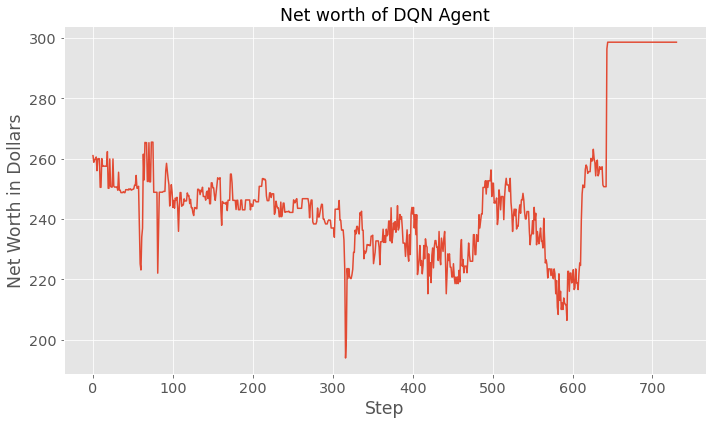

In [24]:
#Plot the networth
#dates = subset_data.index
plt.figure(figsize=(10, 6), tight_layout=True)
plt.plot(portfolio.performance.index, portfolio.performance['net_worth'], label="Net Worth")
plt.xlabel("Step")
plt.ylabel("Net Worth in Dollars")
plt.title("Net worth of DQN Agent")
plt.show()

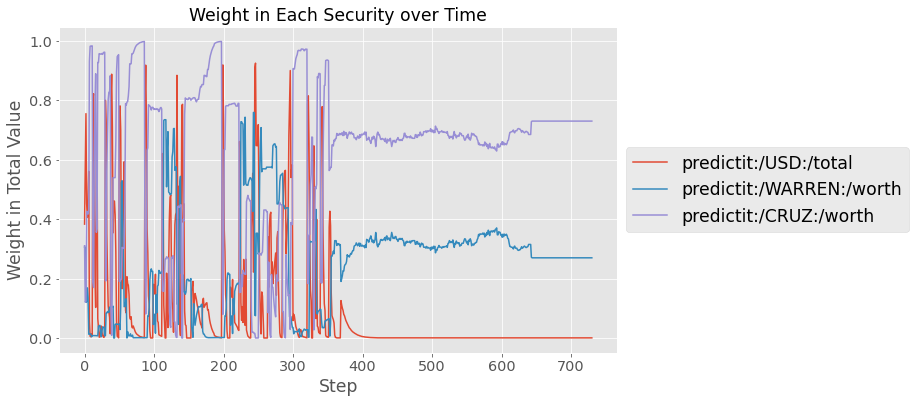

In [25]:
### Plot the total balance in each type of item
import seaborn as sns

ax = portfolio.weights.iloc[:,:].plot(figsize=(10, 6))

plt.xlabel("Step")
plt.ylabel("Weight in Total Value")
plt.title("Weight in Each Security over Time")
plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.show()

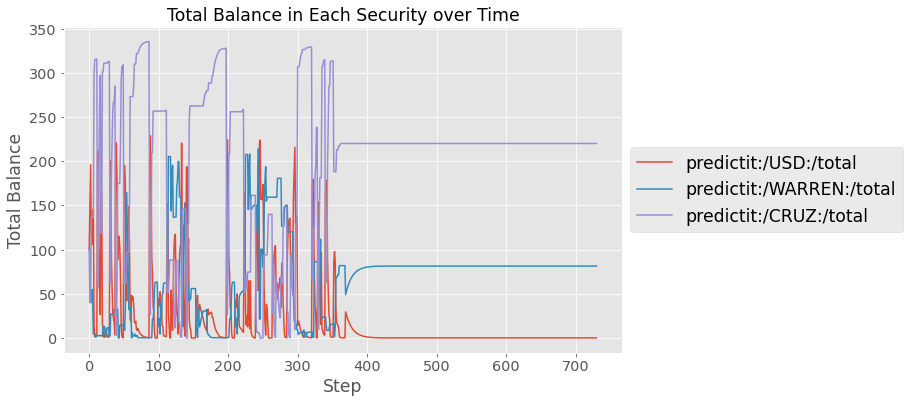

In [26]:
total_shares = portfolio.performance.loc[:, [("total" in name) for name in portfolio.performance.columns]]
total_shares.plot(figsize=(10, 6))


plt.xlabel("Step")
plt.ylabel("Total Balance")
plt.title("Total Balance in Each Security over Time")
plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.show()

In [27]:
total_balances = portfolio.performance.loc[:, [("total" in name) for name in portfolio.performance.columns]]
change_df = total_balances.dropna().pct_change()
change_df = change_df.replace([np.inf, -np.inf, np.nan], 0)
change_in_balances = change_df.iloc[-1].values
total_changes = np.sum(change_in_balances)
total_changes

0.0

In [28]:
total_balances = portfolio.performance.loc[:, [("total" in name) for name in portfolio.performance.columns]]
change_df = total_balances.dropna().pct_change()
change_df = change_df.replace([np.inf, -np.inf, np.nan], 0)
change_in_balances = change_df.iloc[-1].values
change_in_balances

array([0., 0., 0.])

## Extra Stuff

In [ ]:
apath = "/Users/jasonfiacco/Documents/Yale/Senior/thesis/jasonfiacco-selectedmarkets-mytickers.xlsx"
df = pd.read_excel(apath, skiprows=2)
jason_tickers = df.iloc[:, 5].tolist()
descriptions = df.iloc[:, 1].tolist()

for ticker, description in zip(jason_tickers, descriptions):
    l = "{} = Instrument(\'{}\', 2, \'{}\')".format(ticker, ticker, description)
    print(l)

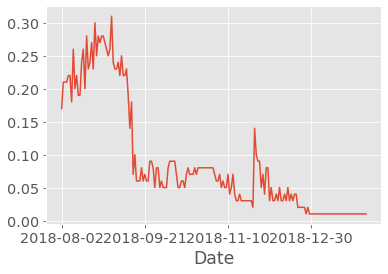

In [55]:
import matplotlib.pyplot as plt
#closing_prices = test_data.loc[:, [("price_norm" in name) for name in test_data.columns]]
my_data = all_data[(pd.to_datetime(all_data.index)>= '08-02-2018')]
my_data["MANAFORT:close"].plot()


In [ ]:
closing_prices.plot(figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Closing prices of all markets")
plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.show()

In [53]:
portfolio.performance[["predictit:/MANAFORT:/worth", "predictit:/MANAFORT:/total"]]

,predictit:/MANAFORT:/worth,predictit:/MANAFORT:/total
step,,
0,75.0,500
1,75.0,500
2,75.0,500
3,75.0,500
4,75.0,500
...,...,...
87,75.0,500
88,75.0,500
89,75.0,500
